# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd             # импортируем библиотеку пандас
import matplotlib.pyplot as plt # импортируем библиотеку матплотлиб 
import numpy as np              # импортируем библиотеку нампай
import seaborn as sns           # импортируем библиотеку сиаборн

**Заранее улчшим качество графиков и изменим параметры по умолчанию**

In [2]:
%config InlineBackend.figure_format = 'retina' # устанавливаем конфиг, повыщающий разрешение графиков
plt.style.use('bmh')
from pylab import rcParams
rcParams['figure.figsize'] = 14,6

**Откроем файл с данными и изучим общую информацию**

In [3]:
df = pd.read_csv('/Users/whyyoutried/Downloads/real_estate_data.csv', sep='\t') # читаем файл с данными
df.head(5) # выводим первые 5 строк нашего дата фрейма

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Комментарий к дата фрейму**

- Есть пропуски, необходимо посмотреть а сколько их всего и в каких столбцах, поскольку это может повлиять на наши дальнейшие действия - где-то пропуски заменим медианным значением, а где-то - нулями. 

## Предобработка данных

In [4]:
df.info() # выводим информацию о дата фрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Комментарий к дата фрейму**
- в некоторых столбцах пропусков нет, а в некоторых пропусков больше, чем заполненных ячеек

**Посмотрим сколько пропусков в каждом столбце дата фрейма**

In [5]:
df.isna().sum() # выводим количество пропусков для каждого столбца

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Комментарий к дата фрейму**

- В столбцах: "parks_nearest", "ponds_nearest", "is_apartment", "ceiling_height" и "balcony" - пропусков либо больше половины, либо около 10.000, с этими столбцами надо поработать в первую очередь

In [6]:
df['ceiling_height'].unique() # посмотрим уникальные значения для столбца с высотой потлков

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [7]:
type(df['ceiling_height'].unique()) # определяем тип списка

numpy.ndarray

In [8]:
import numpy as np # импортируем библиотеку нампай

In [9]:
np.array(pd.Series(df['ceiling_height'].unique()).sort_values()) # выводим отсортированный список
# значений с высотой потлков

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

**Комментарий к дата фрейму**

- значения свыше 6 метров очень сомнительны, поэтому некоторые из этих строк лучше удалить, а - исправить опечатку, например, квартиры с высотой потолков 20 - 32 м , скорее всего, на самом деле с - 2 - 3.2 м, и появление таких данных обслувлено человеческим фактором

In [10]:
df['ceiling_height'].mean() # выводим среднее значение для столбца 'ceiling_height'

2.7714988968559835

In [11]:
df['ceiling_height'].median() # выводим медианное значение для столбца 'ceiling_height'

2.65

In [12]:
df.loc[df['ceiling_height'] > 10, 'ceiling_height'] = df.loc[df['ceiling_height'] > 10, 'ceiling_height'] / 10 
# исправим опечатки пользователей, и значения высоты потолков больше 10 метров поделим на 10
np.array(pd.Series(df['ceiling_height'].unique()).sort_values()) # выводим отсортированный список значений 
# с высотой потлков

array([ 1.  ,  1.03,  1.2 ,  1.4 ,  1.75,  2.  ,  2.2 ,  2.25,  2.26,
        2.3 ,  2.34,  2.4 ,  2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,
        2.51,  2.52,  2.53,  2.54,  2.55,  2.56,  2.57,  2.58,  2.59,
        2.6 ,  2.61,  2.62,  2.63,  2.64,  2.65,  2.66,  2.67,  2.68,
        2.69,  2.7 ,  2.71,  2.72,  2.73,  2.74,  2.75,  2.76,  2.77,
        2.78,  2.79,  2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,  2.86,
        2.87,  2.88,  2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,
        2.96,  2.97,  2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,
        3.05,  3.06,  3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,
        3.14,  3.15,  3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,
        3.24,  3.25,  3.26,  3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,
        3.33,  3.34,  3.35,  3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,
        3.43,  3.44,  3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,
        3.52,  3.53,  3.54,  3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,
        3.62,  3.63,

In [13]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median()) # заполняем пропуски 
# медианным значением
df['ceiling_height'].isna().sum() # проверям остались ли пропуски

0

In [14]:
df = df.loc[(df['ceiling_height'] > 2.4) & (df['ceiling_height'] <= 4.2)] # оставляем значения
# которые соответсвуют СНиП
np.array(pd.Series(df['ceiling_height'].unique()).sort_values()) # выводим отсортированный список значений
# с высотой потлков

array([2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53, 2.54, 2.55,
       2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64, 2.65, 2.66,
       2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77,
       2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88,
       2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99,
       3.  , 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 ,
       3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2 , 3.21, 3.22,
       3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33,
       3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.42, 3.43, 3.44, 3.45,
       3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53, 3.54, 3.55, 3.56,
       3.57, 3.58, 3.59, 3.6 , 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69,
       3.7 , 3.75, 3.76, 3.78, 3.8 , 3.82, 3.83, 3.84, 3.85, 3.86, 3.87,
       3.88, 3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.1 , 4.14, 4.15, 4.19,
       4.2 ])

In [15]:
df['ceiling_height'].mean() # выводим среднее значение для столбца 'ceiling_height'

2.6952030317148044

In [16]:
df['ceiling_height'].median() # выводим медианное значение для столбца 'ceiling_height'

2.65

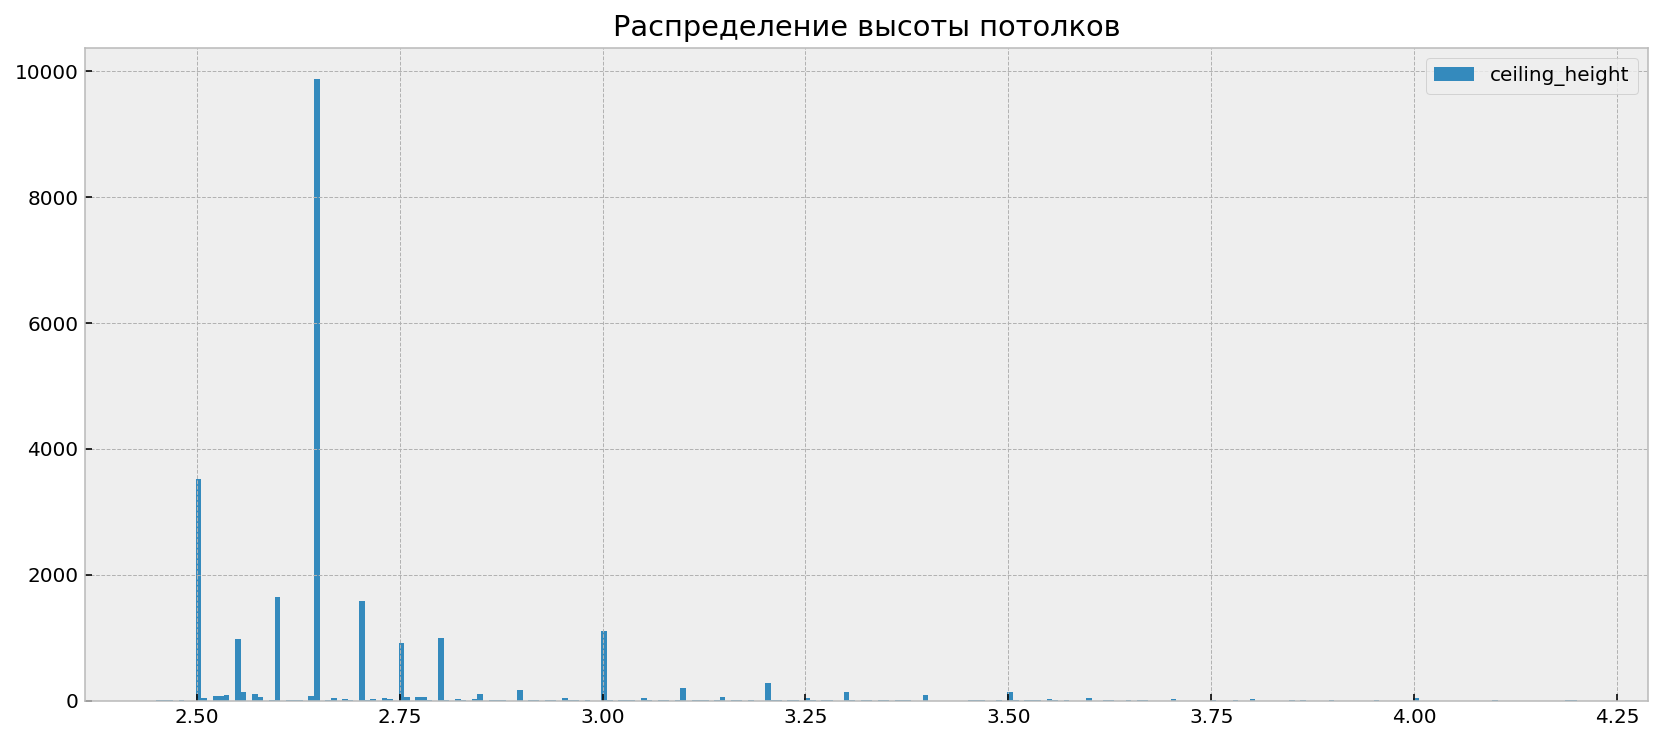

In [17]:
df['ceiling_height'].hist(bins='auto', legend=True).title.set_text('Распределение высоты потолков') 
# построим гистограмму 

In [18]:
df['ceiling_height'].mode() # определяем моду 

0    2.65
Name: ceiling_height, dtype: float64

**Комментарий к работе со столбцом 'ceiling_height'**

- удалены строки, в которых высота потолков не соответсует СНиП (потолки ниже 2,4 м и выше 4,2 метров)
- исправлены аномальные значения, появившиеся в силу человеческого фактора
- пропуски заполненны медианным значением
- среднее значением изменилось лишь на 0,05, а медианное осталось прежним, поэтому заполнение пропусков медианным значением, прежде не удалив выбросы, никак не повлияло на итоговый результат
- построена гистограмма, мода высоты потолков составила 2,65 м

Несмотря на то, что работа со столбцом 'ceiling_height' почти не повлияло на среднее и медиану, данные преобразования было необходимо провести, поскольку наличие квартир с потолками свыше 6 метров крайне сомнительно. А причиной появления таких данных могли быть либо опечатки людей при публикации объявления о продаже, либо же технический сбой оборудования при проведении замеров квартиры. Так или иначе, теперь со столбцом 'ceiling_height' проблем нет.

**Далее будем работать со столбцом 'balcony'**

In [19]:
df['balcony'].unique() # посмотрим уникальные значения в столбце 'balcony'

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

**Комментарий к полученному списку значений столбца 'balcony'**

Поскольку у нас есть пропуски можно предположить, что некоторые владельцы квартир без балкона не знали, что указывать в этом поле, поэтому оставили его пустым, что и стало причиной появления пропусков в данном столбце.


In [20]:
df['balcony'] = df['balcony'].fillna('0') # заполним нулями пропуски в столбце 'balcony'
df.isna().sum() # проверим что все пропуски заполнились

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1895
floor                       0
is_apartment            20860
studio                      0
open_plan                   0
kitchen_area             2265
balcony                     0
locality_name              49
airports_nearest         5512
cityCenters_nearest      5492
parks_around3000         5491
parks_nearest           15574
ponds_around3000         5491
ponds_nearest           14544
days_exposition          3168
dtype: int64

In [21]:
df = df.astype({'balcony' : 'int32'}) # поменяем тип данных в столбце 'balcony'
# чтобы при построении гистограммы не появилась ошибка

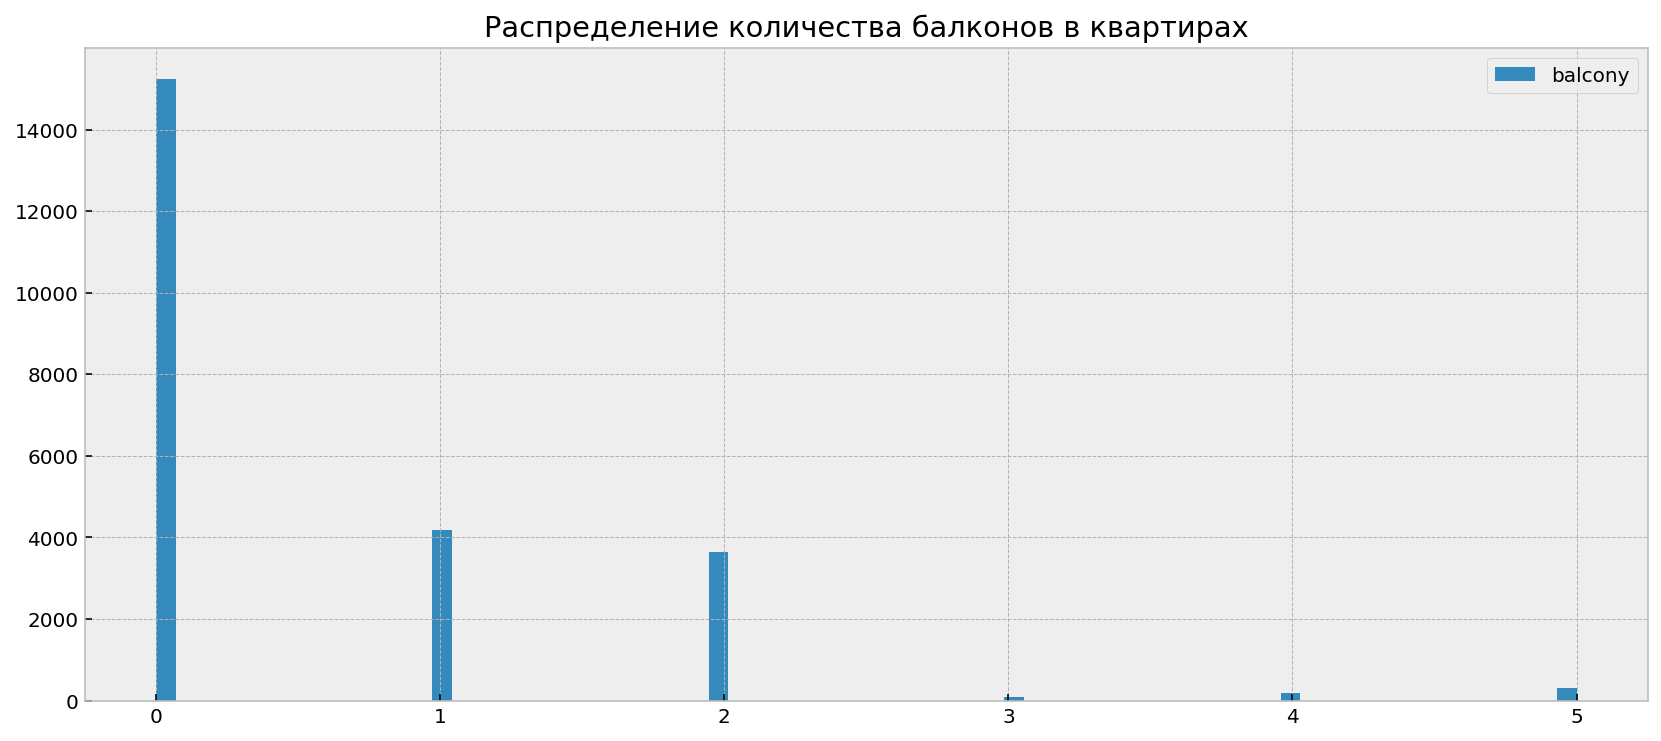

In [22]:
df['balcony'].hist(bins='auto', legend=True).title.set_text('Распределение количества балконов в квартирах') 
# построим гистограмму 

**Комментарий к работе со столбцом 'balcony'**

- все пропуски заполнены 0, следовательно, наличие нуля в данном столбце означает, что в квартире площадь балкона равна 0 м, иначе говоря, он просто отсутствует
- построена гистограмма с распределением количества балконов в квартире, квартиры с более чем 2 балконам - просто редкость
- сменен тип данных с 'int64' на 'int32' для того, чтобы код затрачивал меньше ресурсов

**Далее будем работать со столбцом 'is_apartment'**

In [23]:
df['is_apartment'].unique() # посмотрим уникальные значения в столбце 'is_apartment'

array([nan, False, True], dtype=object)

**Комментарий к полученному списку значений столбца 'is_apartment'**

Ситуация с этим столбцом такая же, что и с 'balcony', только в этом столбце булевы значения, поэтому пропуски заполним False

In [24]:
df['is_apartment'] = df['is_apartment'].fillna(False) # заполним нулями пропуски в столбце 'is_apartment'
df.isna().sum() # проверим что все пропуски заполнились

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1895
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2265
balcony                     0
locality_name              49
airports_nearest         5512
cityCenters_nearest      5492
parks_around3000         5491
parks_nearest           15574
ponds_around3000         5491
ponds_nearest           14544
days_exposition          3168
dtype: int64

<AxesSubplot:title={'center':'Объект является апартаментами?'}>

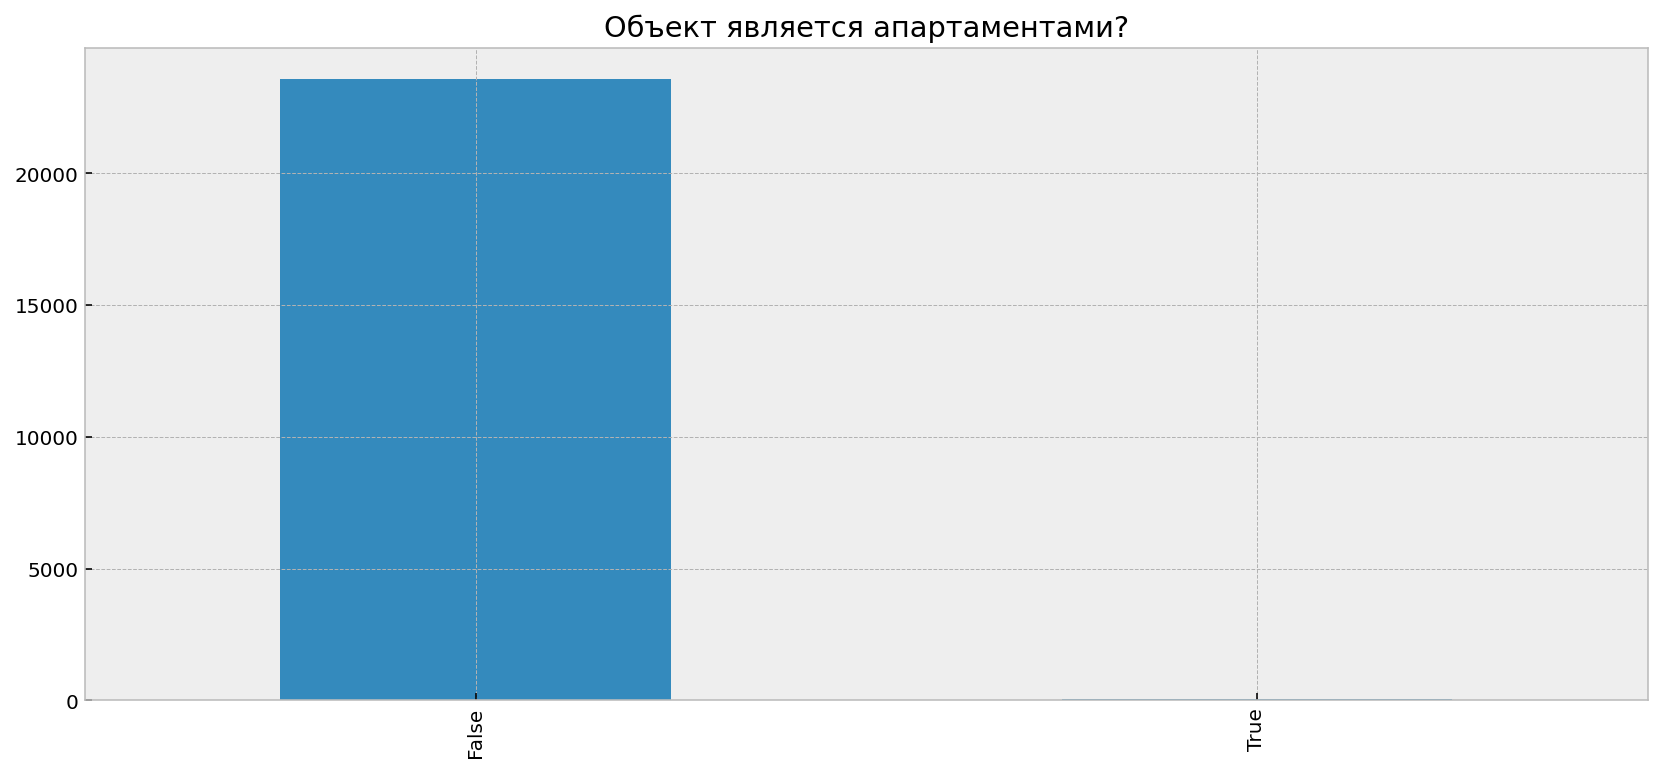

In [25]:
df['is_apartment'].value_counts().plot(kind='bar', title='Объект является апартаментами?')
# построим столбчатую диаграмму, поскольку у нас дискретные данные (либо апартаменты, либо нет)

**Комментарий к работе со столбцом 'is_apartment'**

- все пропуски заполнены False, следовательно, это означает, что опубликованный лот является квартирой, а не апартаментами
- построена столбчатая диграмма для критерия - "является ли объект апартаментами?", в нашем датасете практически все объекты - квартиры

**Далее будем работать со столбцом 'locality_name'**

In [26]:
df['locality_name'].unique() # выведем список значений столбца 'locality_name'

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [27]:
df = df.dropna(subset=['locality_name']) # удалим строки, в которых не указано местоположение квартиры

In [28]:
df['locality_name'] = df['locality_name'].astype('str') # приводим все значения в столбце 'locality_name'
# к строковому типу

In [29]:
def editing(name): # вводим функцию для удаления неявных дубликатов в столбце 'locality_name'
    splited_name = name.split(' ') # в переменную записывается каждое слово по отдельности 
    # для дальнейшей проверки, есть ли среди этого списка слов те, которые нужно удалить 
    words_2_delete = {'коттеджный', 'посёлок', 'поселок', 'городского', 'типа', 'городской', 'станции'
                     'село', 'деревня', 'садовое', 'товарищество', 'садоводческое', 'некоммерческое',
                     'при','железнодорожной', 'станции', 'платформа', 'форт', 'село', 'пансионат'} 
    # задаем множество со словами, которые надо удалить
    good_words = [word.lower() for word in splited_name if word not in words_2_delete]
    # проверяем полученный список в splited_name и удаляем слова, которые записаны в words_2_delete
    return ' '.join(good_words) # объединяем оставшиеся слова в одно
df['locality_name'] = df['locality_name'].apply(editing) # применяем функцию к столбцу 'locality_name'
df['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'фёдоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное село', 'понтонный',
       'сясьстрой', 'старая', 'лесколово', 'сланцы', 'путилово',
       'ивангород', 'шлиссельбург', 'никольское', 'зеленогорск',
       'сосновый бор', 'новый свет', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'рощино', 'кириши', 'луга', 'волосово', 'отрадное',
       'павлово', 'оредеж', 'копорье', 'молодёжное', 'тихвин', 'победа',
       'нурма', 'синявино', 'тосно', 'стрельна', 'бокситогорск',

In [30]:
df_ext = df.copy() # создаем новый дата фрейм - расширенный по сравнению с существующим
df_ext['is_spb'] = (df['locality_name'] == 'санкт-петербург') # добавляем в новый дата фрейм столбец
# определяющий находится ли конкретный лот в СПб или нет
df_ext.head(5) # выводим первые 5 строк нового дата фрейма

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_spb
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,True
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,2,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,False
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,True
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,False,...,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,True
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,True


**Комментарий к работе со столбцом 'locality_name'**

- удалены 49 строк, в которых отсутствует информация о местоположении квартиры
- исключены 60 вариантов записи названий населенных пунктов, которые дублировали информацию, уже имеющуюся в дата фрейме
- создан новый расширенный дата фрейм для оптимазиции дальнейшей аналитической работы

**Далее будем работать со столбцами 'total_area', 'living_area' и 'kitchen_area'**

<AxesSubplot:>

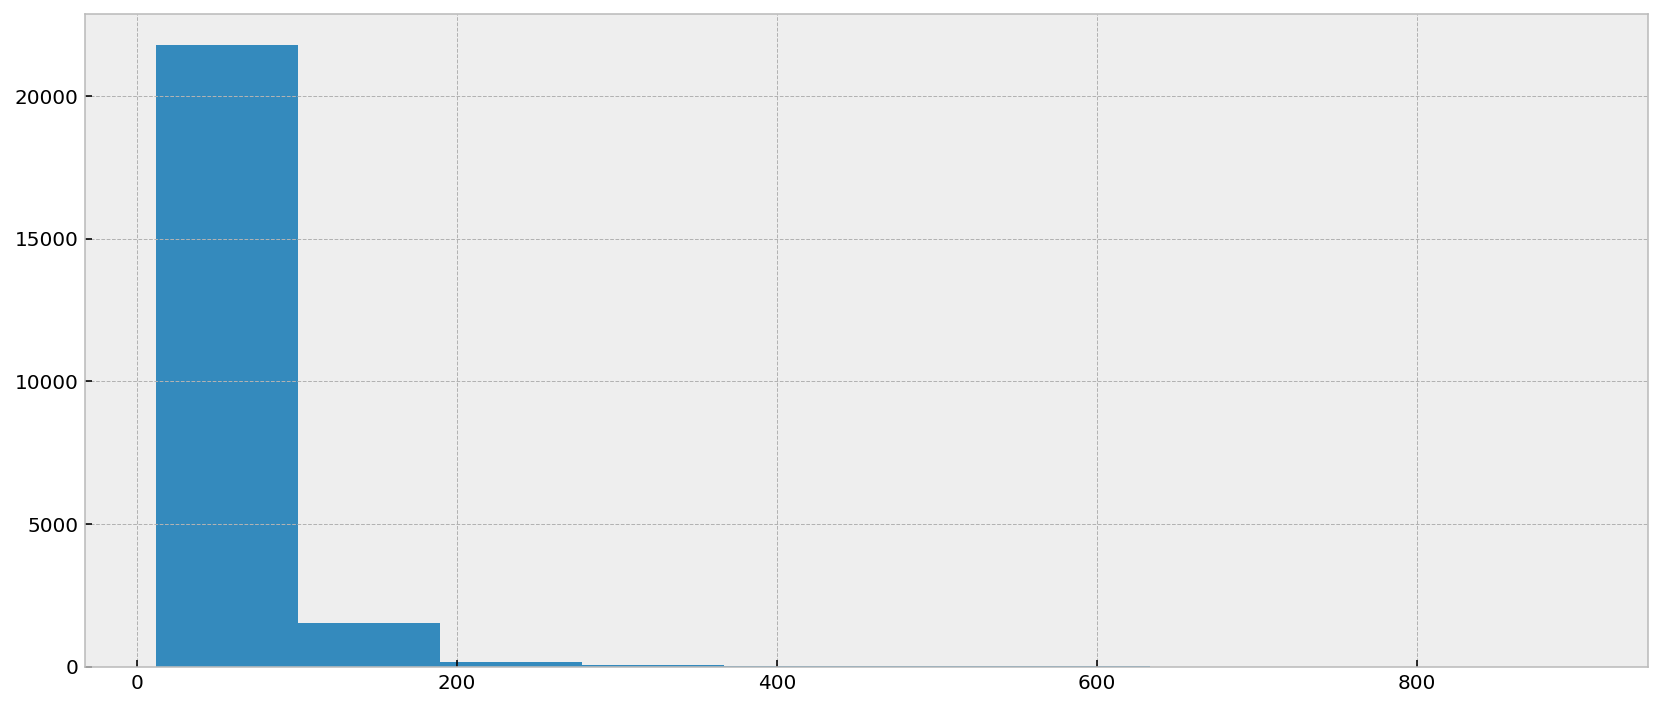

In [31]:
df_ext['total_area'].hist() # построим гистограмму

**Комментарий к полученной гистограмме по столбцу 'total_area'**

- поскольку квартир с общей площадью более 150 кв. метров крайне мало, лучше построить график без их учета

In [32]:
df_ext.loc[df_ext['total_area'] > 150]['total_area'].count() / df_ext['total_area'].count()
# определим долю таких квартир, а учитывая, что их менее 1% то такие данные можно смело не учитывать 
# так как это никак не исказит полученную гистограмму

0.023294297352342157

<AxesSubplot:>

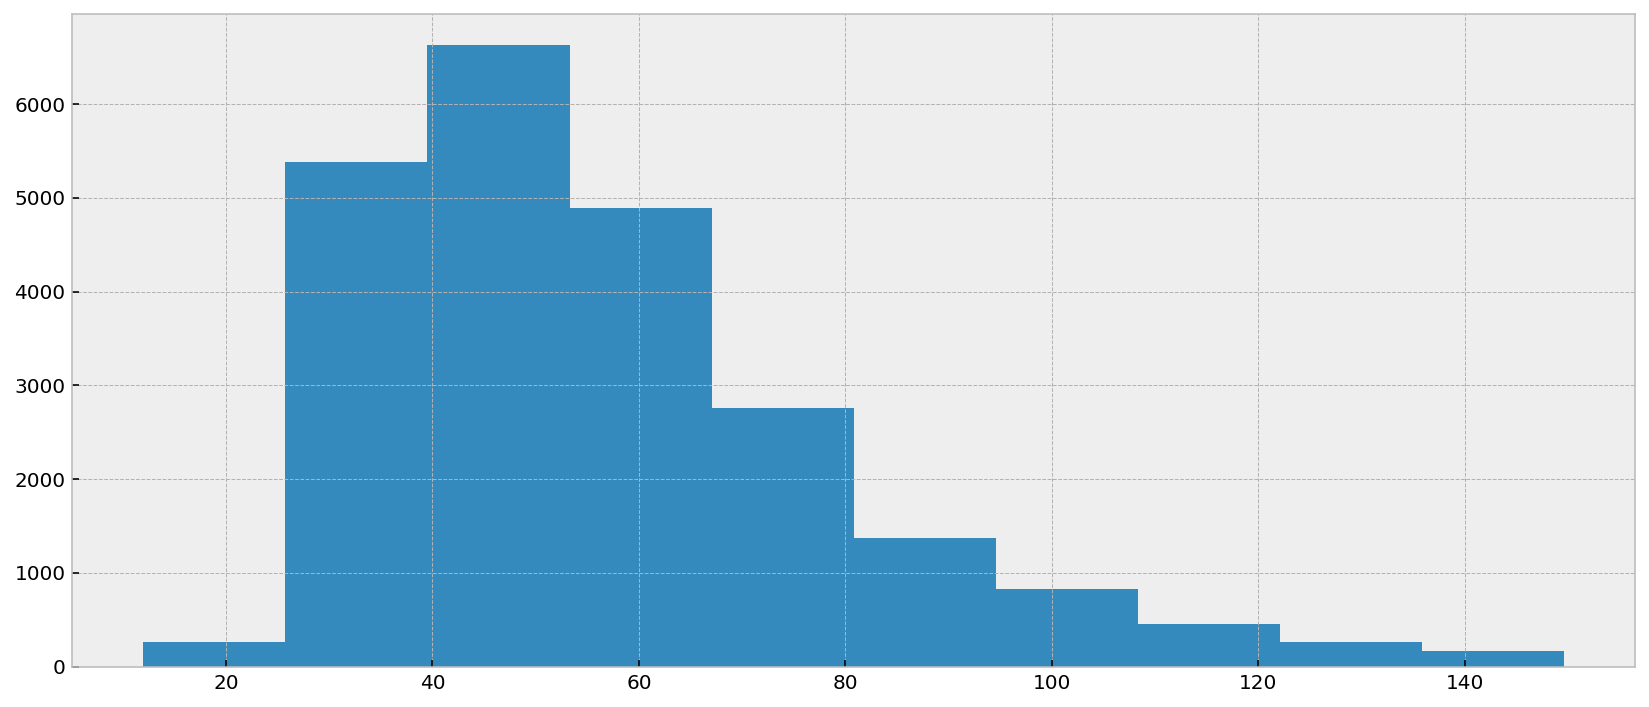

In [33]:
df_ext.loc[df_ext['total_area'] < 150]['total_area'].hist()
# строим гистограмму без учета квартир с площадью более 150 кв. метра

In [34]:
df_ext['living_coeff'] = df_ext['living_area'] / df_ext['total_area']  # добавим столбец с коэффицентами - отношение
                                                                       # жилой площади к общей 
df_ext['kitchen_coeff'] = df_ext['kitchen_area'] / df_ext['total_area']# добавим столбец с коэффицентами - отношение
                                                                       # площади кухни к общей 

In [35]:
living_median = df_ext.groupby('rooms')['living_coeff'].median()   # найдем медианное значение коэффицента
                                                                   # living_coeff с учетом количества комнат
kitchen_median = df_ext.groupby('rooms')['kitchen_coeff'].median() # найдем медианное значение коэффицента
                                                                   # kitchen_coeff с учетом количества комнат

In [36]:
for rooms_am in df_ext['rooms'].unique():
    df_ext.loc[(df_ext['living_area'].isna()) & (df_ext['rooms'] == rooms_am), 'living_area'] = \
    df_ext.loc[(df_ext['living_area'].isna()) & (df_ext['rooms'] == rooms_am), 'total_area'] * living_median[rooms_am]
# заполним пропуски в столбце 'living_area' медианным значением, учитывающим количество комнат в квартире
df_ext.isna().sum() # проверим что все пропусков в столбце 'living_area' больше нет

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2256
balcony                     0
locality_name               0
airports_nearest         5504
cityCenters_nearest      5484
parks_around3000         5483
parks_nearest           15540
ponds_around3000         5483
ponds_nearest           14520
days_exposition          3167
is_spb                      0
living_coeff             1890
kitchen_coeff            2256
dtype: int64

In [37]:
for rooms_am in df_ext['rooms'].unique():
    df_ext.loc[(df_ext['kitchen_area'].isna()) & (df_ext['rooms'] == rooms_am), 'kitchen_area'] = \
    df_ext.loc[(df_ext['kitchen_area'].isna()) & (df_ext['rooms'] == rooms_am), 'total_area'] * kitchen_median[rooms_am]
# заполним пропуски в столбце 'kitchen_area' медианным значением, учитывающим количество комнат в квартире
df_ext.isna().sum() # проверим что все пропусков в столбце 'kitchen_area' больше нет

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              196
balcony                     0
locality_name               0
airports_nearest         5504
cityCenters_nearest      5484
parks_around3000         5483
parks_nearest           15540
ponds_around3000         5483
ponds_nearest           14520
days_exposition          3167
is_spb                      0
living_coeff             1890
kitchen_coeff            2256
dtype: int64

**Комментарий к работе со столбцом 'kitchen_area'**

- после заполнения пропусков в столбце 'kitchen_area' осталось 196 строки с пустым значением в этом столбце, надо разобраться в чем проблема, для этого посмотрим в каких строках остались пропуски

In [38]:
df_ext.query('kitchen_area.isna()') # посмотрим в каких строках остались пропуски в столбце 'kitchen_area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_spb,living_coeff,kitchen_coeff
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.65,24.0,15.500000,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,181.0,False,0.574074,NaN
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.65,14.0,17.000000,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,False,0.680000,NaN
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.65,17.0,24.750000,4,False,...,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,True,0.912947,NaN
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.65,26.0,24.300000,19,False,...,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,False,0.706395,NaN
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.65,10.0,17.238251,7,False,...,NaN,NaN,NaN,NaN,NaN,NaN,29.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,2.65,25.0,18.000000,16,False,...,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0,True,0.692308,NaN
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,2.65,24.0,18.000000,4,False,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,0.649819,NaN
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,2.65,19.0,17.927781,8,False,...,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,True,NaN,NaN
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,2.65,9.0,18.000000,8,False,...,NaN,NaN,NaN,NaN,NaN,NaN,82.0,False,0.620690,NaN


**Комментарий к работе со столбцом 'kitchen_area'**

- подозрительно много квартир с 0 комнат - студий, стоит проверить, а сколько всего пропусков в столбце 'kitchen_area' у студий

In [39]:
df_ext.query('kitchen_area.isna() & rooms == 0') # проверим сколько пропусков в столбце 'kitchen_area' у студий

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_spb,living_coeff,kitchen_coeff
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.65,24.0,15.500000,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,181.0,False,0.574074,NaN
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.65,14.0,17.000000,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,False,0.680000,NaN
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.65,17.0,24.750000,4,False,...,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,True,0.912947,NaN
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.65,26.0,24.300000,19,False,...,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,False,0.706395,NaN
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.65,10.0,17.238251,7,False,...,NaN,NaN,NaN,NaN,NaN,NaN,29.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,2.65,25.0,18.000000,16,False,...,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0,True,0.692308,NaN
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,2.65,24.0,18.000000,4,False,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,0.649819,NaN
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,2.65,19.0,17.927781,8,False,...,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,True,NaN,NaN
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,2.65,9.0,18.000000,8,False,...,NaN,NaN,NaN,NaN,NaN,NaN,82.0,False,0.620690,NaN


**Комментарий к работе со столбцом 'kitchen_area'**

- **196 пропуска** ровно столько же, сколько и осталось незаполненных значений в стобце 'kitchen_area'
- это говорит о том, что для студий попросту нет коэффицента 'kitchen_coeff', так как у всех строк дата фрейма с 0 комнатами - квартирами/апартаментами-студиями - пропущено значение в столбце 'kitchen_area', собственно, поэтому и коэффицент 'kitchen_coeff' не был посчитан, так как 0/на общую площадь - будет 0 

**Можно предположить следующее:**

- поскольку в студии формально нет разграничений между кухней и остальной площадью комнаты, то при дальнейшем анализе для студий параметр 'kitchen_area' рассматриваться не будет

<AxesSubplot:>

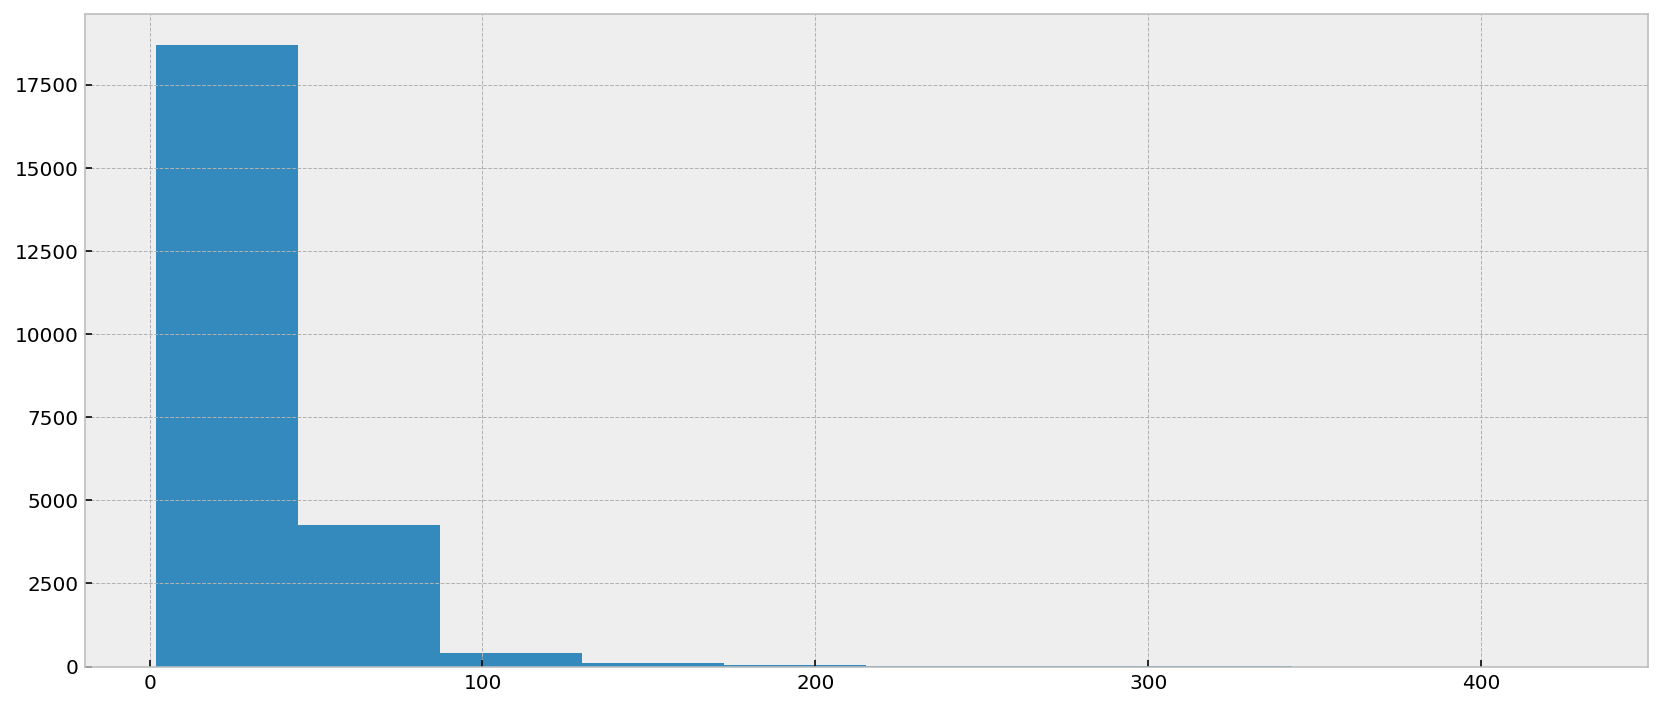

In [40]:
df_ext['living_area'].hist() # строим гистограмму

**Комментарий к полученной гистограмме по столбцу 'living_area'**

- поскольку квартир с жилой площадью более 100 кв. метров крайне мало, лучше построить график без их учета

<AxesSubplot:>

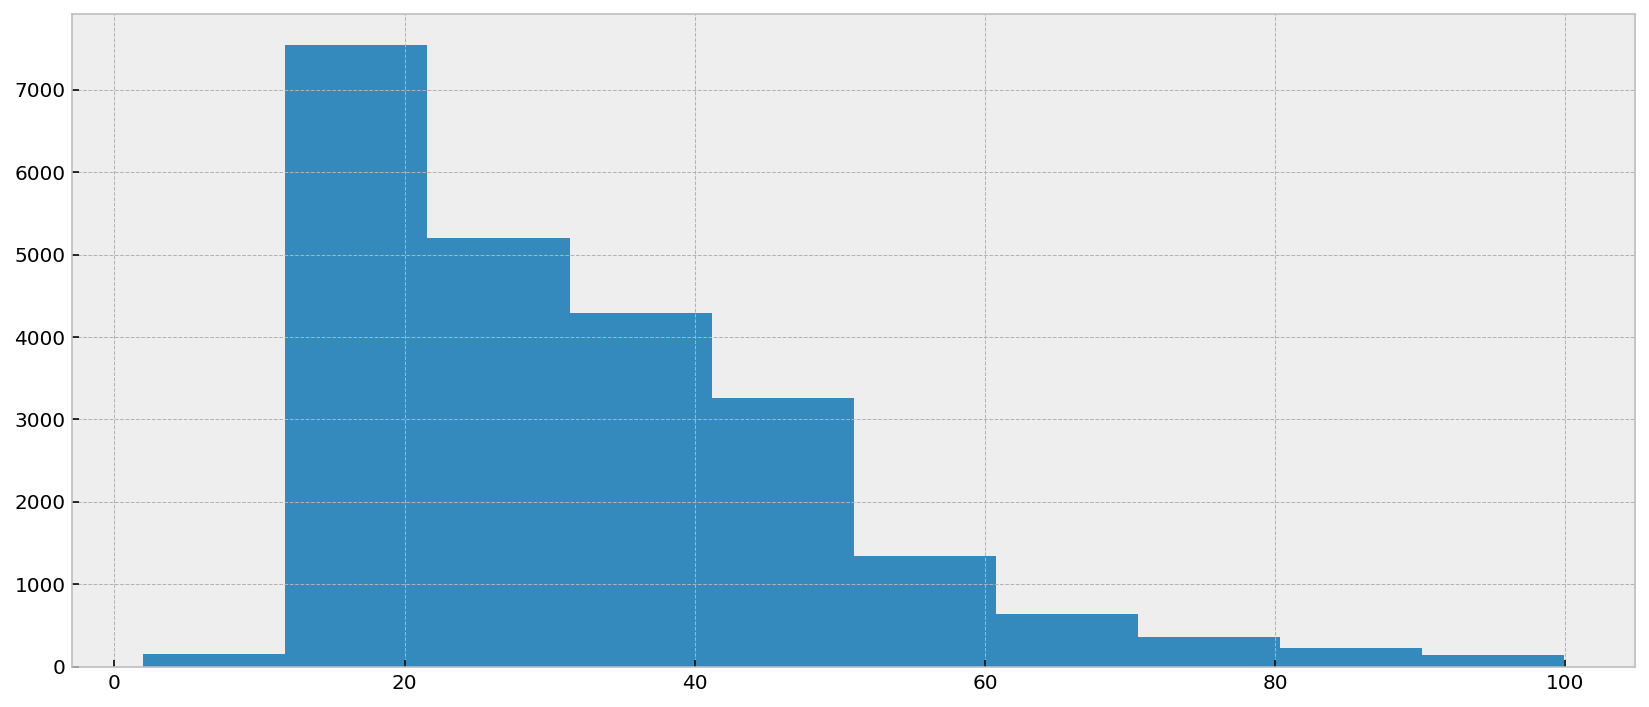

In [41]:
df_ext.loc[df_ext['living_area'] < 100]['living_area'].hist()
# строим гистограмму без учета квартир с жилой площадью более 100 кв. метров

<AxesSubplot:>

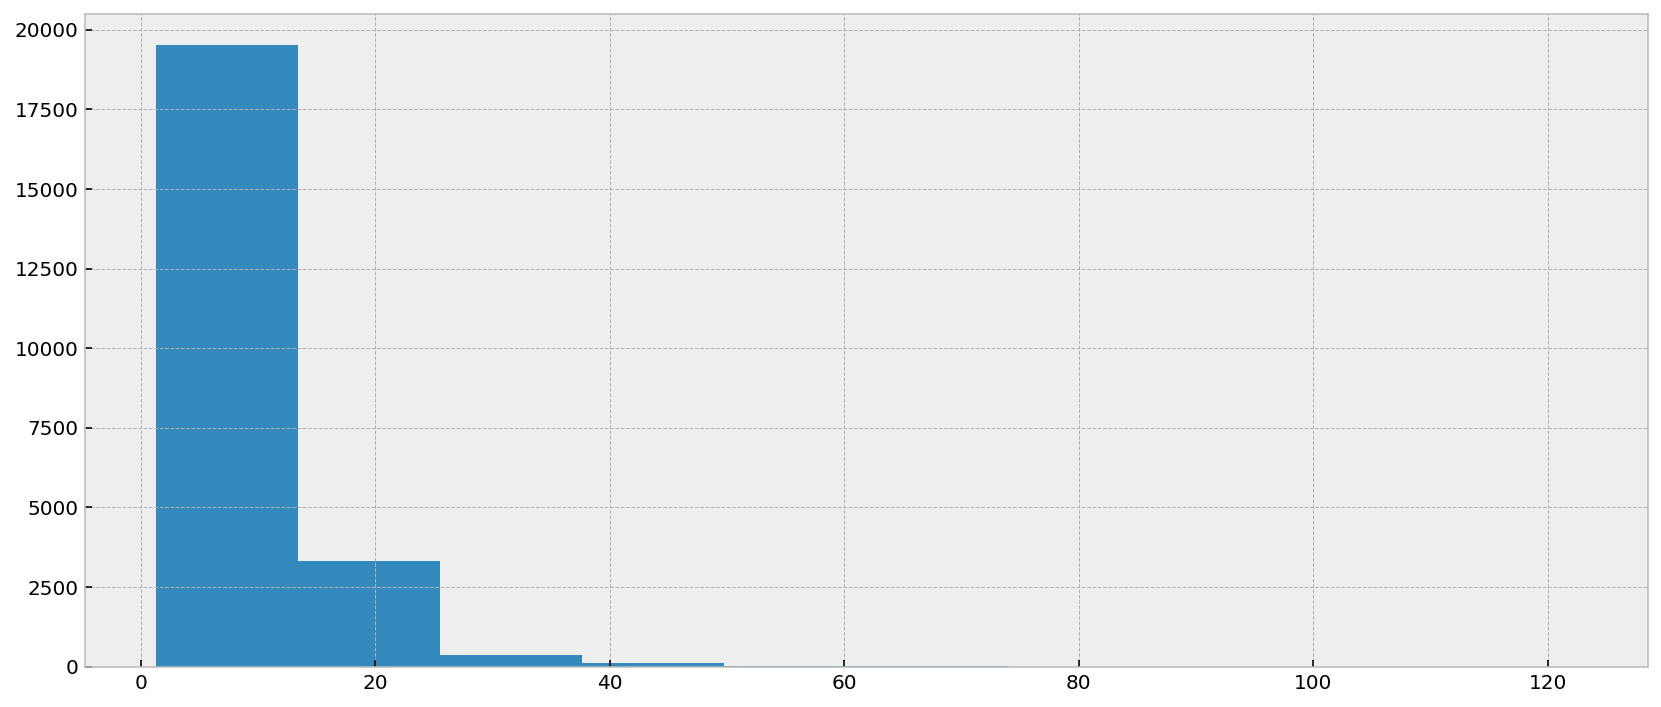

In [42]:
df_ext['kitchen_area'].hist() # строим гистограмму

**Комментарий к полученной гистограмме по столбцу 'kitchen_area'**

- поскольку квартир с площадью кухни более 35 кв. метров крайне мало, лучше построить график без их учета

<AxesSubplot:>

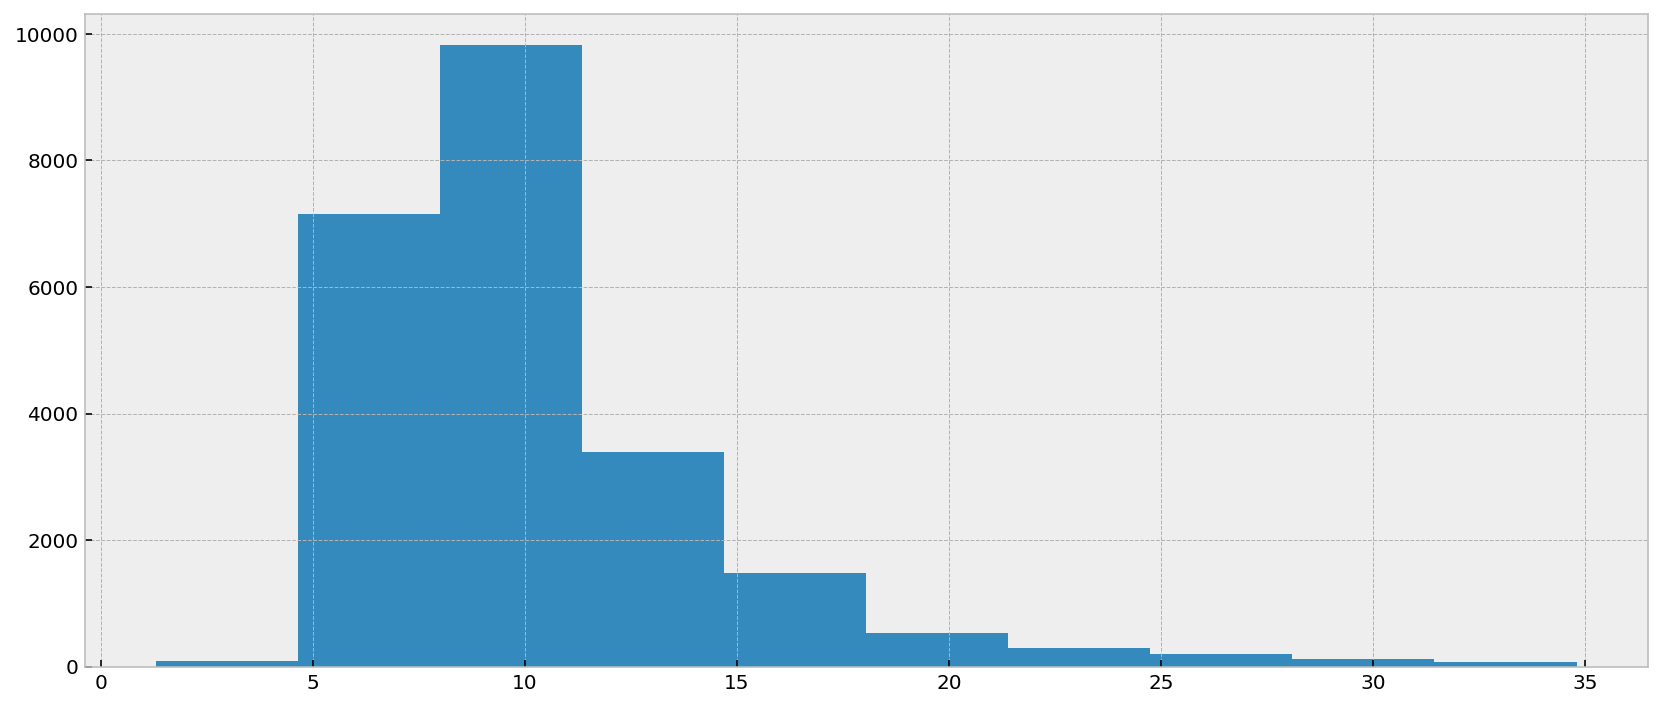

In [43]:
df_ext.loc[df_ext['kitchen_area'] < 35]['kitchen_area'].hist()
# строим гистограмму без учета квартир с кухней более 35 кв. метров

**Комментарий к работе со столбцом 'total_area', 'living_area' и 'kitchen_area'**

- посчитан коэффициент соотношения 'living_area' / 'kitchen_area' к 'total_area'
- заполнены пропуски в столбцах 'living_area' и 'kitchen_area' с помощью полученного коэффициента  
- в объектах-студиях пропуски в столбеце 'kitchen_area' не заполнялись, таких объектов всего 194

**Далее будем работать со столбцом 'last_price'**

<AxesSubplot:>

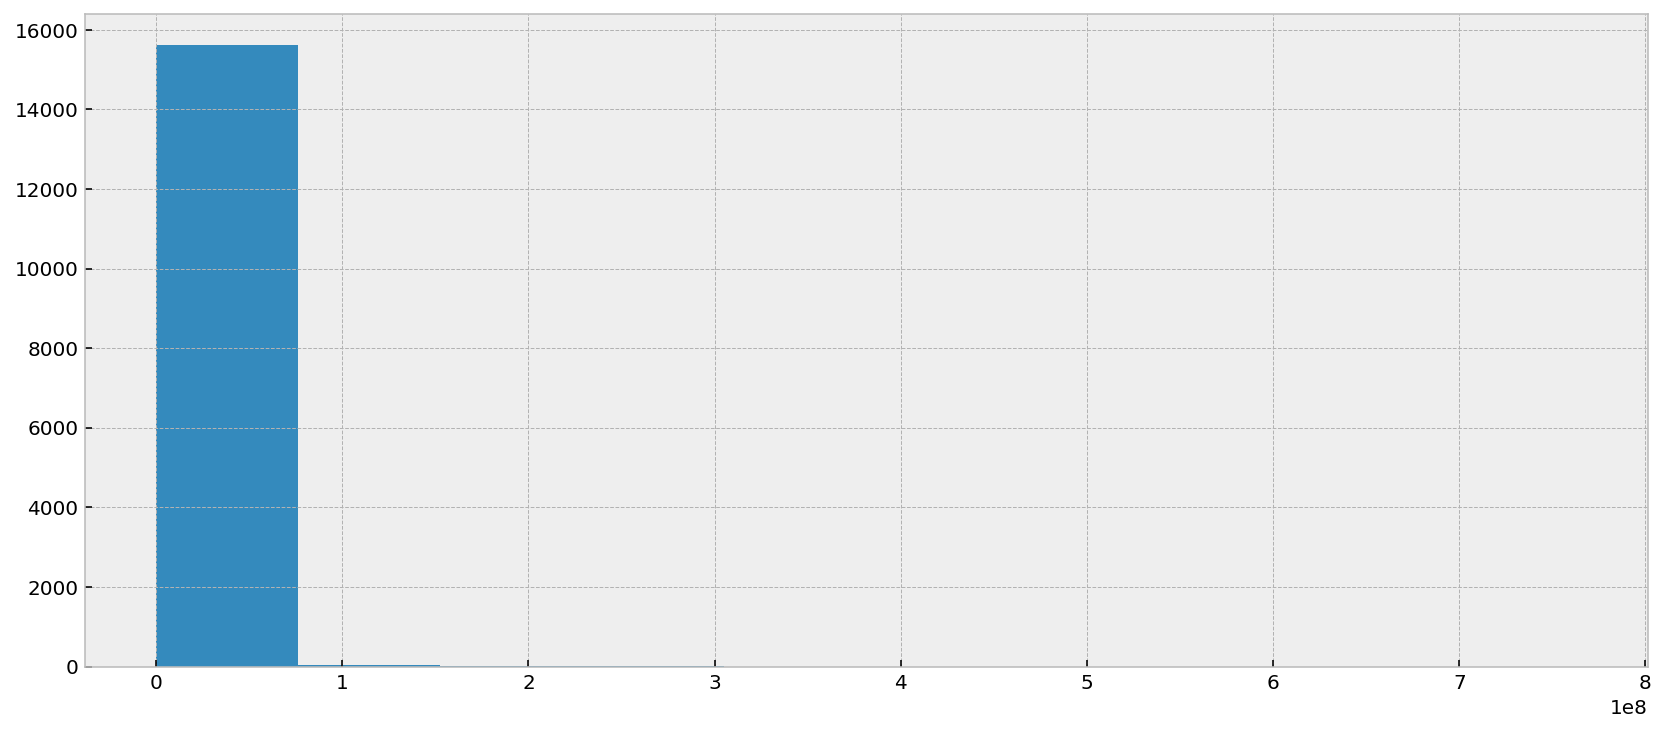

In [44]:
df_ext[df_ext['is_spb'] == True]['last_price'].hist() # строим гистограмму цен на квартиры в СПб

<AxesSubplot:>

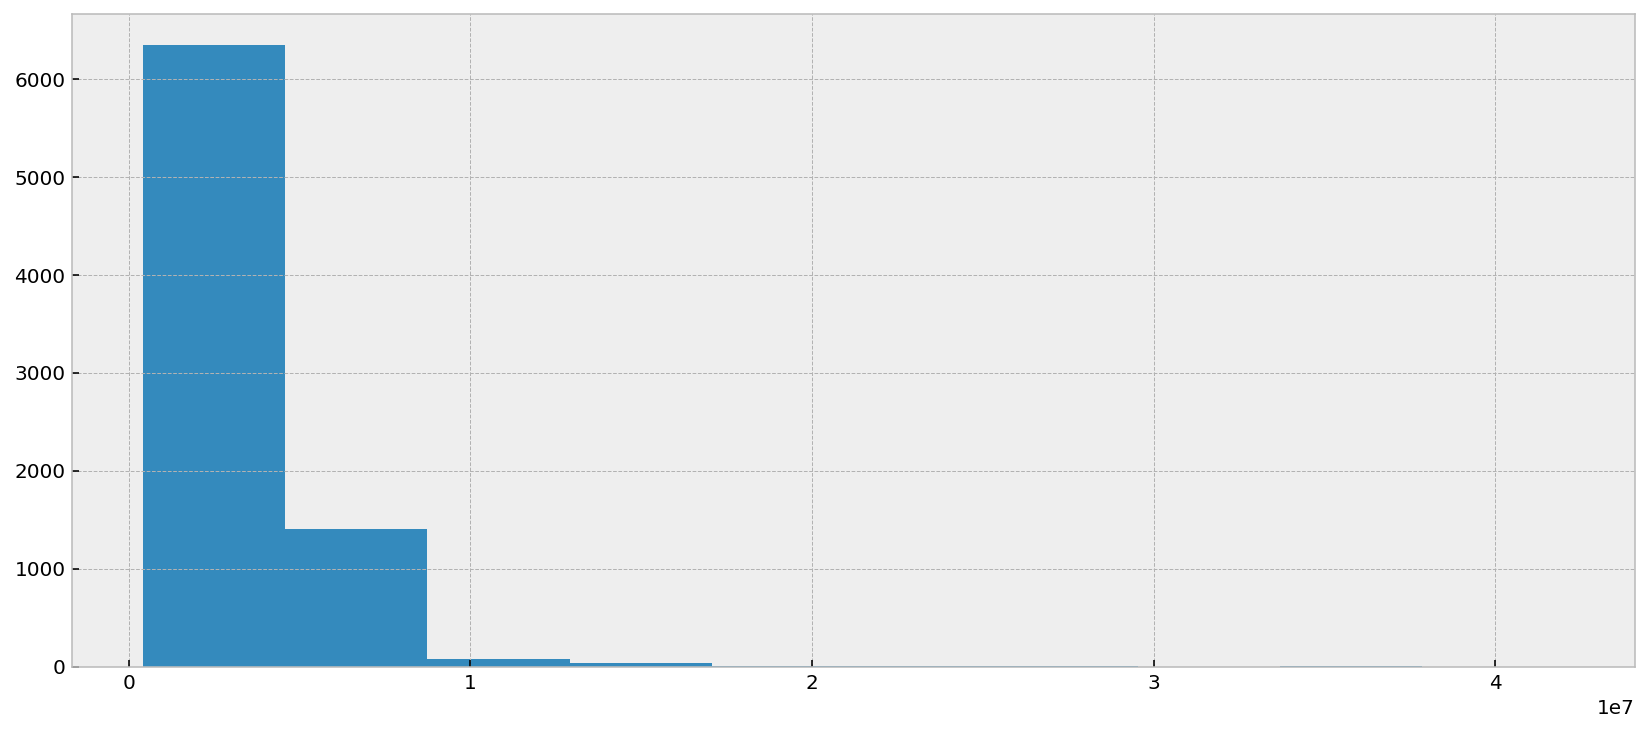

In [45]:
df_ext[df_ext['is_spb'] == False]['last_price'].hist() # строим гистограмму цен на квартиры вне СПб

**Комментарий к полученным гистограммам**

- и в Питере, и в Ленинградской области есть квартиры сильно выделяющиеся на фоне общей массы - выбросы, которые будут удалены 

<AxesSubplot:>

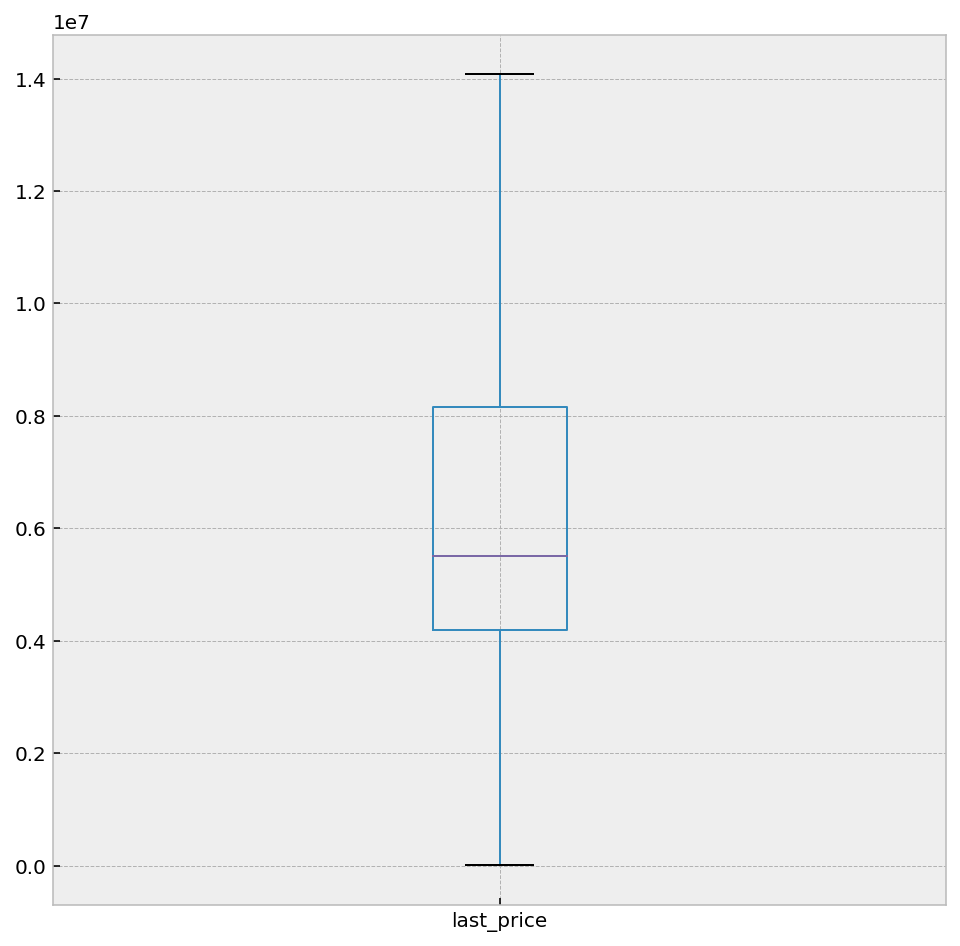

In [46]:
df_ext[df_ext['is_spb'] == True].boxplot('last_price', figsize=(8, 8), showfliers=False)
# определяем границы цен на большинство квартир в СПб (все кроме выбросов)

In [47]:
df_ext = df_ext.query('0 <= last_price <= 1.45e7') # удаляем выбросы

In [48]:
(df_ext['last_price'] < 1.45e7).mean() # доля выбросов составила менее 0,2%

0.9983390195726343

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

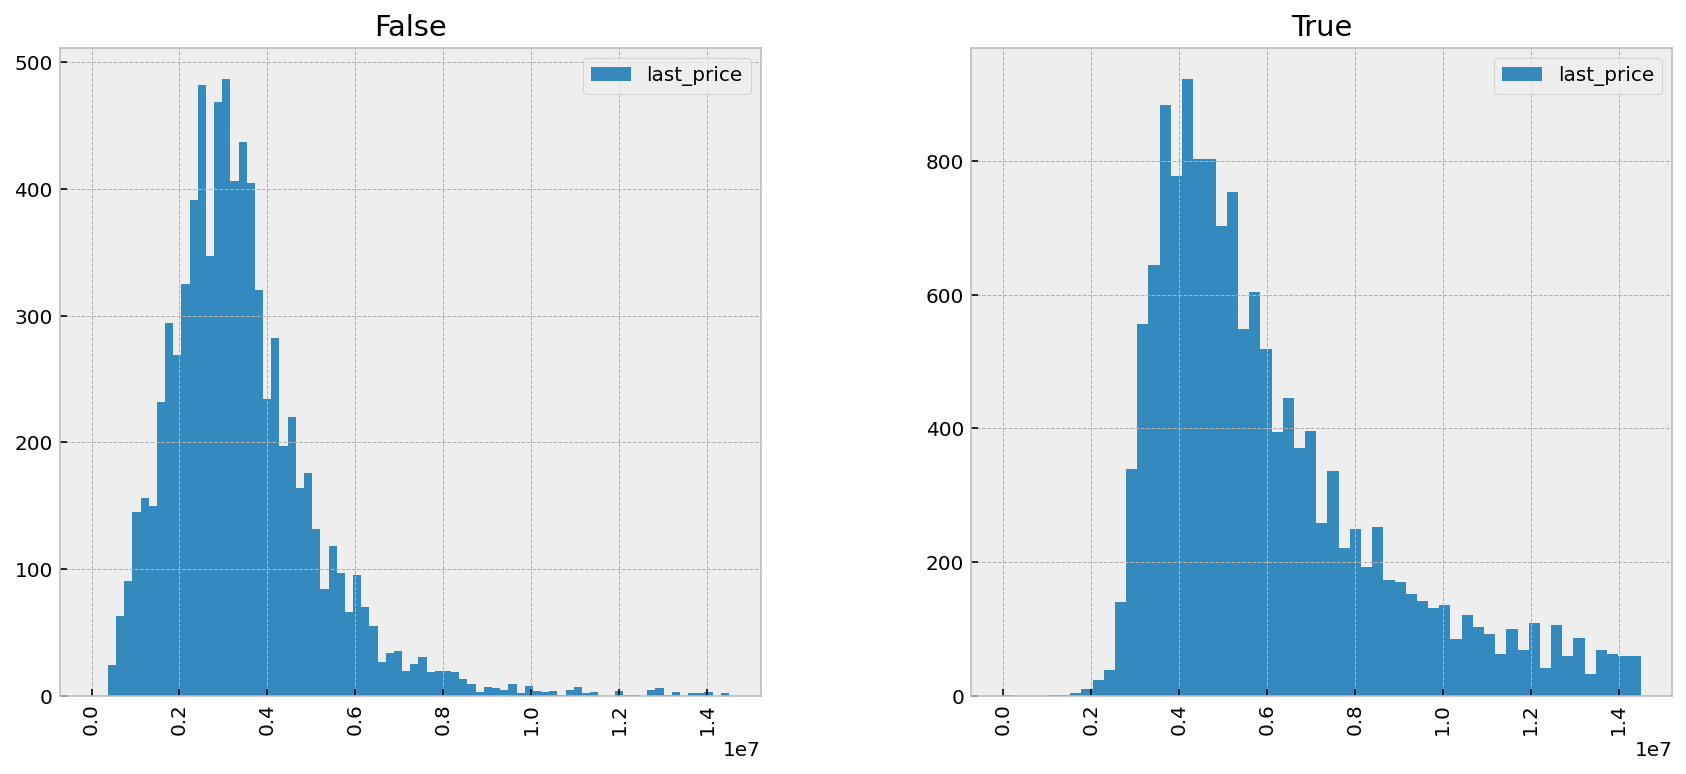

In [49]:
df_ext.hist(column='last_price', by='is_spb', figsize=(14, 6), legend=True, range=(0, 1.45e7), bins='auto')
# посмотрим как влияет местонахождение (внутри СПб и за его пределами) квартиры на распределение цен 

In [50]:
df_ext.query('is_spb == True')['last_price'].mode() # посчитаем моду цен на квартиры внутри СПб

0    4500000.0
Name: last_price, dtype: float64

In [51]:
df_ext.query('is_spb == False')['last_price'].mode() # посчитаем моду цен на квартиры вне СПб

0    3500000.0
Name: last_price, dtype: float64

In [52]:
df_ext.query('is_spb == True')['last_price'].median() # посчитаем медиану цен на квартиры внутри СПб

5260000.0

In [53]:
df_ext.query('is_spb == False')['last_price'].median() # посчитаем медиану цен на квартиры вне СПб

3178368.5

In [54]:
df_ext['price_of_square'] = df_ext['last_price'] / df_ext['total_area'] # создаем столбец с ценой за кв. метр
df_ext['price_of_square'] = df_ext['price_of_square'].astype('int32') # поменяем тип данных в столбце
df_ext.head(5) # посмотрим на новую таблицу

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_spb,living_coeff,kitchen_coeff,price_of_square
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,True,0.472222,0.231481,120370
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,False,0.460396,0.272277,82920
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,13933.0,1.0,90.0,2.0,574.0,558.0,True,0.612500,0.148214,92785
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,True,0.320000,0.410000,100000
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,2.65,12.0,14.4,5,False,...,NaN,NaN,NaN,NaN,NaN,55.0,False,0.473684,0.299342,95065


**Комментарий к полученным гистограммам**

- Внутри СПб мода цены квартиры около 4,5 млн рублей, а в Ленинградской области - 3,5 млн рублей
- Говоря про медианные показатели цены, в СПб - 5,26 млн рублей, а за пределами СПб - 3,18 млн рублей
- Создан столбец 'price_of_square' с ценой за 1 квадратный метр

**Далее будем работать со столбцами 'rooms', 'floor', 'floors_total' и 'floor_type', который будет добавлен**

In [55]:
df_ext.isna().sum() # посмотрим, есть ли пропуски в интересующих нас столбцах

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               78
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              194
balcony                     0
locality_name               0
airports_nearest         5480
cityCenters_nearest      5465
parks_around3000         5464
parks_nearest           15139
ponds_around3000         5464
ponds_nearest           14117
days_exposition          2787
is_spb                      0
living_coeff             1742
kitchen_coeff            2123
price_of_square             0
dtype: int64

**Комментарий к выводу пропусков**

- В столбце 'floors_total' 78 пропусков, которые заполнить не получится, так как у нас нет подхоядщей информации для этого столбца
- В остальных столбцах необходимых на данном этапе пропусков нет
- Но в столбце 'floors_total' нужно поменять тип данных, поскольку этаж квартиры - дискретное значение

In [56]:
df_ext['floors_total'] = df_ext['floors_total'].fillna('0') # поскольку в столбец, содержащем пропуски, нельзя
# сменить тип данных на 'int', то заполним пропуски '0', что значит, сколько всего этажей в доме неизвестно
df_ext['floors_total'] = df_ext['floors_total'].astype('int32') # поменяем тип данных в столбце 'floors_total'
df_ext['rooms'] = df_ext['rooms'].astype('int32') # поменяем тип данных в столбце 'rooms'

In [57]:
df_ext['floor_type'] = ' '
for i in df_ext.index:
        if df_ext['floor'][i] == 1:
            df_ext.loc[i, 'floor_type'] = 'первый'
        elif df_ext['floor'][i] == df_ext['floors_total'][i]:
            df_ext.loc[i, 'floor_type'] = 'последний'
        else:
            df_ext.loc[i, 'floor_type'] = 'другой'
# создадим новый столбец с типом этажа квартиры

<AxesSubplot:>

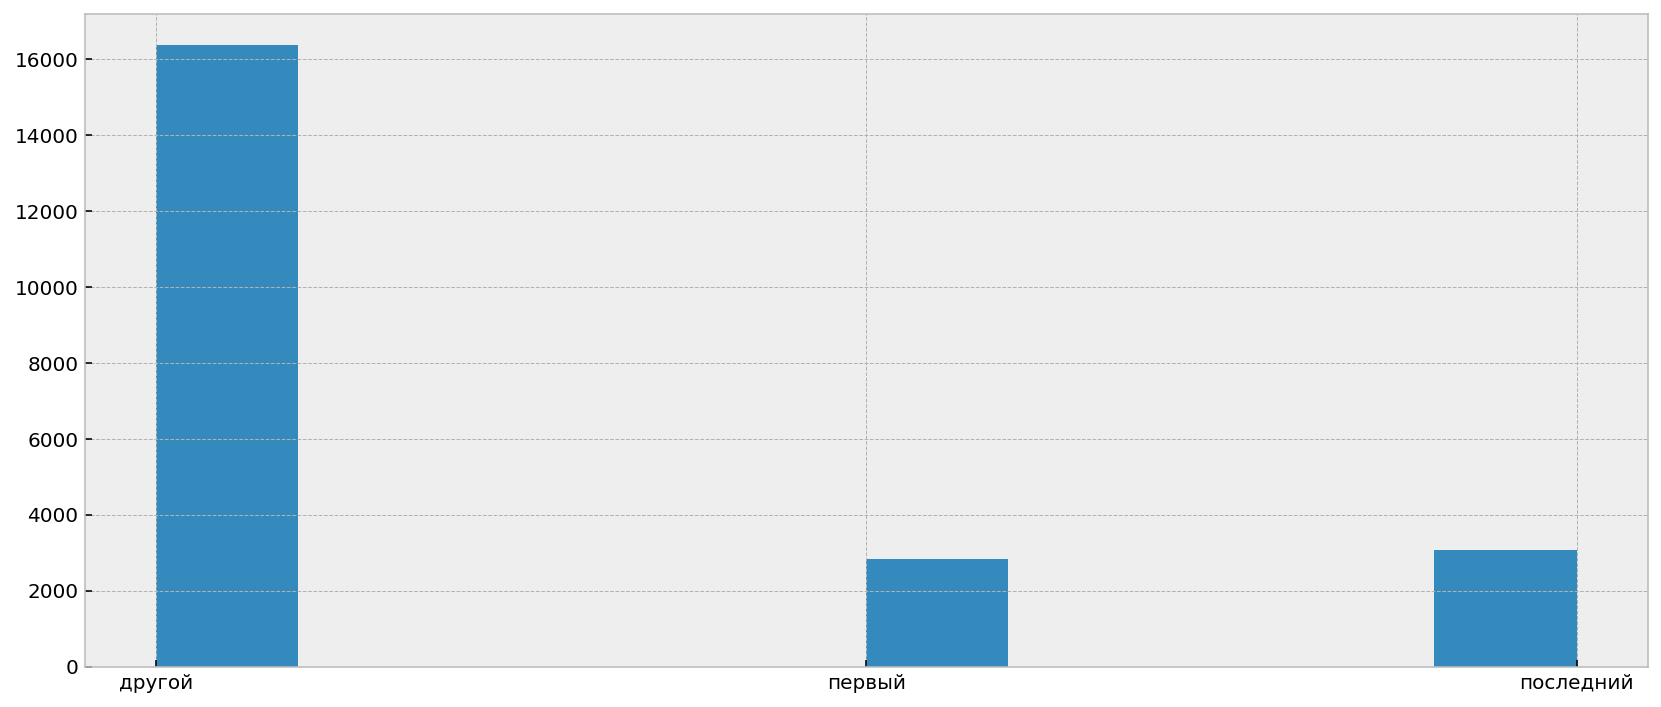

In [58]:
df_ext['floor_type'].hist() # построим гистограмму для столбца 'floor_type'

<AxesSubplot:>

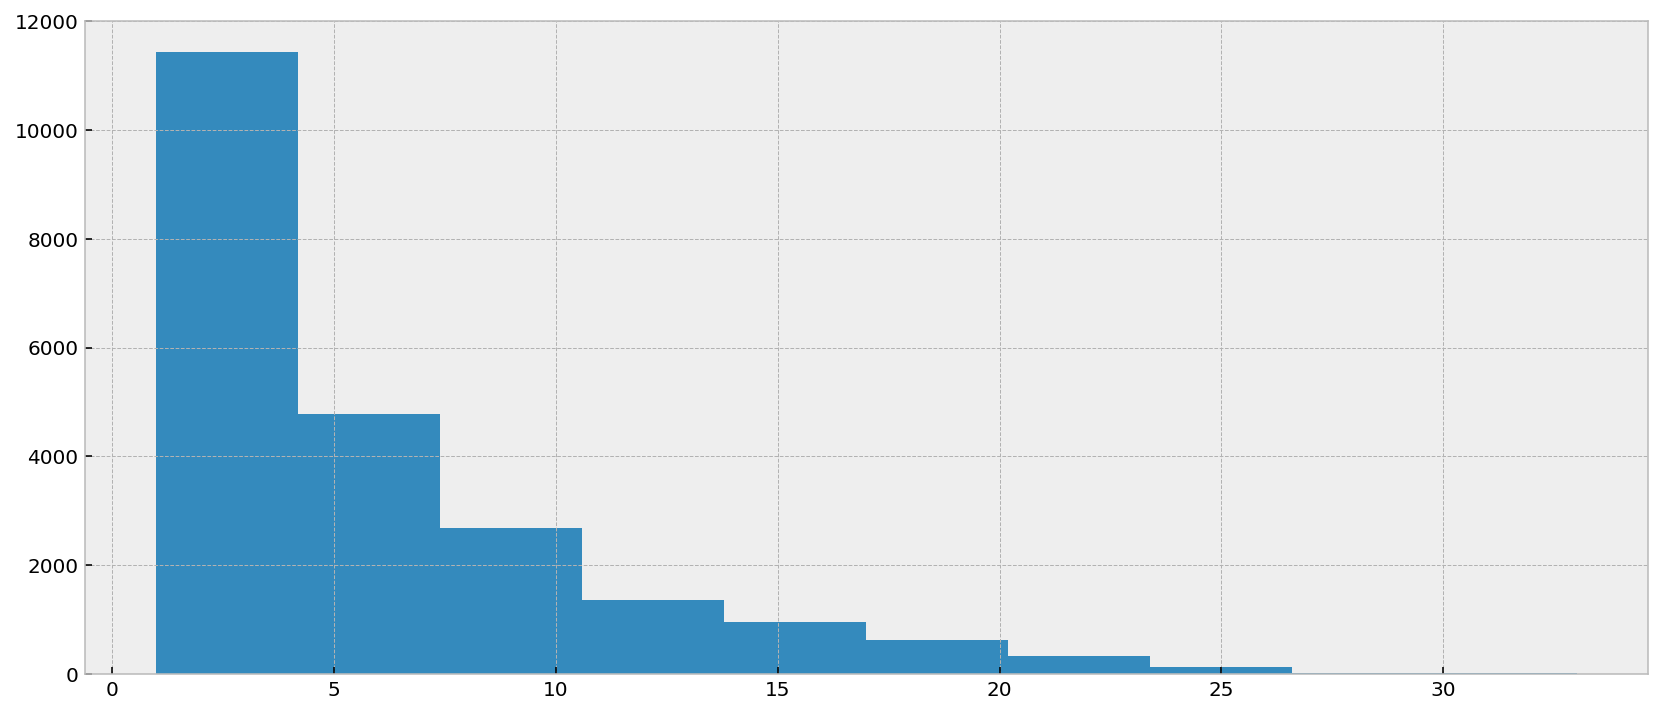

In [59]:
df_ext['floor'].hist() # построим гистограмму для столбца 'floor'

<AxesSubplot:>

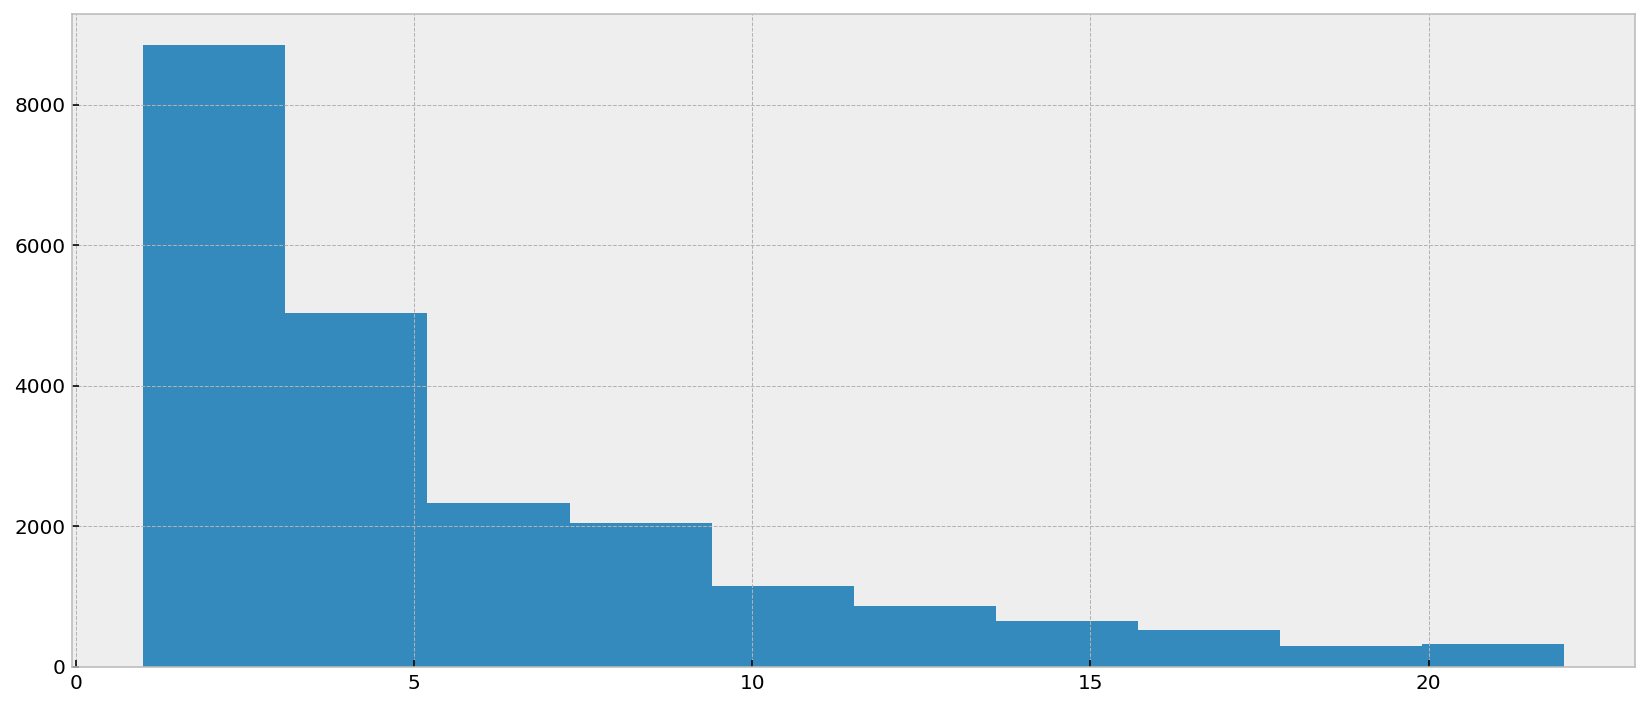

In [60]:
df_ext.loc[df_ext['floor'] <= 22]['floor'].hist() # построим гистограмму для столбца 'floor' 
# для объектов, расположенных ниже 23 этажа

<AxesSubplot:>

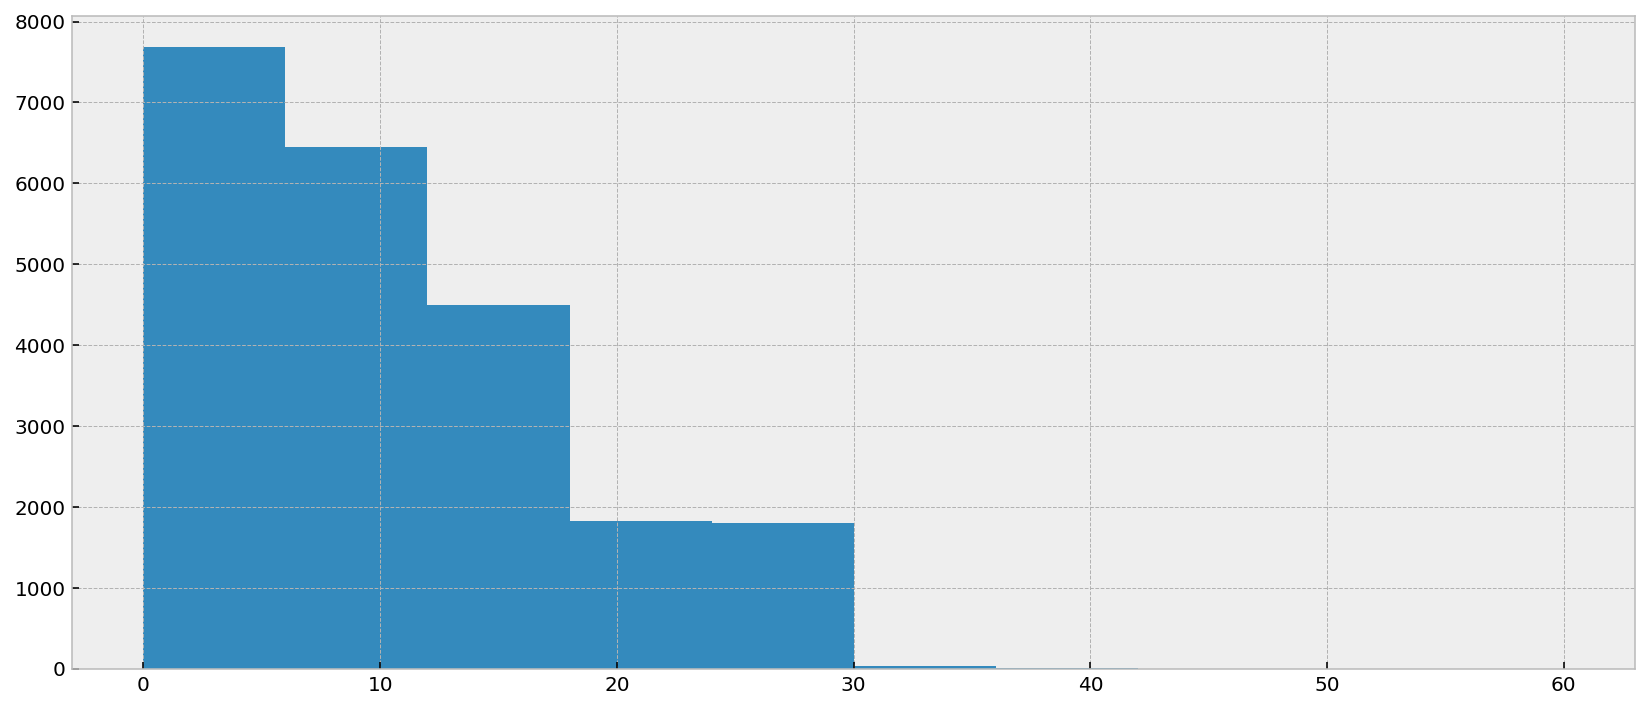

In [61]:
df_ext['floors_total'].hist() # построим гистограмму для столбца 'floors_total'
# поскольку 30 и более этажных домов не так много, построим еще одну гистограмму без них

<AxesSubplot:>

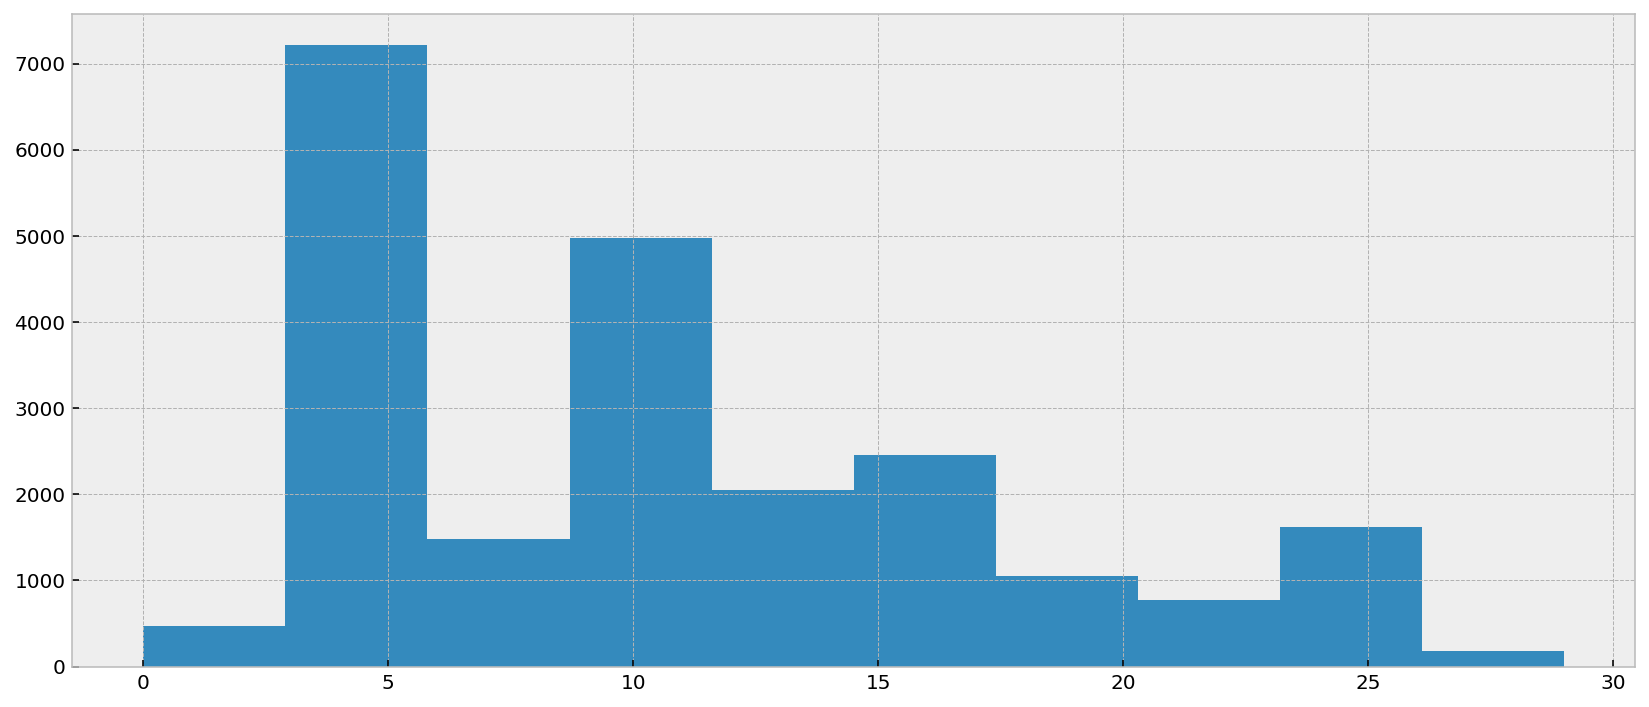

In [62]:
df_ext.loc[df_ext['floors_total'] < 30]['floors_total'].hist() # построим гистограмму_2 для столбца 'floors_total'

In [63]:
df_ext.loc[df_ext['floors_total'] == 5]['floors_total'].count()

5517

<AxesSubplot:>

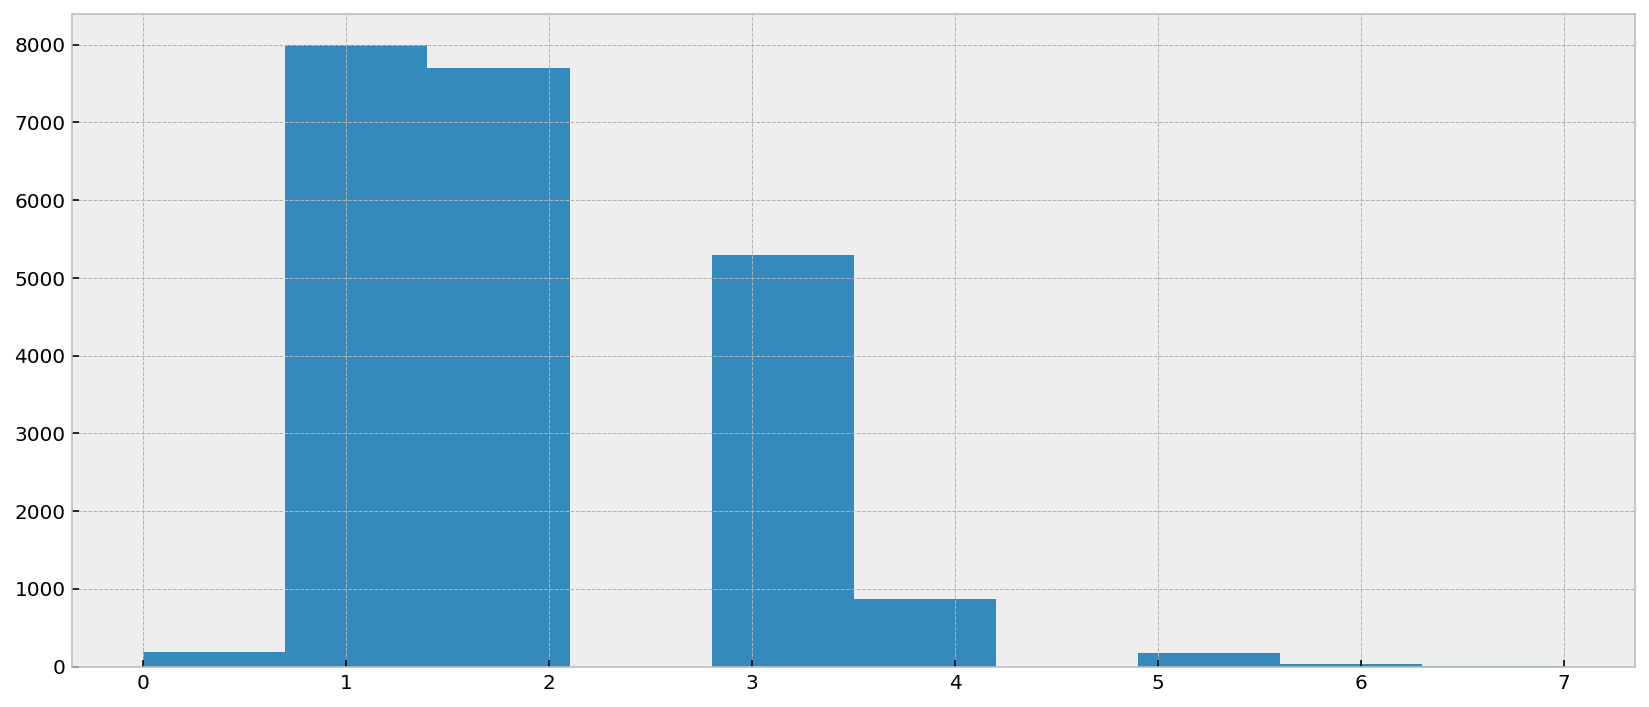

In [64]:
df_ext['rooms'].hist() # построим гистограмму для столбца 'rooms'
# поскольку квартир с 5 и более комнат не так много, построим еще одну гистограмму без них

<AxesSubplot:>

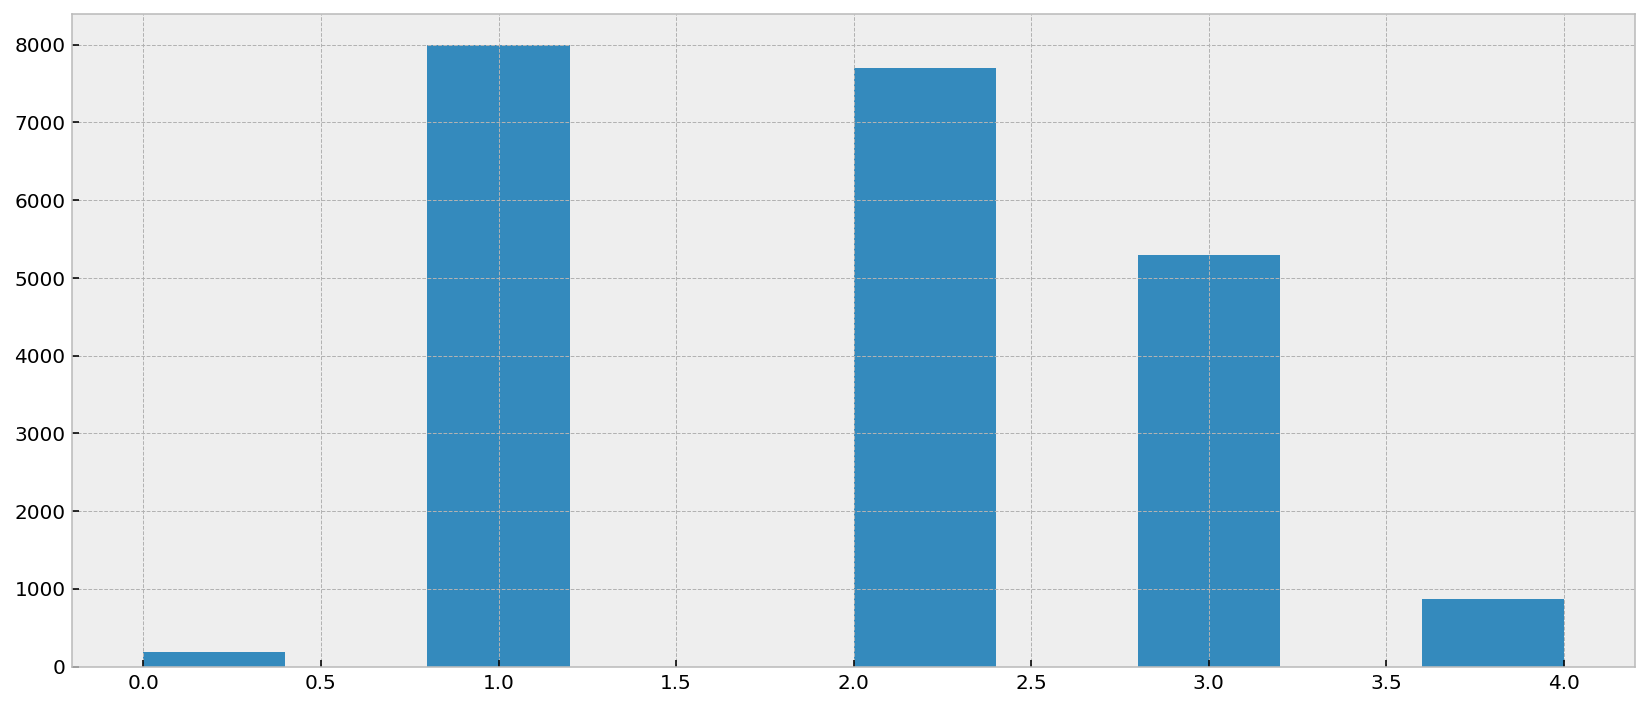

In [65]:
df_ext.loc[df_ext['rooms'] < 5]['rooms'].hist() # построим гистограмму_2 для столбца 'rooms'
# попробовать построить график через df_ext['rooms'].value_counts()

**Комментарий к полученным гистограммам**

- Большая часть объектов - более 75% - расположена на первых 8 этажах
- Около четверти объектов продается в 5-ти этажных домах
- Порядка 75% объектов - одно- и двухкомнатные квартиры

**Далее будем работать со столбцами 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'parks_around3000' и 'ponds_around3000'**

In [66]:
df_ext.isna().sum() # посмотрим, есть ли пропуски в интересующих нас столбцах

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              194
balcony                     0
locality_name               0
airports_nearest         5480
cityCenters_nearest      5465
parks_around3000         5464
parks_nearest           15139
ponds_around3000         5464
ponds_nearest           14117
days_exposition          2787
is_spb                      0
living_coeff             1742
kitchen_coeff            2123
price_of_square             0
floor_type                  0
dtype: int64

In [67]:
df_ext.loc[df_ext['airports_nearest'] == 0]['airports_nearest']
# на следующем этапе заполнения пропусков в интересующиех нас столбцах None будут измененны на "0"
# поэтому необходимо проверить а были ли в столбце 'airports_nearest' "0" до этого

21085    0.0
Name: airports_nearest, dtype: float64

**Комментарий к выводу**

- в 21085 строке в столбце 'airports_nearest' "0" был до того, как мы заполним этот столбец "0"
- этот момент надо помнить, чтобы после заполнения нулями этого столбца и последующим заполнением 'unknown' 
- не заполнить лишние строки на 'unknown' 

In [68]:
df_ext.loc[df_ext['cityCenters_nearest'] == 0]['cityCenters_nearest']
# на следующем этапе заполнения пропусков в интересующиех нас столбцах None будут измененны на "0"
# поэтому необходимо проверить а были ли в столбце 'cityCenters_nearest' "0" до этого

Series([], Name: cityCenters_nearest, dtype: float64)

In [69]:
df_ext.loc[df_ext['parks_nearest'] == 0]['parks_nearest']
# на следующем этапе заполнения пропусков в интересующиех нас столбцах None будут измененны на "0"
# поэтому необходимо проверить а были ли в столбце 'parks_nearest' "0" до этого

Series([], Name: parks_nearest, dtype: float64)

In [70]:
df_ext.loc[df_ext['ponds_nearest'] == 0]['ponds_nearest']
# на следующем этапе заполнения пропусков в интересующиех нас столбцах None будут измененны на "0"
# поэтому необходимо проверить а были ли в столбце 'ponds_nearest' "0" до этого

Series([], Name: ponds_nearest, dtype: float64)

In [71]:
df_ext['airports_nearest'] = df_ext['airports_nearest'].fillna(0)
df_ext['cityCenters_nearest'] = df_ext['cityCenters_nearest'].fillna(0)
df_ext['parks_nearest'] = df_ext['parks_nearest'].fillna(0)
df_ext['ponds_nearest'] = df_ext['ponds_nearest'].fillna(0)
# заполним пропуски в вышеупомянутых столбцах "0" для удобства дальнейшей
df_ext.isna().sum() # проверим заполнились ли пропуски

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             194
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000        5464
parks_nearest              0
ponds_around3000        5464
ponds_nearest              0
days_exposition         2787
is_spb                     0
living_coeff            1742
kitchen_coeff           2123
price_of_square            0
floor_type                 0
dtype: int64

In [72]:
df_ext['airports_nearest'] = df_ext['airports_nearest'] / 1000
df_ext['cityCenters_nearest'] = df_ext['cityCenters_nearest'] / 1000 
df_ext['parks_nearest'] = df_ext['parks_nearest'] / 1000 
df_ext['ponds_nearest'] = df_ext['ponds_nearest'] / 1000
# переведем размерность столбцов 'airports_nearest', 'cityCenters_nearest', 'parks_nearest' и 'ponds_nearest' к "км"
df_ext['airports_nearest'] = df_ext['airports_nearest'].fillna('unknown')
df_ext['cityCenters_nearest'] = df_ext['cityCenters_nearest'].fillna('unknown')
df_ext['parks_nearest'] = df_ext['parks_nearest'].fillna('unknown')
df_ext['ponds_nearest'] = df_ext['ponds_nearest'].fillna('unknown')
df_ext['ponds_around3000'] = df_ext['ponds_around3000'].fillna('unknown')
df_ext['parks_around3000'] = df_ext['parks_around3000'].fillna('unknown')
# заполним пропуски в столбцах 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 
# 'parks_around3000' и 'ponds_around3000'
df_ext.iloc[[21085]]['airports_nearest'] = df_ext.iloc[[21085]]['airports_nearest'] = 0
# вернем изначальное значение в столбец 'airports_nearest' в строке с индексом 21085, значениее "0"

/var/folders/z3/xvknb3kd1x97nxcsjr2z24xm0000gn/T/ipykernel_38168/1760623669.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext.iloc[[21085]]['airports_nearest'] = df_ext.iloc[[21085]]['airports_nearest'] = 0


In [73]:
df_ext.isna().sum() # проверим заполнились ли пропуски

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             194
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         2787
is_spb                     0
living_coeff            1742
kitchen_coeff           2123
price_of_square            0
floor_type                 0
dtype: int64

<AxesSubplot:>

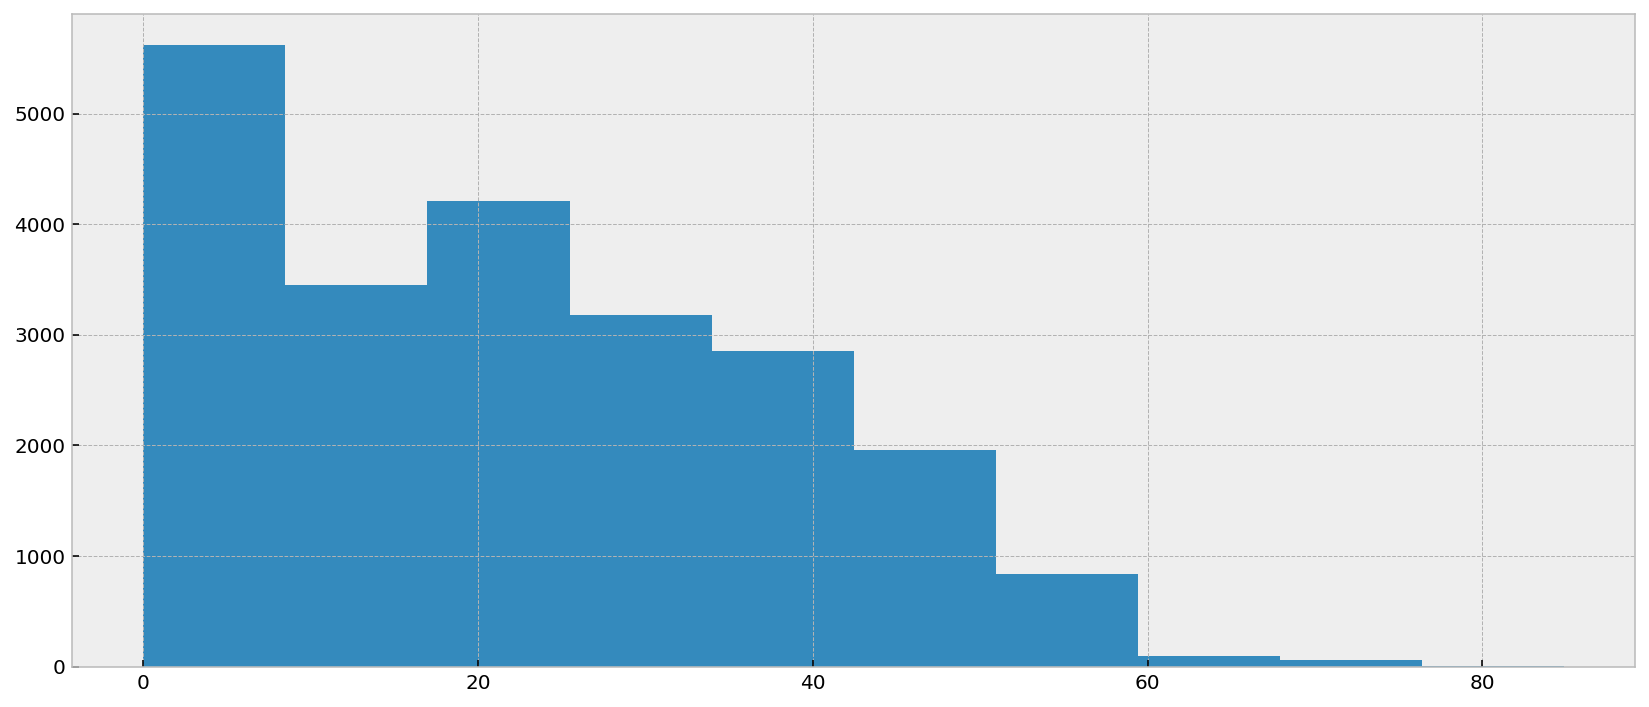

In [74]:
df_ext['airports_nearest'].hist() # построим гистограмму для столбца 'airports_nearest'

<AxesSubplot:>

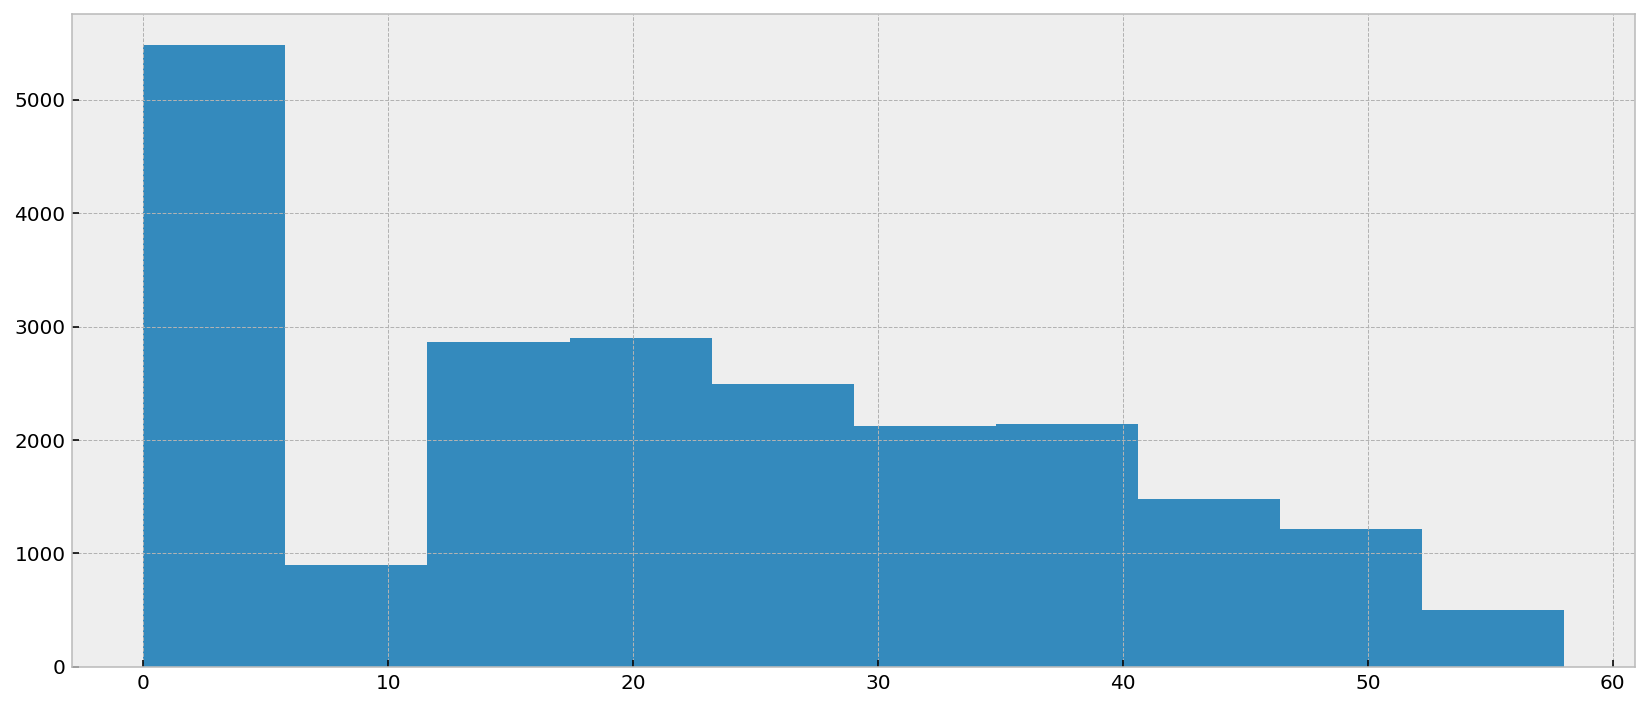

In [75]:
df_ext.loc[df_ext['airports_nearest'] < 58]['airports_nearest'].hist() # построим гистограмму_2 для столбца
# 'airports_nearest', где расстояние до аэропорта менее 58 км

<AxesSubplot:>

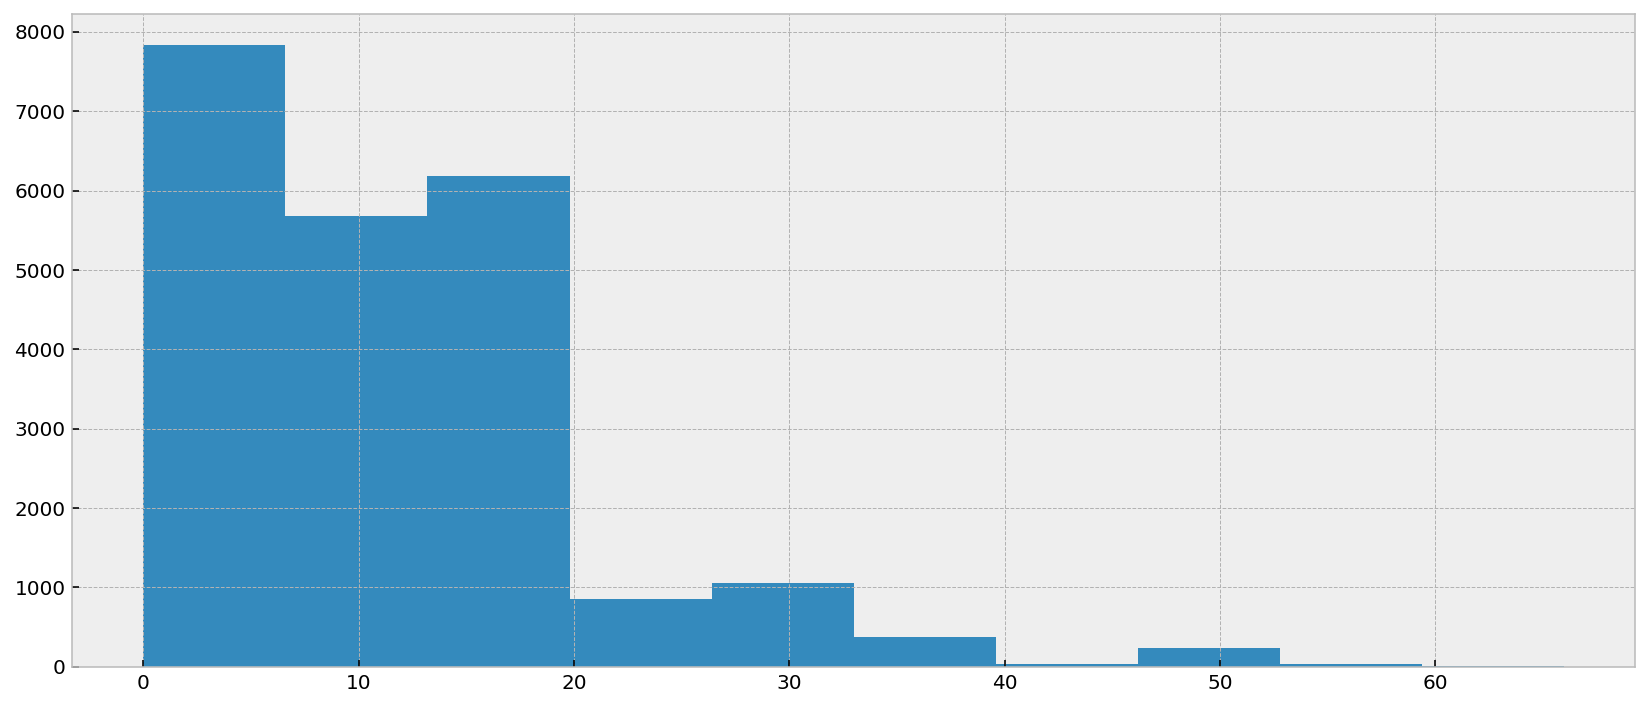

In [76]:
df_ext['cityCenters_nearest'].hist() # построим гистограмму для столбца 'airports_nearest'

<AxesSubplot:>

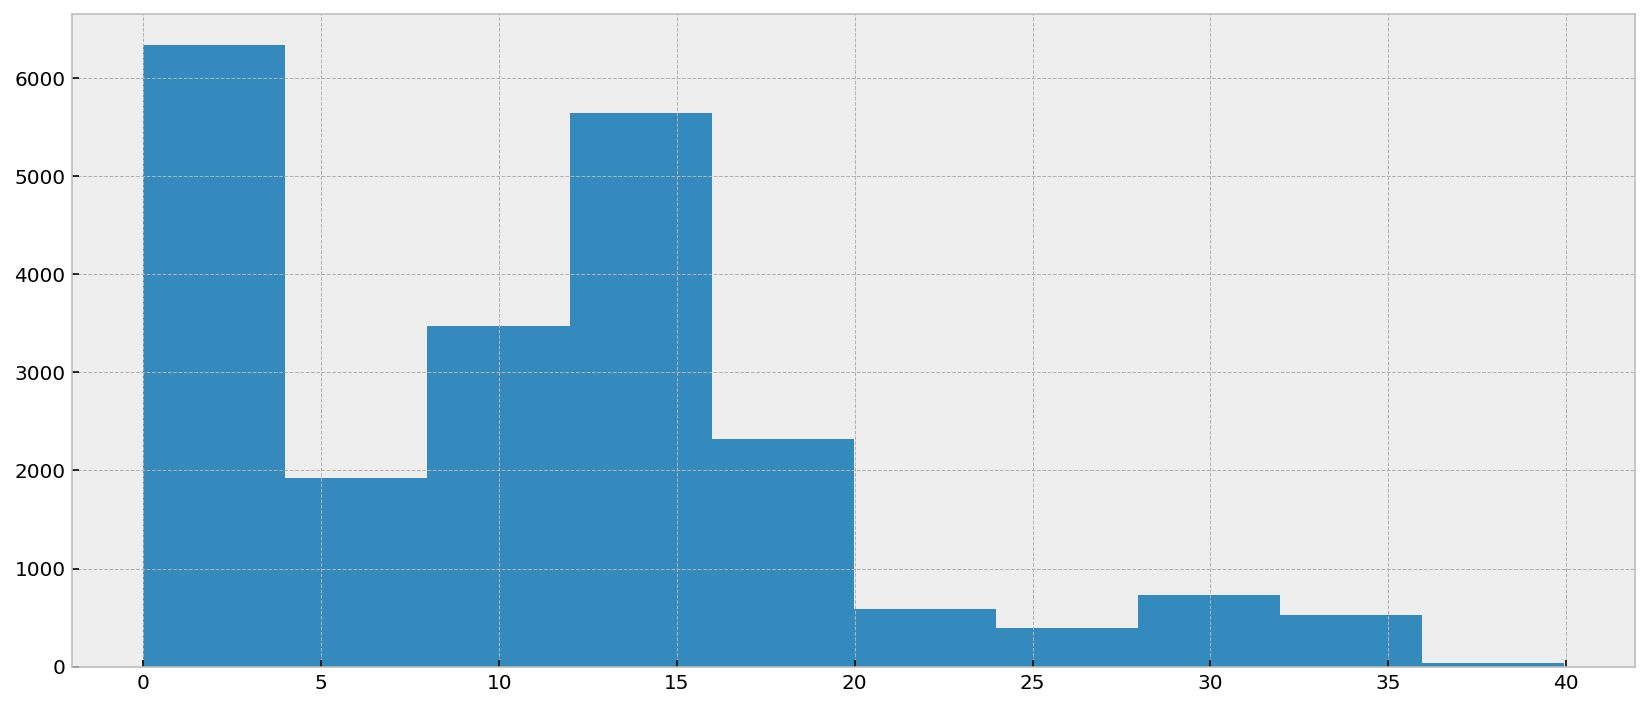

In [77]:
df_ext.loc[df_ext['cityCenters_nearest'] < 40]['cityCenters_nearest'].hist() # построим гистограмму_2 для столбца
# 'airports_nearest', где расстояние до аэропорта менее 58 км

<AxesSubplot:>

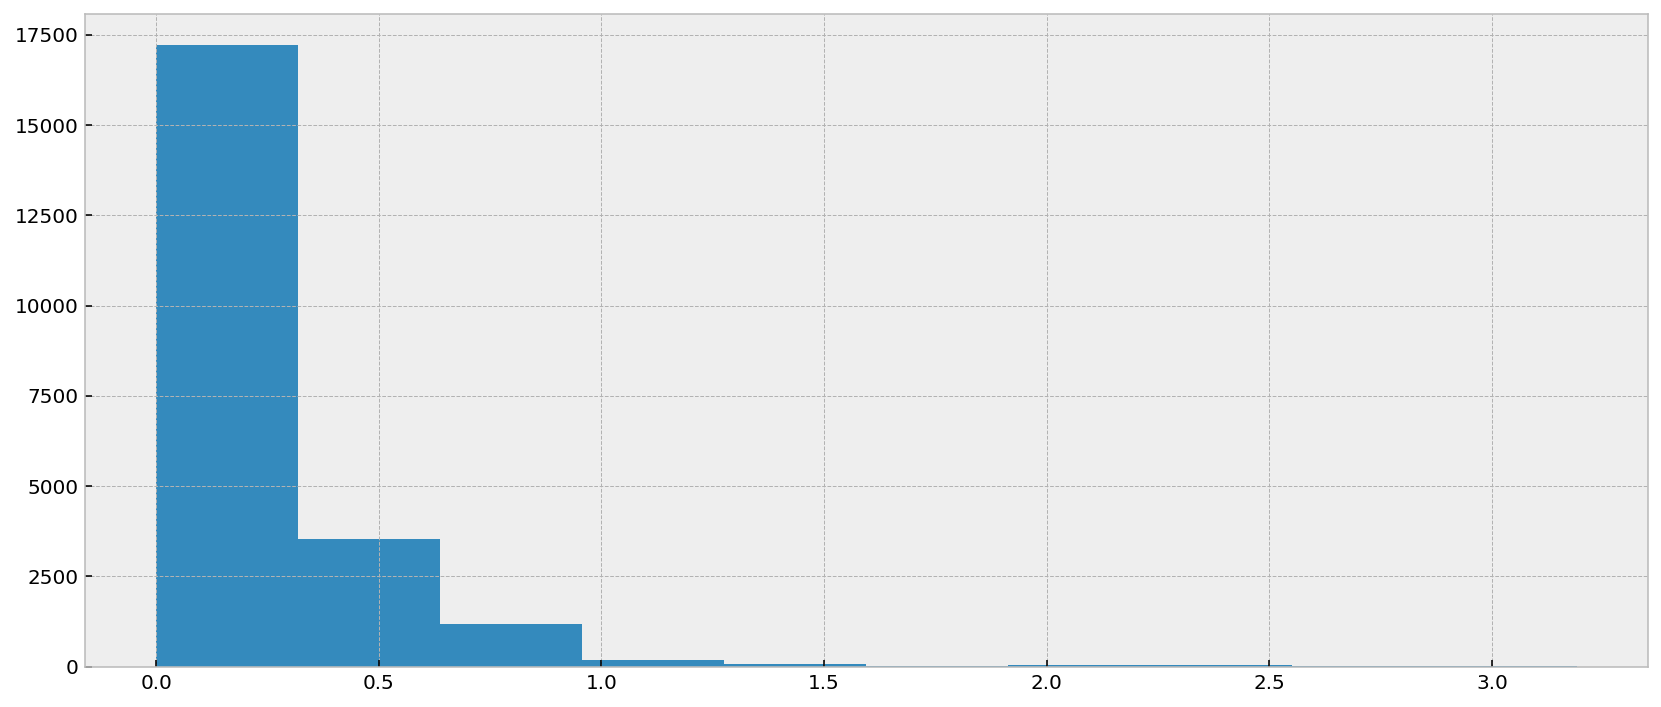

In [78]:
df_ext['parks_nearest'].hist() # построим гистограмму для столбца 'parks_nearest'

<AxesSubplot:>

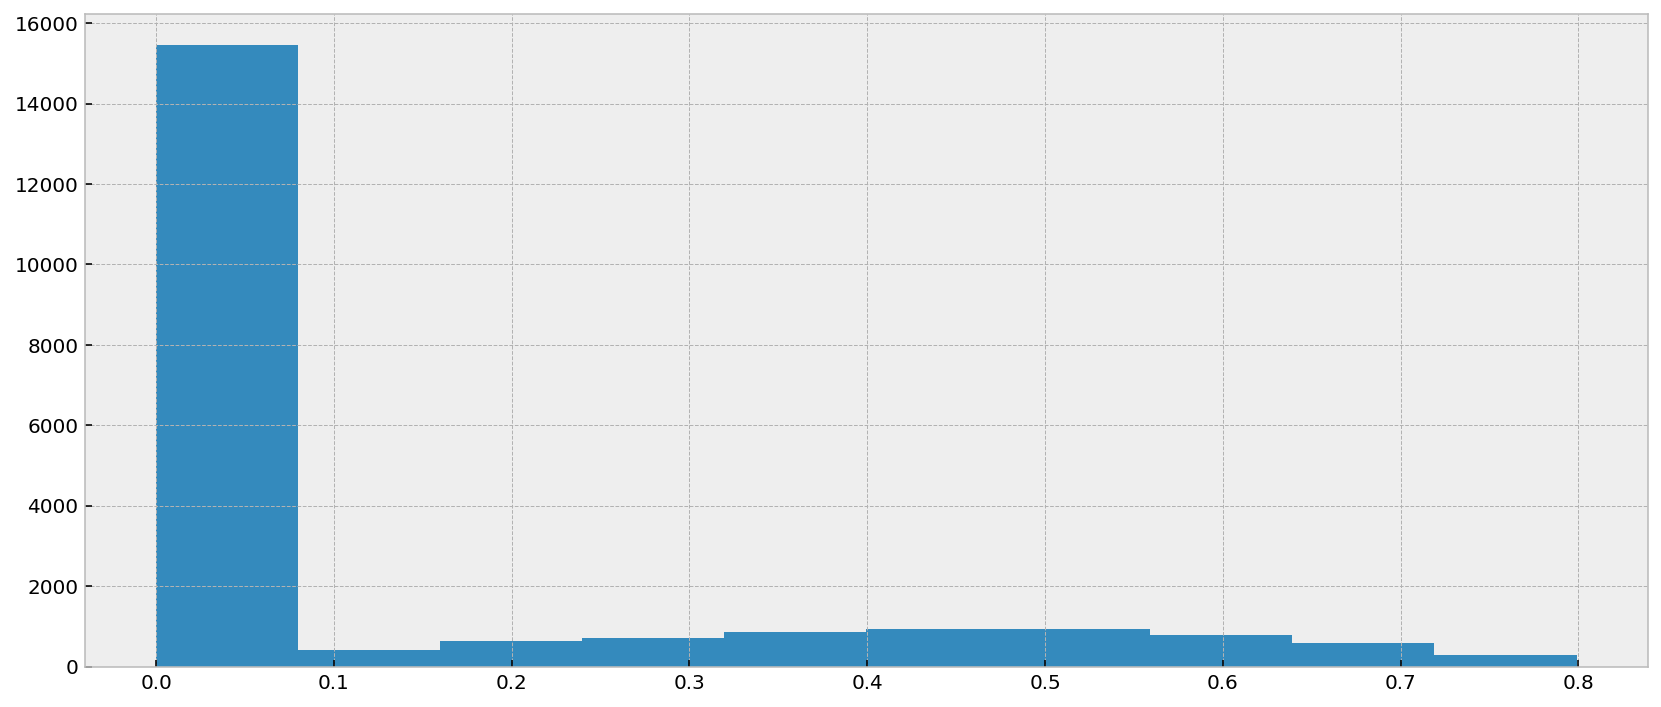

In [79]:
df_ext.loc[df_ext['parks_nearest'] < 0.8]['parks_nearest'].hist() # построим гистограмму_2 для столбца
# 'parks_nearest', где расстояние до парка менее 0.8 км

<AxesSubplot:>

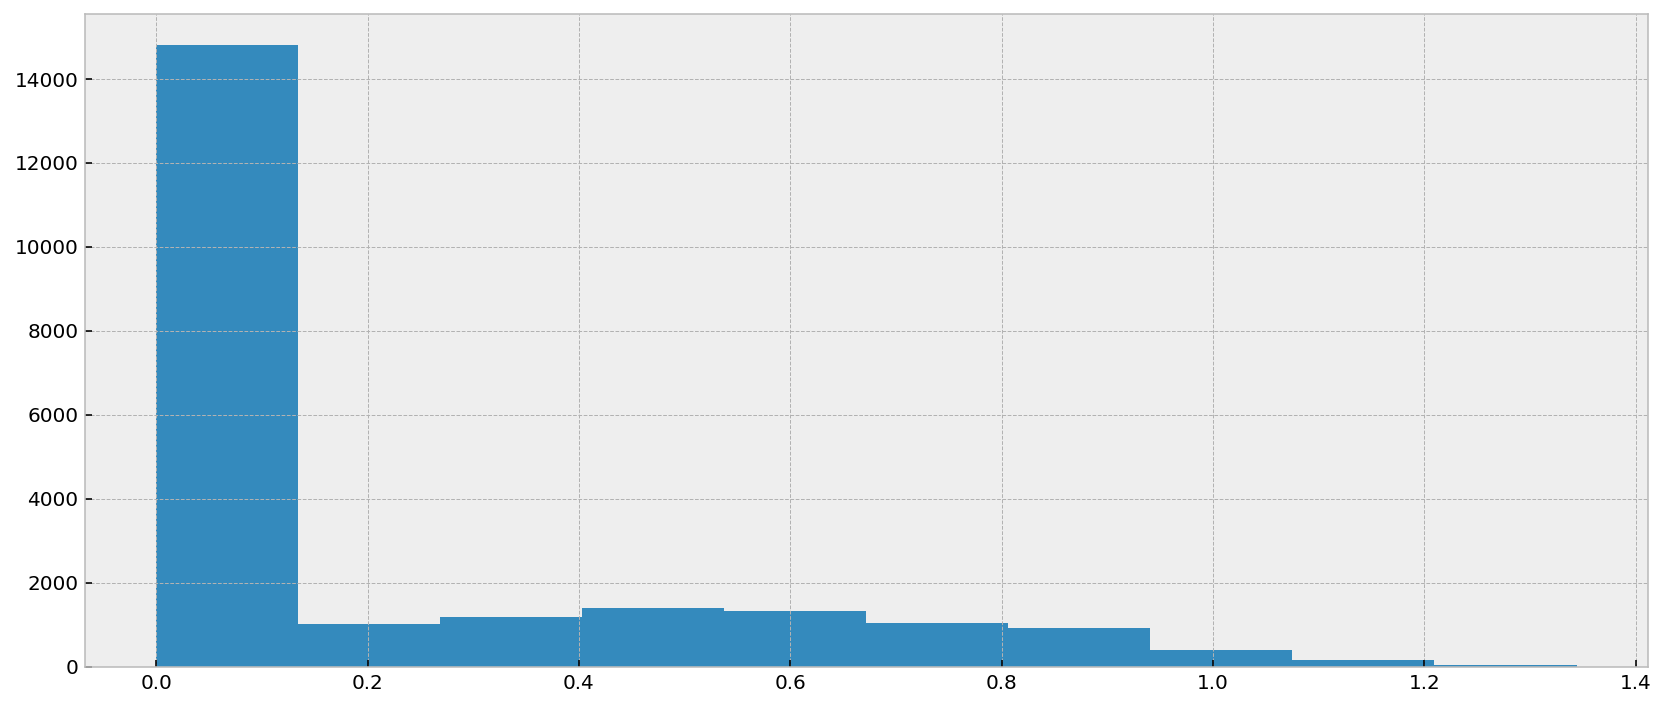

In [80]:
df_ext['ponds_nearest'].hist() # построим гистограмму для столбца 'airports_nearest'

<AxesSubplot:>

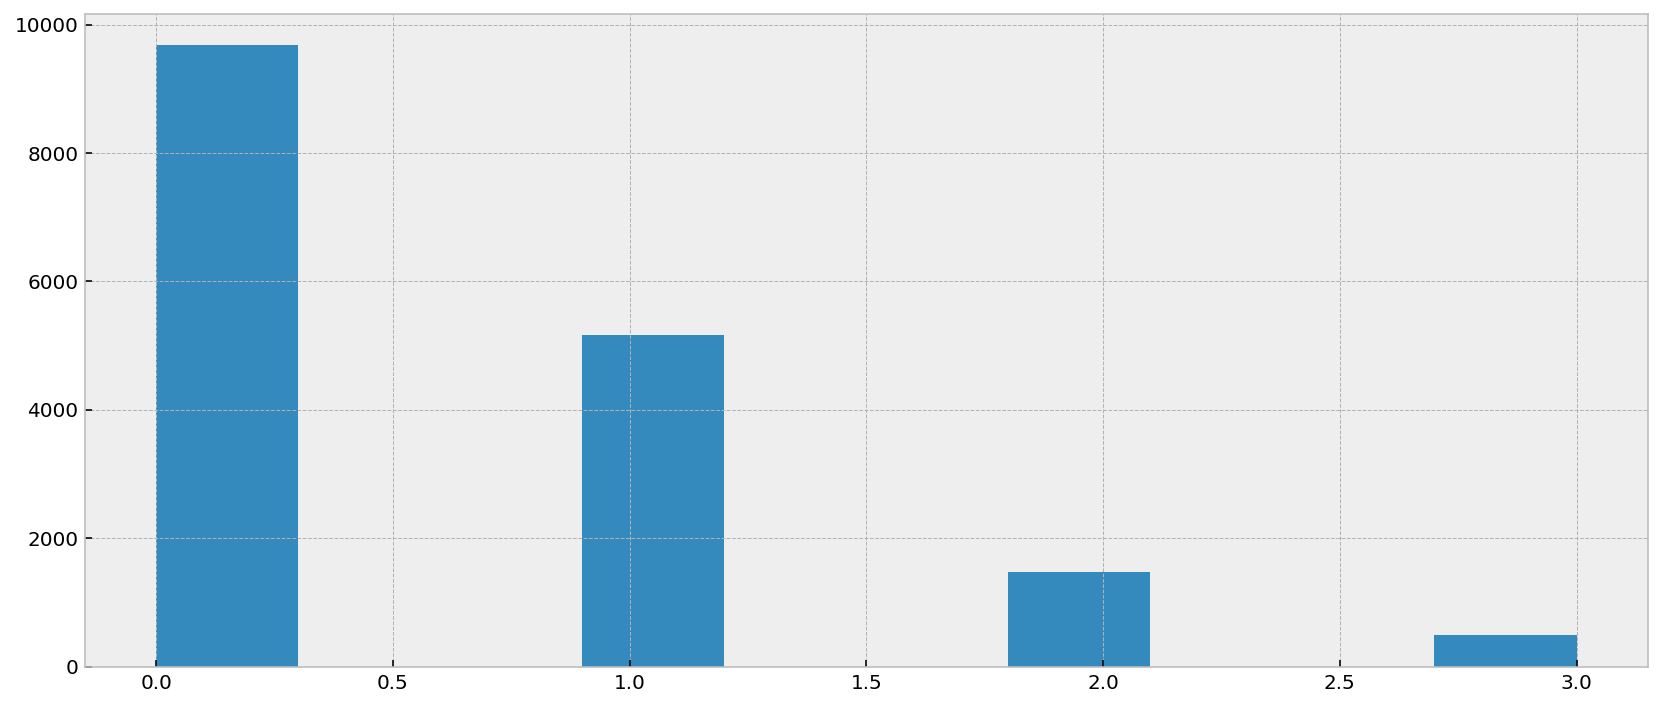

In [81]:
df_ext.loc[df_ext['parks_around3000'] != 'unknown']['parks_around3000'].hist() # построим гистограмму для столбца
# 'parks_around3000' без ячеек заполненных значением 'unknown'

<AxesSubplot:>

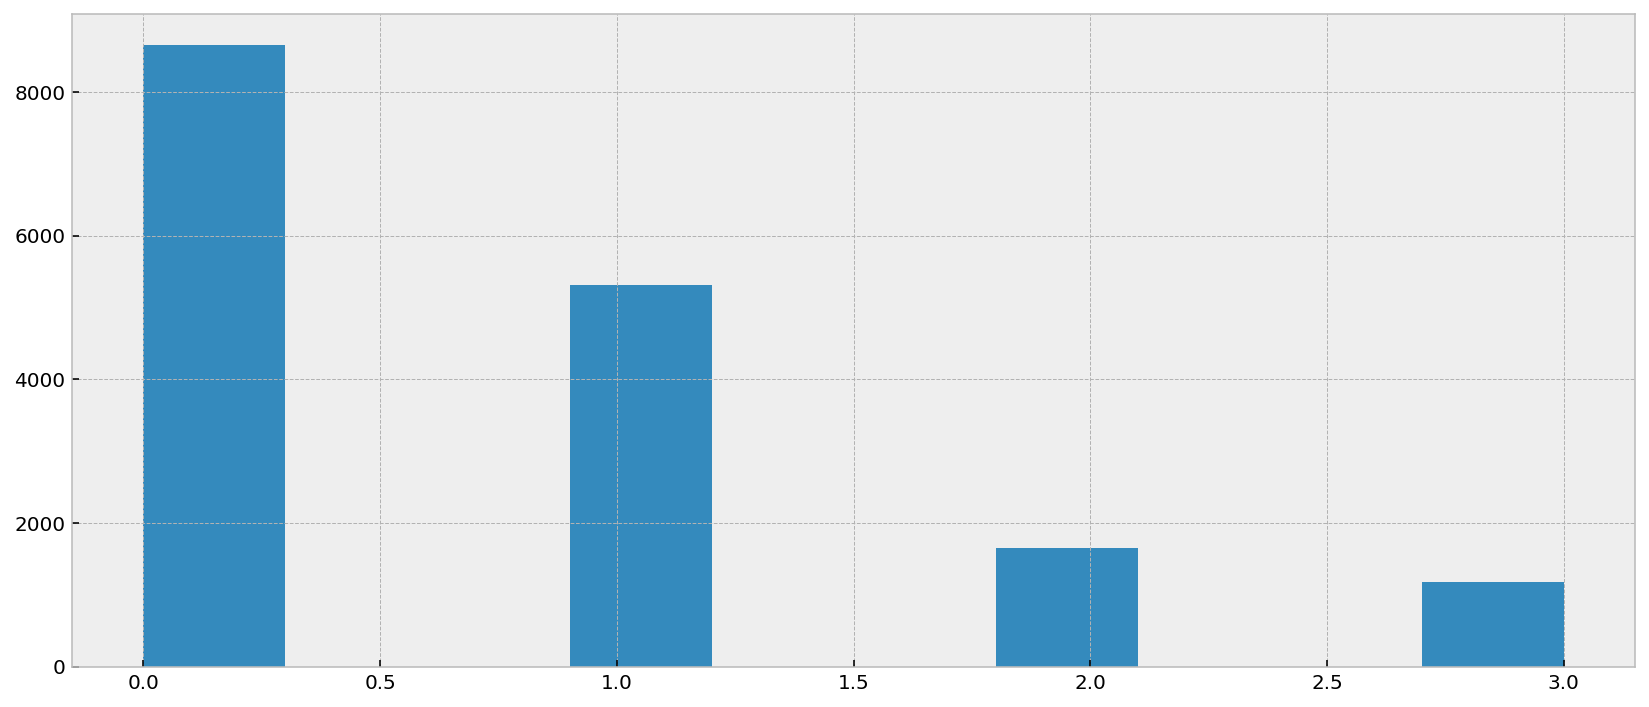

In [82]:
df_ext.loc[df_ext['ponds_around3000'] != 'unknown']['ponds_around3000'].hist() # построим гистограмму для столбца
# 'ponds_around3000' без ячеек заполненных значением 'unknown'

**Комментарий к работе со столбцами 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'parks_around3000' и 'ponds_around3000'**

- пропуски во всех столбцах заполненны 'unknown'
- размерность расстояния переведена в "км"
- построенны гистограммы для всех столбцов 

**Далее будем работать со столбцами 'first_day_exposition' и 'days_exposition'**

In [83]:
df_ext['first_day_exposition'] = df_ext['first_day_exposition'].astype('datetime64[ns]')
# изменим тип данных в столбце 'first_day_exposition', чтобы далее можно было вычислить день недели

In [84]:
df_ext['day_of_publication'] = df_ext['first_day_exposition'].dt.weekday.astype('int32')
# создаем новый столбец с днем недели, в который был опубликован лот

In [85]:
df_ext['month_of_publication'] = df_ext['first_day_exposition'].dt.month.astype('int32')
# создаем новый столбец с месяцем публикации лота

In [86]:
df_ext['year_of_publication'] = df_ext['first_day_exposition'].dt.year.astype('int32')
# создаем новый столбец с годом публикации лота

In [87]:
df_ext.info()
# проверим, что типы данных изменились

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22276 entries, 0 to 23698
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22276 non-null  int64         
 1   last_price            22276 non-null  float64       
 2   total_area            22276 non-null  float64       
 3   first_day_exposition  22276 non-null  datetime64[ns]
 4   rooms                 22276 non-null  int32         
 5   ceiling_height        22276 non-null  float64       
 6   floors_total          22276 non-null  int32         
 7   living_area           22276 non-null  float64       
 8   floor                 22276 non-null  int64         
 9   is_apartment          22276 non-null  bool          
 10  studio                22276 non-null  bool          
 11  open_plan             22276 non-null  bool          
 12  kitchen_area          22082 non-null  float64       
 13  balcony         

**Комментарий к работе со столбцами 'first_day_exposition' и 'days_exposition'**

- изменен тип данных в столбце 'first_day_exposition', чтобы далее можно было вычислить день недели
- создан новый столбец со днём недели публикации объекта (0 - понедельник, 1 - вторник и т.д.)
- создан новый столбец с месяцем публикации лота 
- создан новый столбец с годом публикации лота 
- в столбце 'days_exposition' тип данных не был изменен, поскольку в нем были пропуски, а заменять пропуски на 0 в данном случае будет некорректно и может вводить в заблуждение 


In [88]:
df_ext.isna().sum()
# выведем какие же пропуски остались в таблице

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             194
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         2787
is_spb                     0
living_coeff            1742
kitchen_coeff           2123
price_of_square            0
floor_type                 0
day_of_publication         0
month_of_publication       0
year_of_publication        0
dtype: int64

### Итоги предобработки данных

Подводя итог этапу предобработки данных, стоит отметить следующие моменты:

- из 23699 строк в исходном датафрейме осталось 22276 строк, что означает, что было удалено порядка **6% данных**, однако практически все строки с пропусками были заполнены или удалены
- пропуски остались лишь в столбцах 'kitchen_area' и 'days_exposition'
- в столбце 'kitchen_area' все **194 оставшихся пропуска** находятся в объектах-студиях, что свидетельствует о том, что данные пропуски не нужно заполнять, так как в студиях площадь кухни не выделяется
- касаемо столбца 'days_exposition' пропуски не были заполнены, поскольку это бы исказило дата фрейм, так как необходимых данных для заполнения пропущенных значений в этом столбце у нас нет
- говоря об изменении типов данных, можно перечислить следующие столбцы, в которых тип данных менялся для дальнейшей работы (построение графиков, вызов функций и т.д.): 'first_day_exposition', 'rooms', 'floors_total', 'floor'
- в столбце 'balcony' тип данных был изменен для оптимизации использования памяти, такая же операция производилась и с другими столбцами имеющими тип данных 'int32'
- были создан отдельный датафрейм - расширенная версия исходного - в который были добавлены следующие столбцы: 'is_spb', 'living_coeff', 'kitchen_coeff', 'price_of_square', 'day_of_publication', 'month_of_publication', 'year_of_publication' и 'floor_type'
- вышеперечисленные столбцы были добавлены для решения поставленных задач, а также для оптимизации кода

##  Исследовательский анализ данных

**Комментарий к полученной гистограмме**

Для начала проверим, как долго продаются квартиры на Яндекс.Недвижимости

<AxesSubplot:>

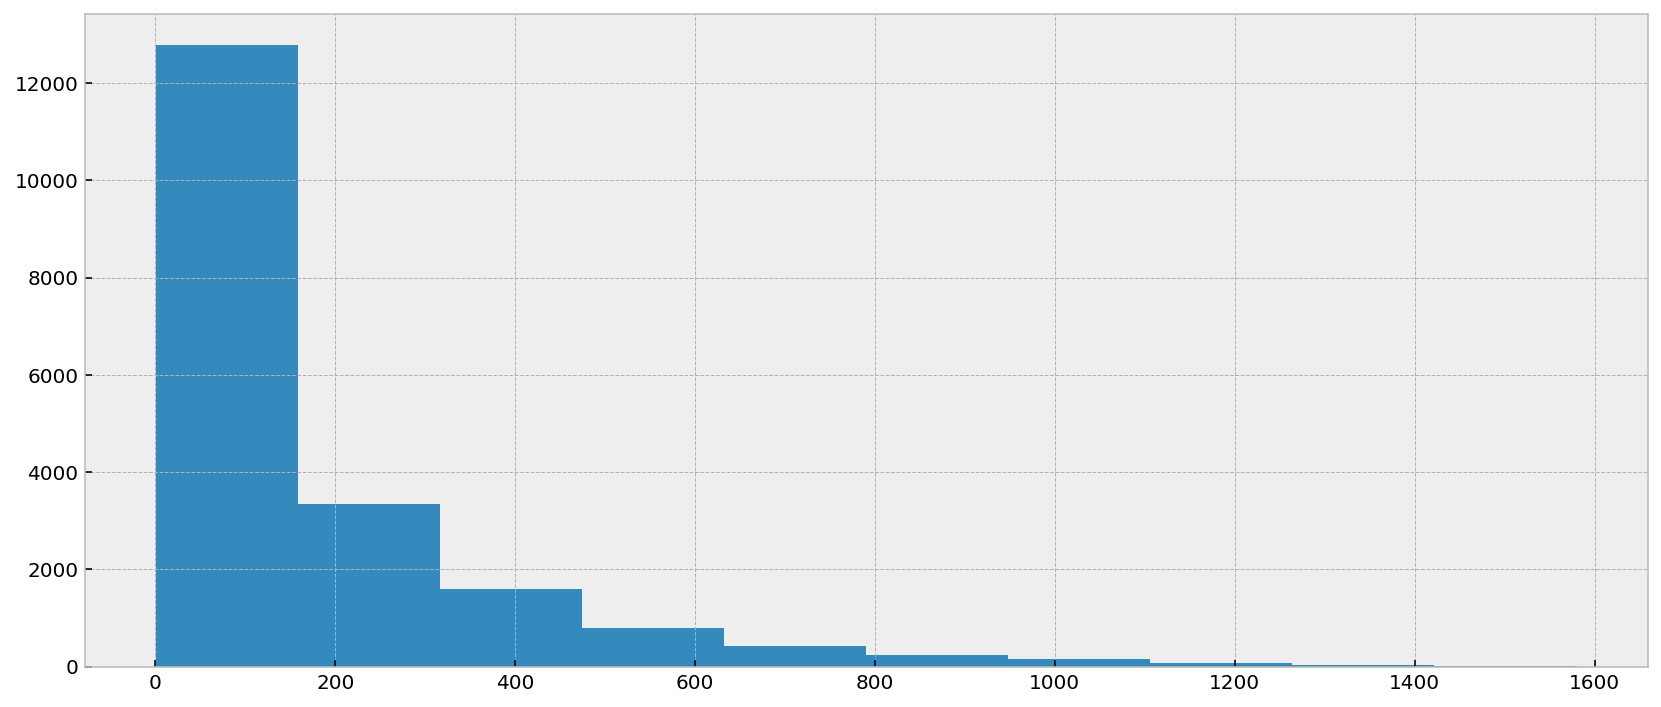

In [89]:
df_ext['days_exposition'].hist()
# построим гистограмму 

**Комментарий к полученной гистограмме**

- Объектов, продающихся более 800 дней, крайне мало, поэтому для большей наглядности построим гистограмму, не учитывая их

<AxesSubplot:>

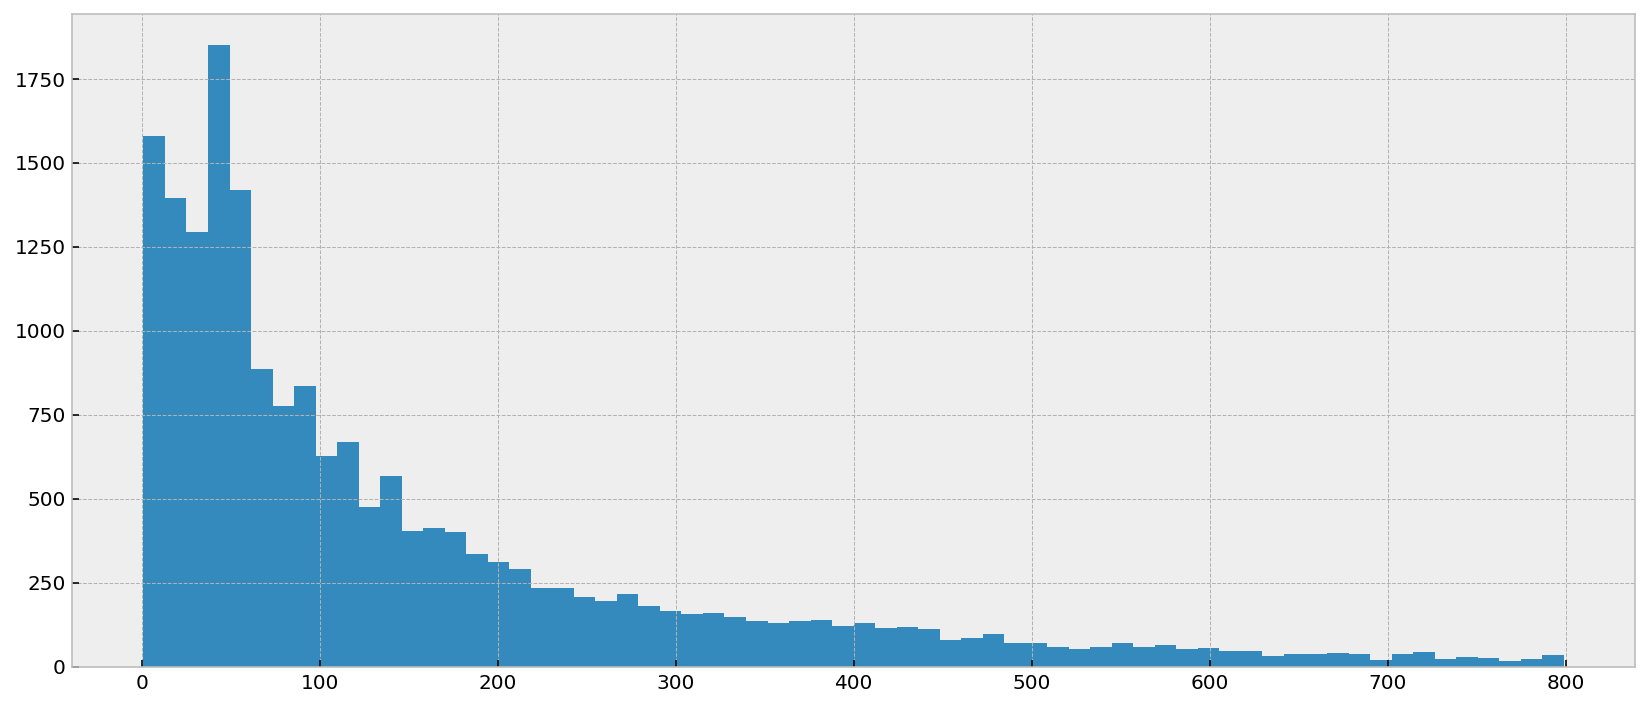

In [90]:
df_ext.loc[df_ext['days_exposition'] < 800]['days_exposition'].hist(bins='auto')
# построим гистограмму объектов продающихся менее 800 дней

In [91]:
df_ext['days_exposition'].median() # считаем медиану

92.0

In [92]:
df_ext['days_exposition'].mean() # считаем среднее

175.9215454871979

<AxesSubplot:>

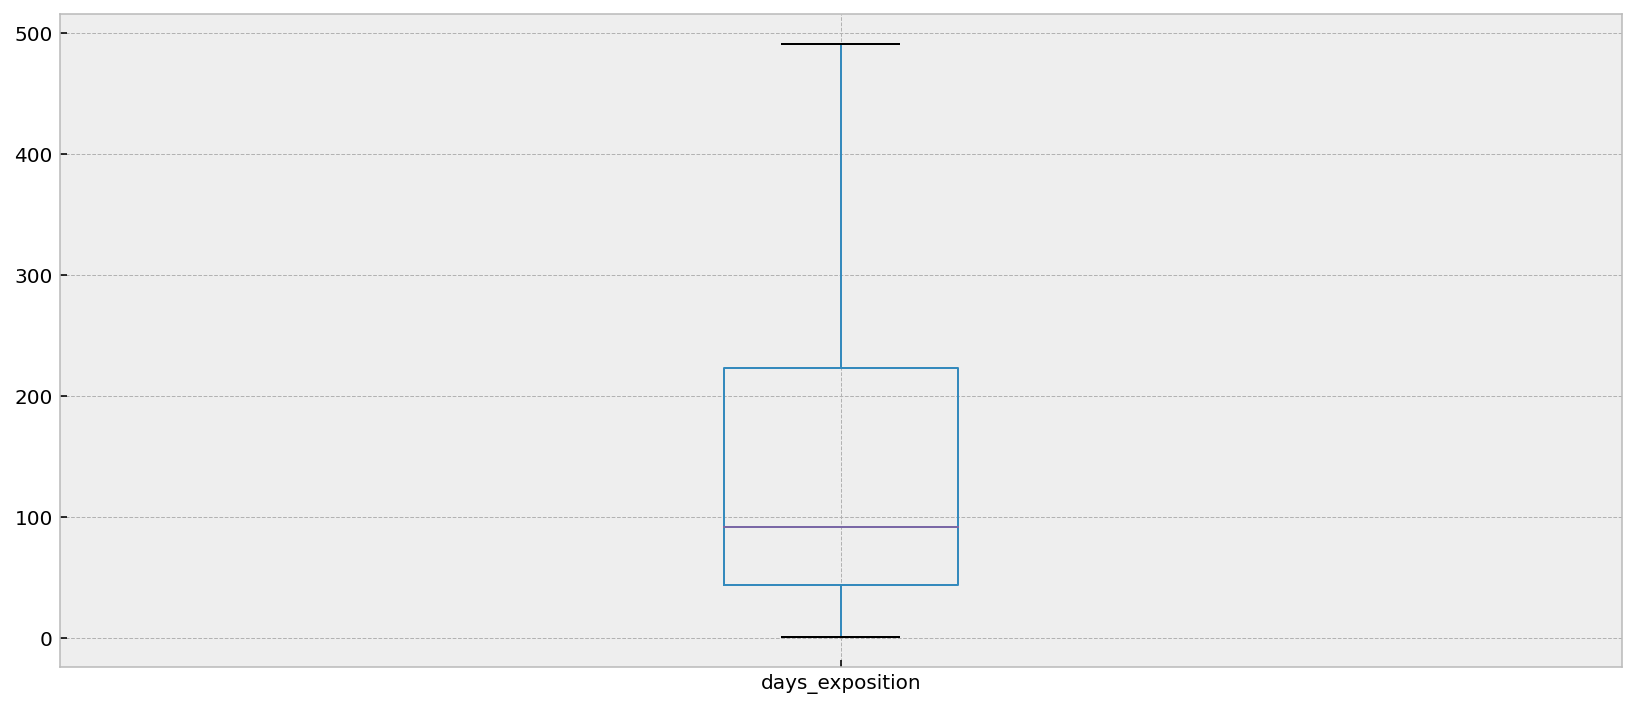

In [93]:
df_ext.boxplot('days_exposition', showfliers=False)
# определим что такое быстрая и медленная продажа

In [94]:
df_ext['days_exposition'].quantile(0.25) # определяем 25 процентиль

44.00000000000001

In [95]:
df_ext['days_exposition'].quantile(0.75) # определяем 75 процентиль

223.0

**Комментарий к полученному бокс плоту по столбцу и ко всей работе с 'days_exposition'**

- 25 процентиль (нижний квартиль) находится на отметке в 44, а 75 - в 223
- таким образом, быстрые продажи - лоты, снятые с продажи, менее чем за 44 дня, а аномально медленные - провисевшие свыше 223 дней
- медианное время продажи объекта составило 92 дня, среднее же значение - 176 дней
- а объектов, продающихся более 800 дней, крайне мало, поэтому была построена гистограмма без их учёта

**Далее изучим от каких факторов цена объекта зависит больше всего**

In [96]:
df_ext.loc[:, ['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', \
               'day_of_publication', 'month_of_publication', 'year_of_publication']].\
                corr().style.background_gradient(cmap='OrRd')
# построим матрицу корреляций для определения степени влияния разных факторов на цену объекта (столбец 'last_price')

,last_price,total_area,living_area,kitchen_area,rooms,day_of_publication,month_of_publication,year_of_publication
last_price,1.000000,0.739902,0.632875,0.529894,0.490035,-0.016011,0.001579,-0.013730
total_area,0.739902,1.000000,0.925493,0.490593,0.799915,-0.011554,0.003936,-0.071678
living_area,0.632875,0.925493,1.000000,0.244650,0.879585,-0.005571,-0.001483,-0.061198
kitchen_area,0.529894,0.490593,0.244650,1.000000,0.111756,-0.009978,0.014518,-0.044805
rooms,0.490035,0.799915,0.879585,0.111756,1.000000,-0.002516,-0.004583,-0.043328
day_of_publication,-0.016011,-0.011554,-0.005571,-0.009978,-0.002516,1.000000,0.013249,-0.001807
month_of_publication,0.001579,0.003936,-0.001483,0.014518,-0.004583,0.013249,1.000000,-0.269563
year_of_publication,-0.013730,-0.071678,-0.061198,-0.044805,-0.043328,-0.001807,-0.269563,1.000000


**Комментарий к полученной матрице корреляций**

- цена объекта прежде всего зависит от его площади, что было ожидаемо

**Далее построим графики для каждого из вышеупомянутых факторов и посмотрим их влияние на цену объекта**

<AxesSubplot:title={'center':'Зависимость цены квартиры от ее площади'}, xlabel='площадь объекта', ylabel='цена'>

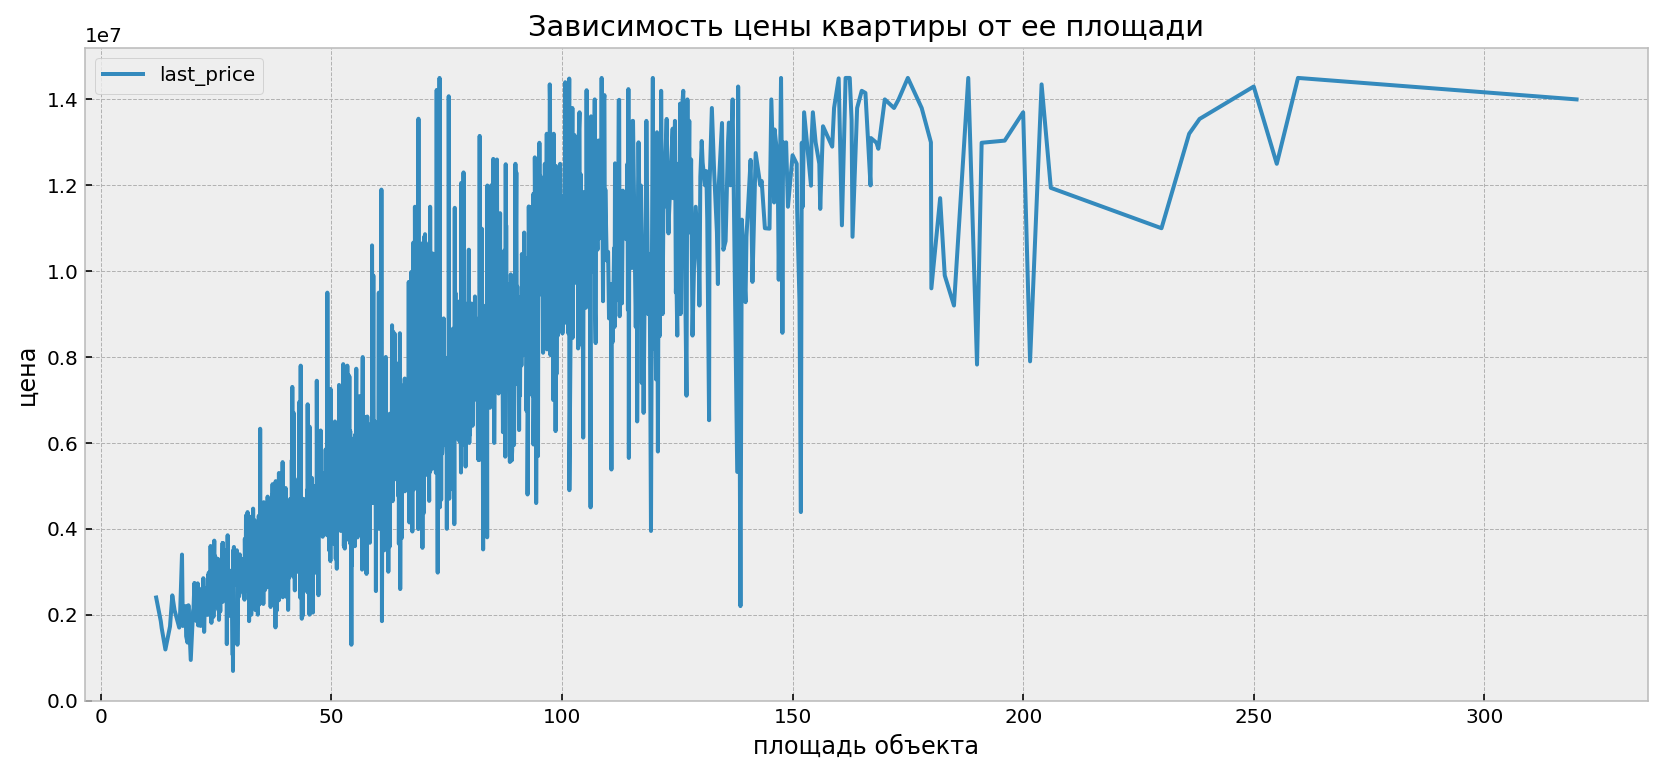

In [97]:
df_ext.pivot_table(index='total_area', values='last_price', aggfunc='median'). \
plot(grid=True, xlabel='площадь объекта', ylabel=('цена'), title='Зависимость цены квартиры от ее площади')
# строим график зависимости цены объекта от его площади 

**Комментарий к полученному графику**

- большинство объектов имеют общую площадь менее 175 квадратных метров, поэтому построим еще один график и посмотрим, как объекта прежде всего зависит от его площади, что было ожидаемо.

<AxesSubplot:title={'center':'Зависимость цены квартиры от ее площади'}, xlabel='площадь объекта', ylabel='цена'>

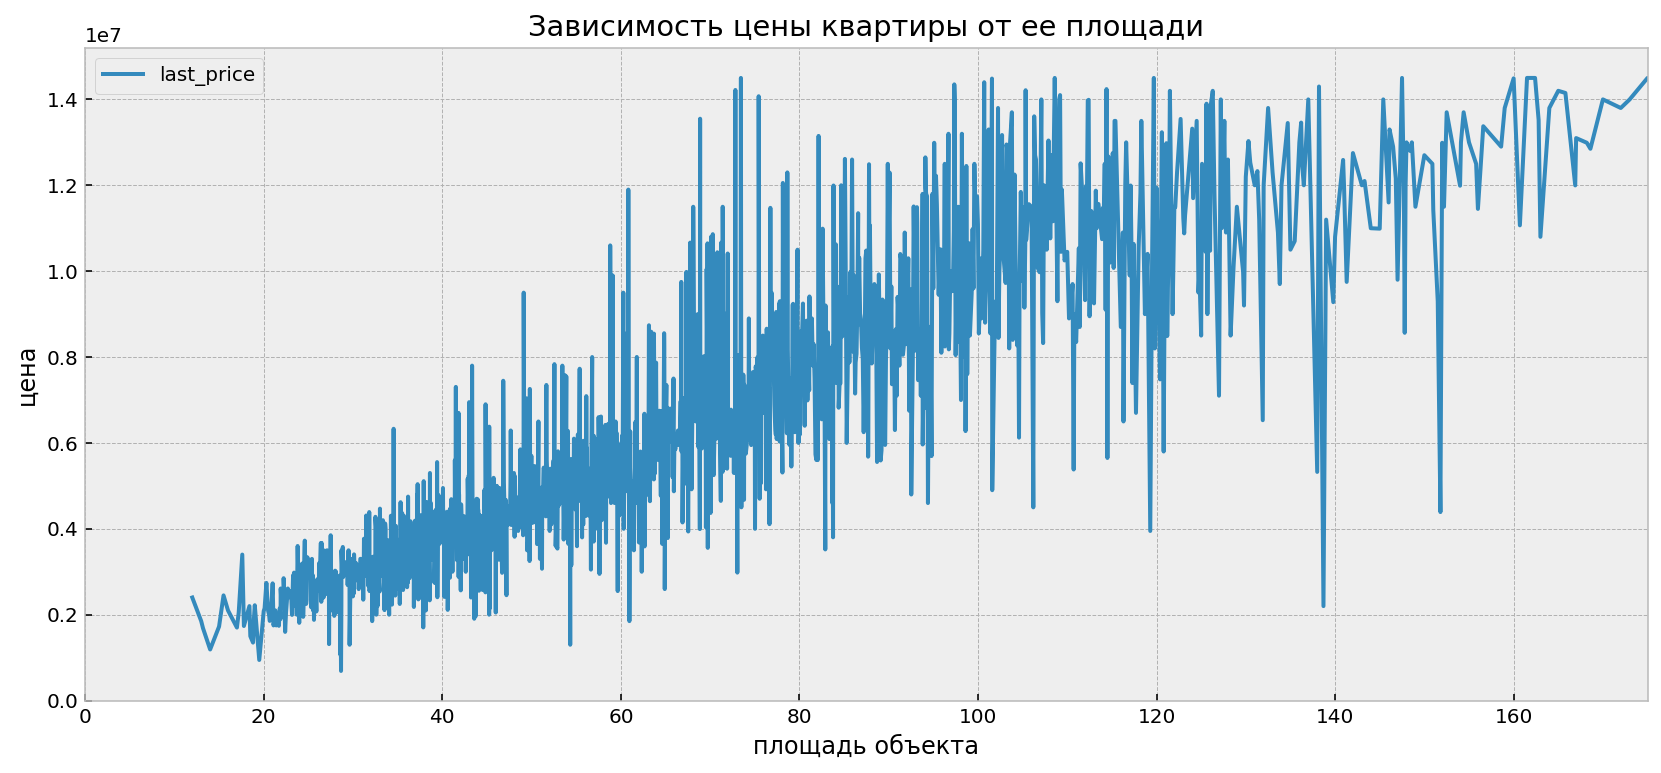

In [98]:
df_ext.pivot_table(index='total_area', values='last_price', aggfunc='median'). \
plot(grid=True, xlabel='площадь объекта', ylabel='цена', xlim=(0, 175), \
     title='Зависимость цены квартиры от ее площади')
# строим график зависимости цены объектов, площадь которых менее 175 квадратных метров, от общей площади

<AxesSubplot:title={'center':'Зависимость цены квартиры от ее жилой площади'}, xlabel='общая жилая площадь', ylabel='цена'>

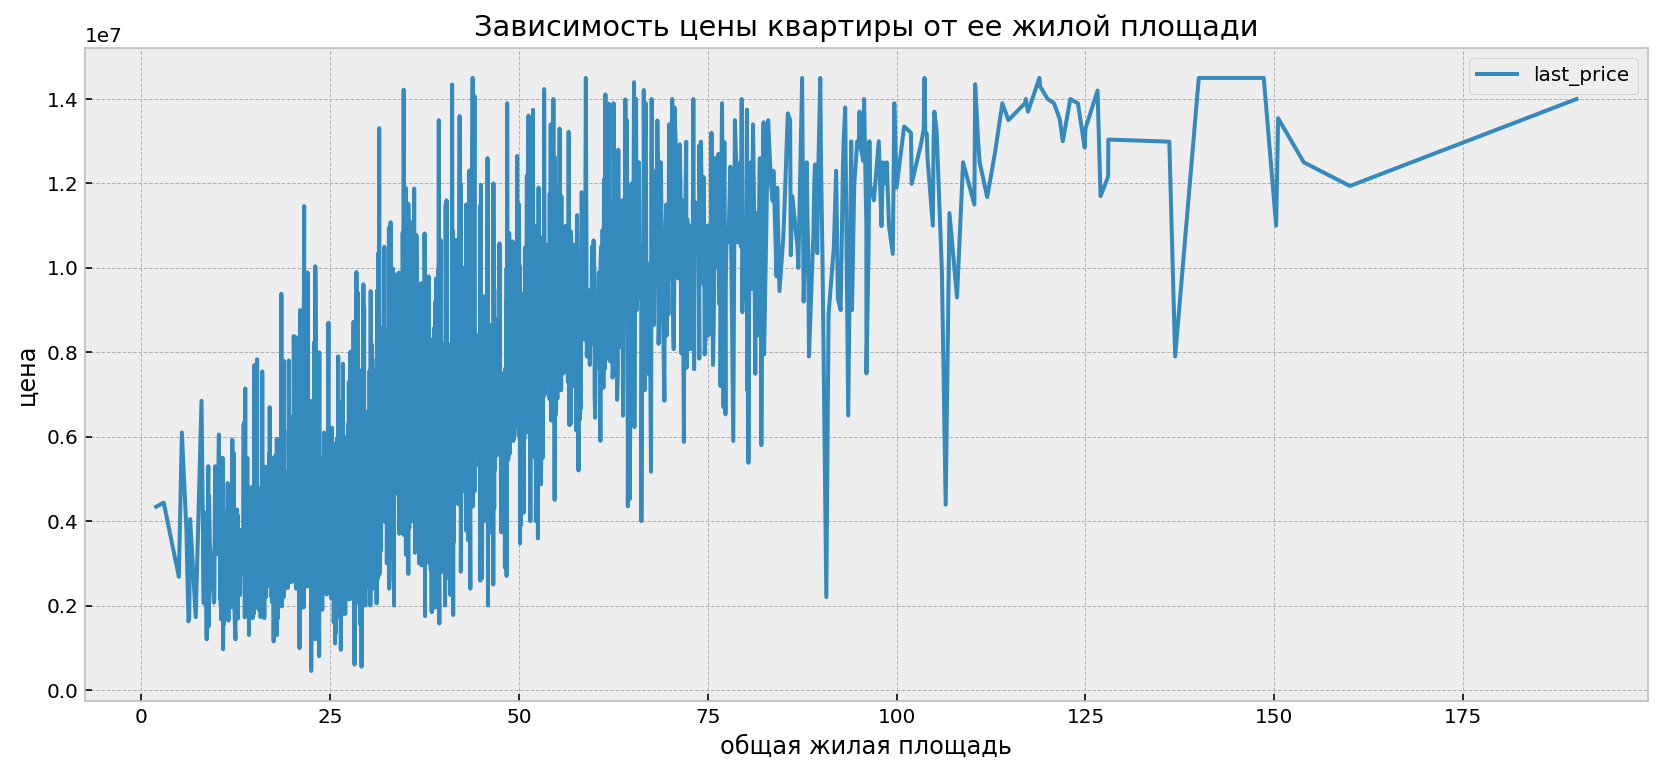

In [99]:
df_ext.pivot_table(index='living_area', values='last_price', aggfunc='median').\
plot(xlabel='общая жилая площадь', ylabel='цена', \
     title='Зависимость цены квартиры от ее жилой площади')
# строим график зависимости цены объекта от общей жилой площади

<AxesSubplot:title={'center':'Зависимость цены квартиры от площади кухни в ней'}, xlabel='площадь кухни', ylabel='цена'>

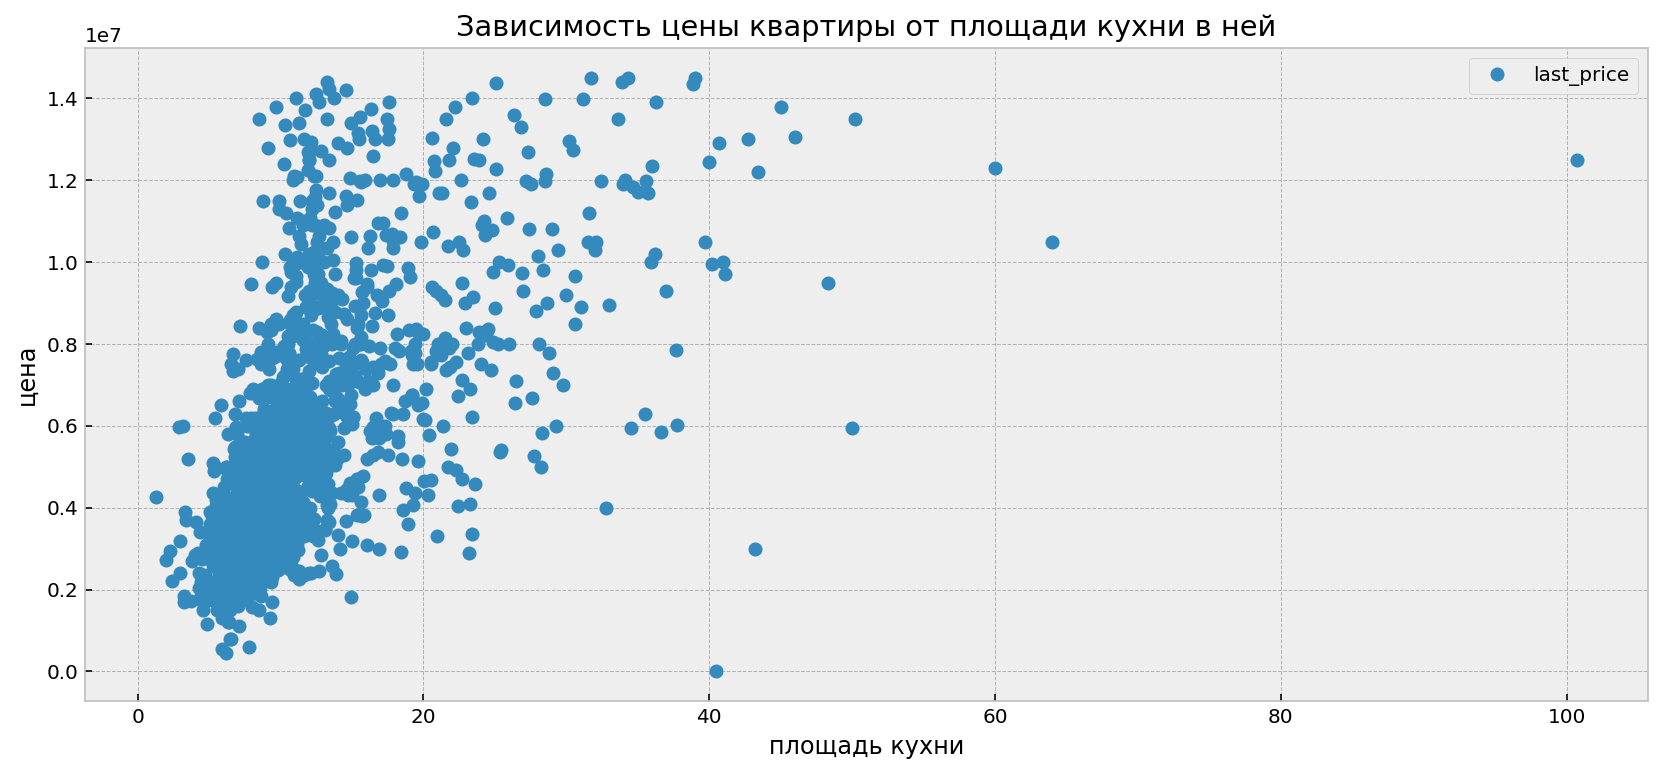

In [100]:
df_ext.pivot_table(index='kitchen_area', values='last_price', aggfunc='median'). \
plot(grid=True, style='o', xlabel='площадь кухни', ylabel='цена', title ='Зависимость цены квартиры от площади кухни в ней')
# строим график зависимости цены объекта от площади кухни

**Комментарий к полученному графику**

- площадь кухни у большинства объектов менее 40 кв. метров, поэтому стоит посмотреть на такой график

<AxesSubplot:title={'center':'Зависимость цены квартиры от площади кухни в ней'}, xlabel='площадь кухни', ylabel='цена'>

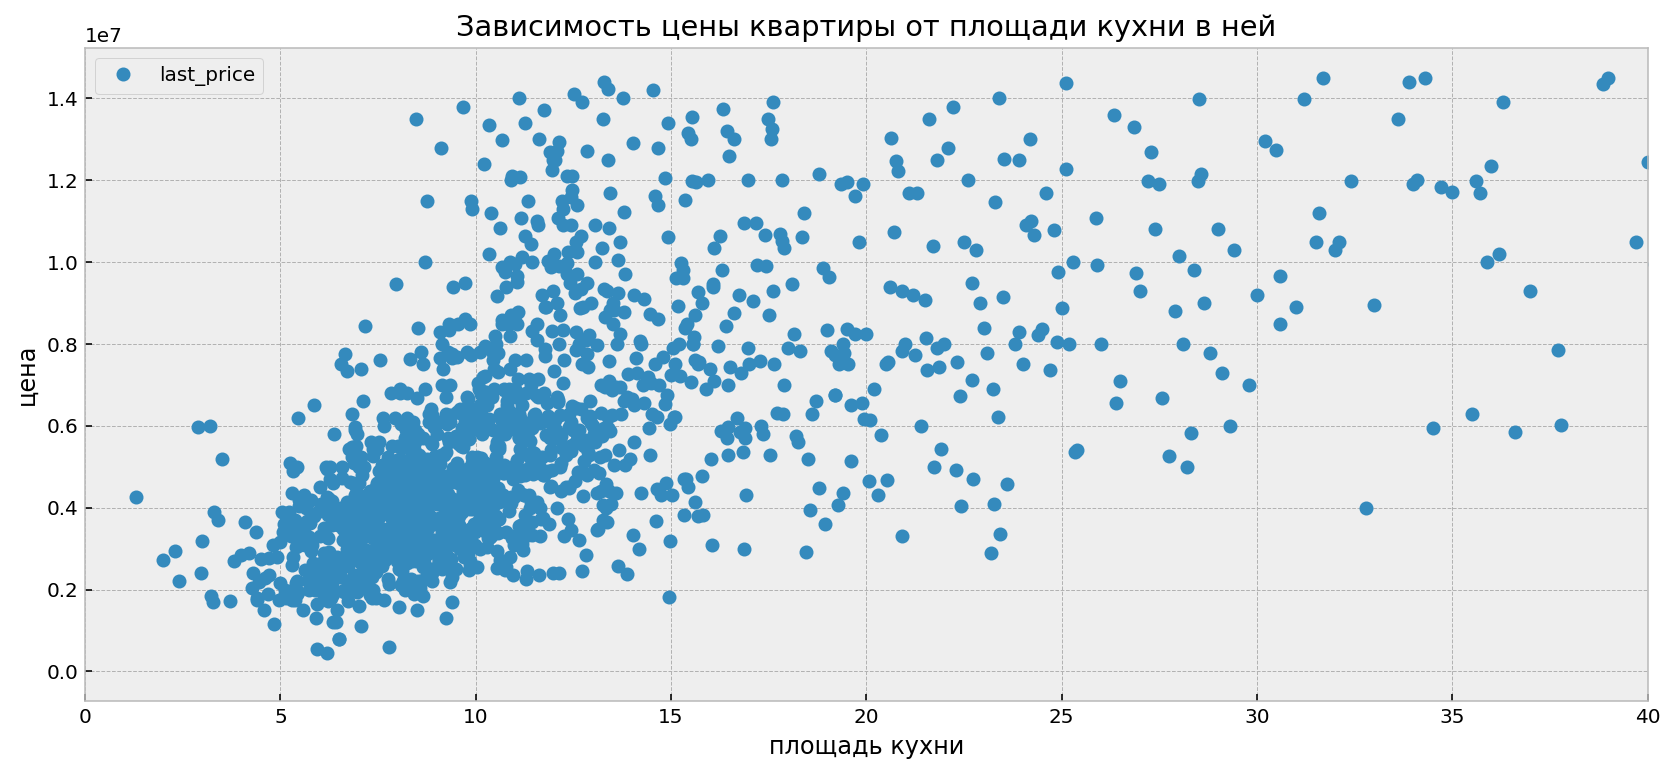

In [101]:
df_ext.pivot_table(index='kitchen_area', values='last_price', aggfunc='median'). \
plot(grid=True, style='o', xlabel='площадь кухни', ylabel='цена', xlim=(0, 40), \
     title ='Зависимость цены квартиры от площади кухни в ней')
# строим график зависимости цены объекта от площади кухни (площадь кухни менее 40 метров кв.)

<AxesSubplot:xlabel='количество комнат', ylabel='цена'>

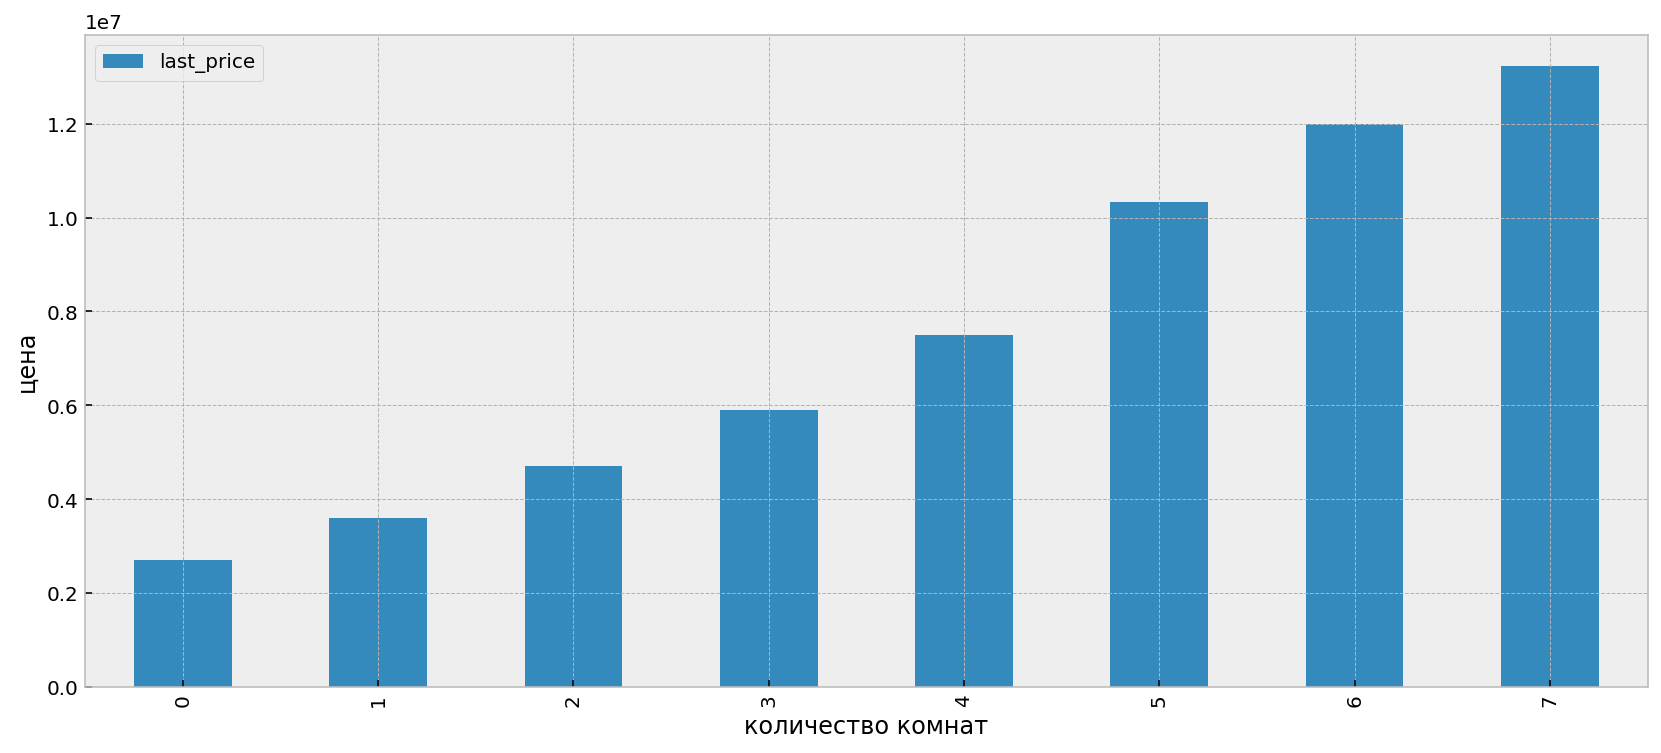

In [102]:
df_ext.pivot_table(index='rooms', values='last_price', aggfunc='median'). \
plot(kind='bar', xlabel='количество комнат', ylabel='цена')
# строим график зависимости цены объекта от количества комнат

<AxesSubplot:title={'center':'Зависимость цены квартиры от типа этажа'}, xlabel='тип этажа объекта', ylabel='цена'>

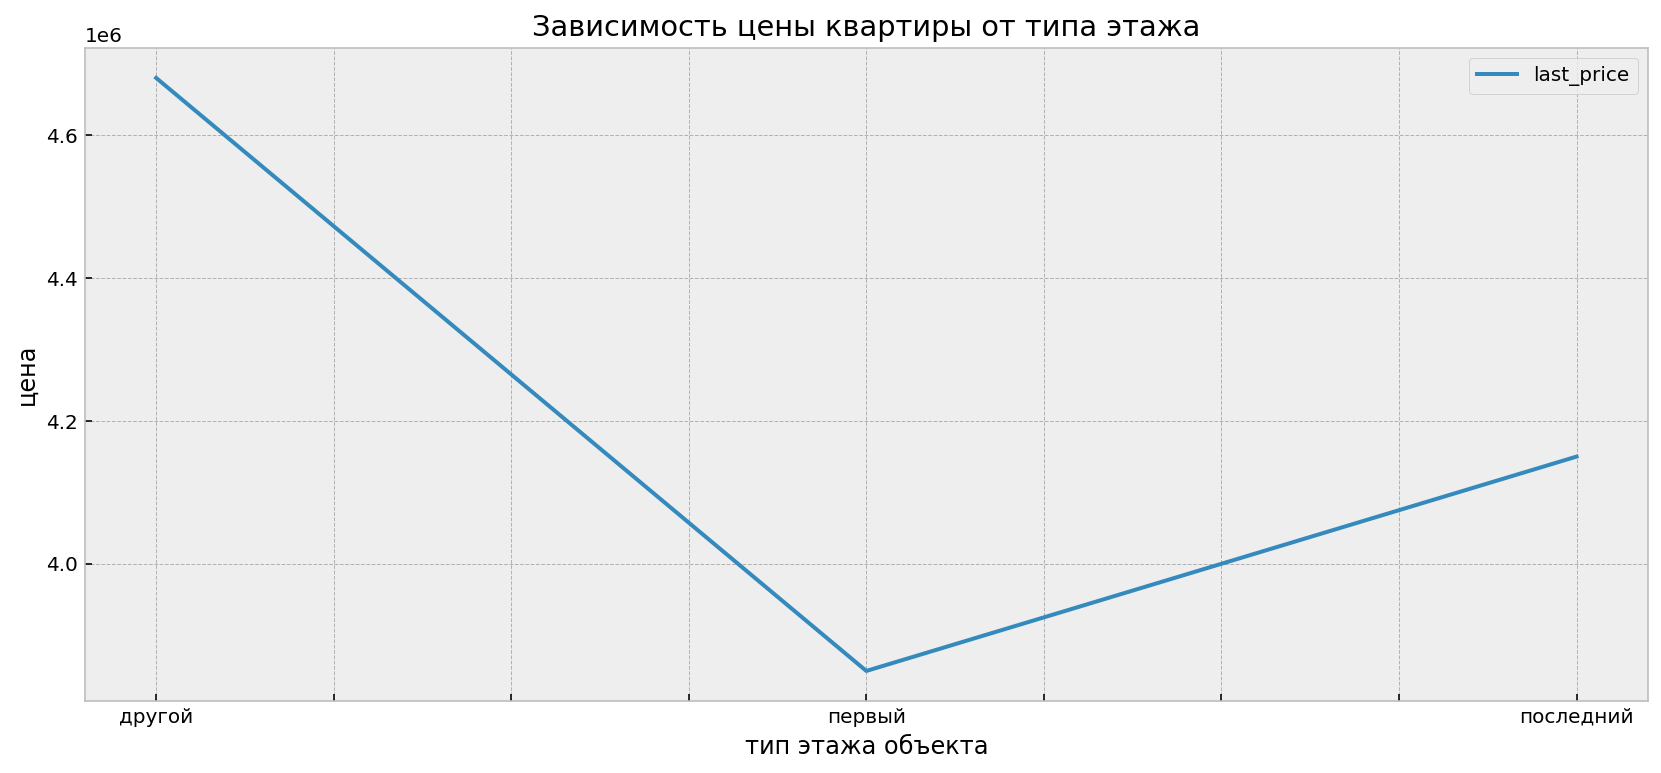

In [103]:
df_ext.pivot_table(index='floor_type', values='last_price', aggfunc='median'). \
plot(xlabel='тип этажа объекта', ylabel='цена', title='Зависимость цены квартиры от типа этажа')
# строим график зависимости цены объекта от типа этажа, на котором находится объект

<AxesSubplot:title={'center':'Зависимость цены квартиры от дня недели публикации'}, xlabel='день недели публикации', ylabel='цена'>

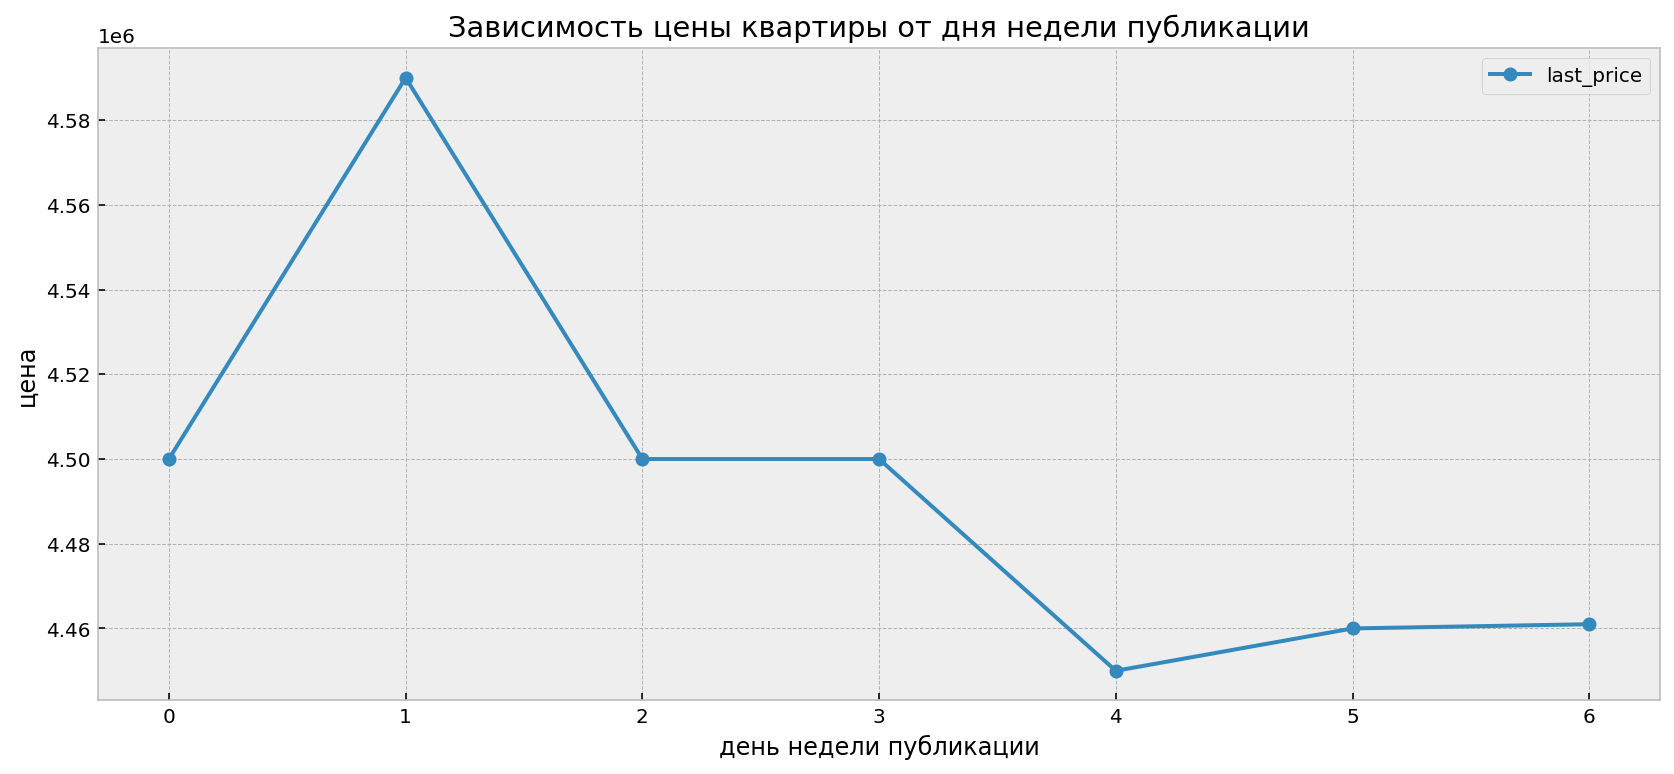

In [104]:
df_ext.pivot_table(index='day_of_publication', values='last_price', aggfunc=('median')).plot(style='o-', \
xlabel='день недели публикации', ylabel='цена', title='Зависимость цены квартиры от дня недели публикации')
# строим график зависимости цены квартиры от дня публикации объявления

<AxesSubplot:title={'center':'Зависимость цены квартиры от месяца публикации'}, xlabel='месяц публикации', ylabel='цена'>

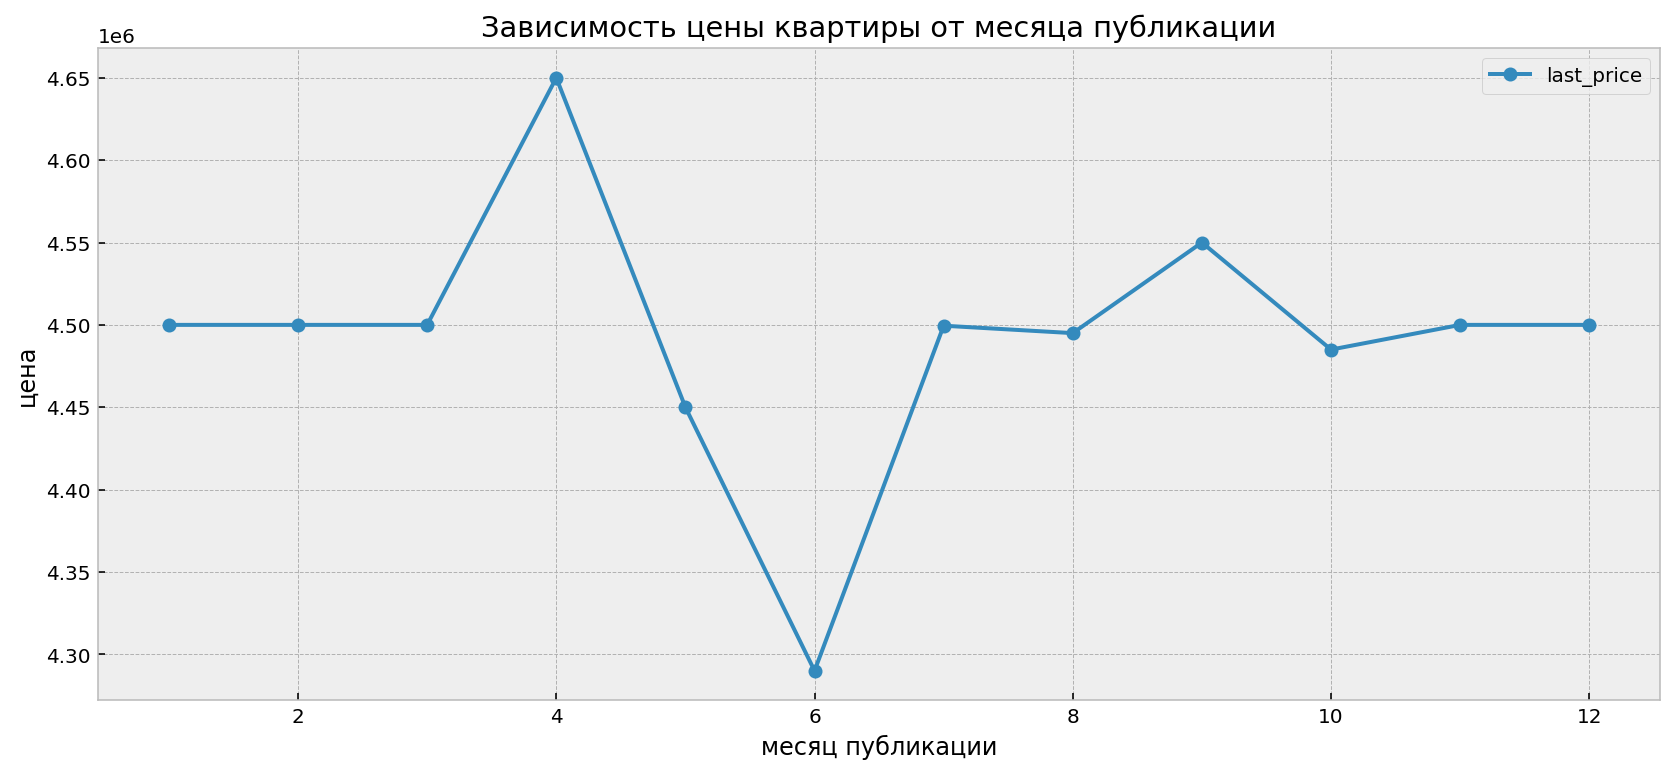

In [105]:
df_ext.pivot_table(index='month_of_publication', values='last_price', aggfunc=('median')).plot(style='o-', \
xlabel='месяц публикации', ylabel='цена', title='Зависимость цены квартиры от месяца публикации')
# строим график зависимости цены объекта от месяца публикации

<AxesSubplot:title={'center':'Зависимость цены квартиры от года публикации'}, xlabel='год публикации', ylabel='цена'>

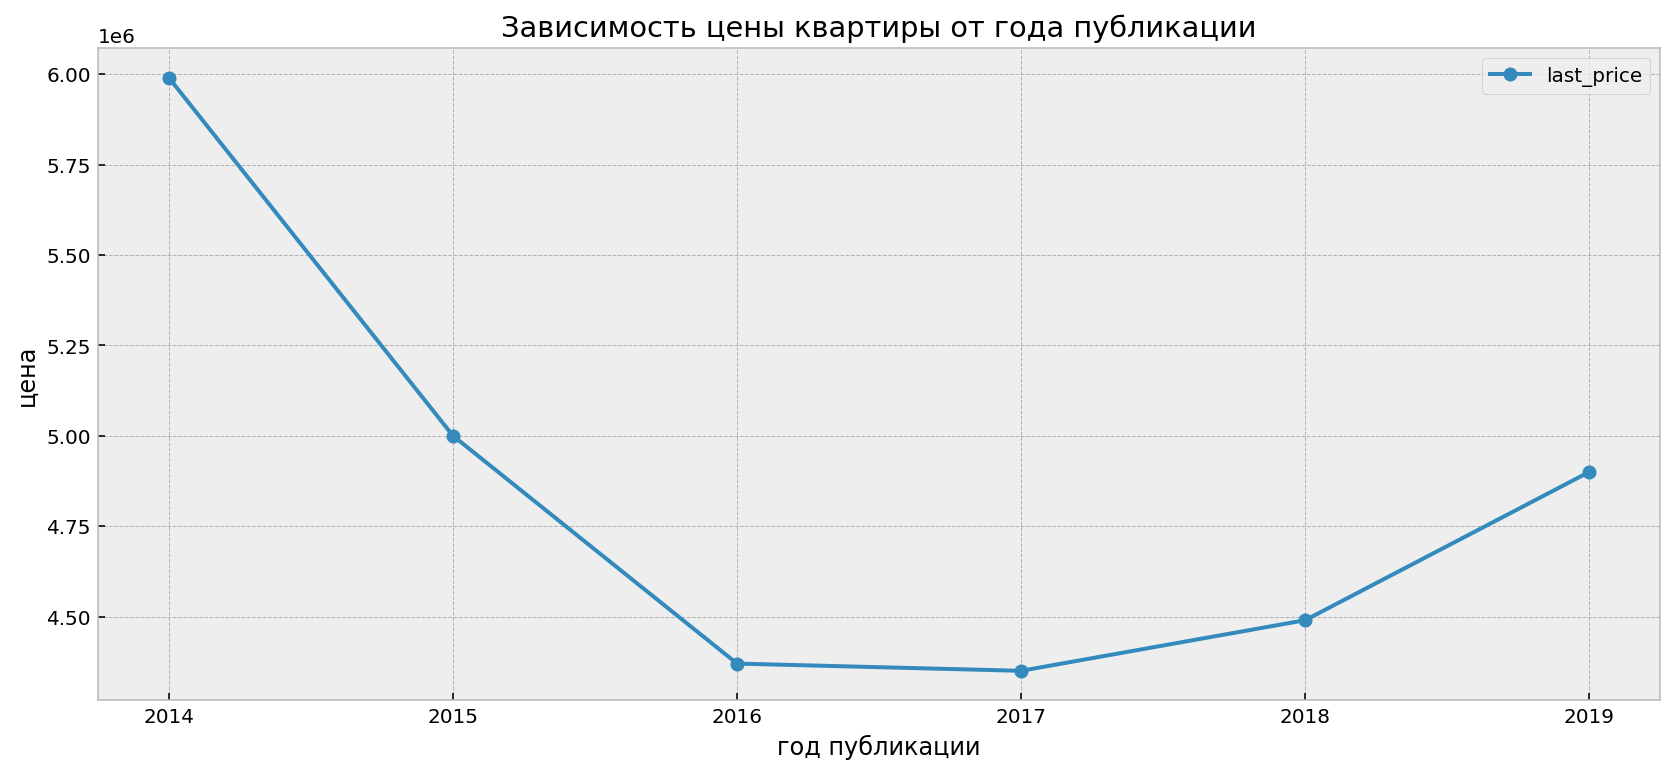

In [106]:
df_ext.pivot_table(index='year_of_publication', values='last_price', aggfunc=('median')).plot(style='o-', \
xlabel='год публикации', ylabel='цена', title='Зависимость цены квартиры от года публикации')
# строим график зависимости цены объекта от года публикации

**Комментарий к анализу влияния разных показателей на цену объекта**

- цена объекта прежде всего зависит от его площади, это касается и общей площади, и жилой, и площади кухни, в основном, с ростом размеров квартиры растет и стоимость, за исключением некоторых выбивающихся значений - возможно, это квартиры без ремонта или совсем старым ремонтом (учитывая, что все остальные объекты имеют приемлемое состояние), другой причиной появления таких аномально дешевых квартир может стать быстрая нужда в деньгах у владельца, обратная ситуация у аномально дорогих по соотношению метраж / цена - в таких объектах либо много денег вложено в ремонт, либо владелец совсем не спешит с продажей
- однако у сильно больших квартир более 200 метров квадратных цена может расти сильно непропорционально, этому есть несколько объяснений: в таких квартирах может быть крайне дорогой ремонт, в силу того, что такие лоты - редкость, продавец ставит цену, которая сильно выше рынка, а также владельцами таких объектов чаще всего являются состоятельные люди, которые совсем не спешат с продажей
- количество комнат влияет на цену линейно, то есть чем больше комнат, тем дороже квартира - без сюрпризов, наибольший относительный прирост можно увидеть у 5-ти комнатных объектов, возможно, таких квартир просто было мало или же просто с 5-ти комнатных квартир начинаются объекты другого класса (более "премиальные")
- гипотеза о том, что день недели или месяц публикации как-то влияют на цену объекта подтвердилась
- так, объекты, опубликованные в ближайшие дни от вторника (пн и ср-чт), имеют медианную цену выше, чем квартиры, выставленные с пятницы по воскресенье, это можно объяснить тем, что медианная цена квартир, выставленных в определннные месяцы (апрель / сентябрь), имеют медианную цену выше, чем у объектов, выставленных в другие месяцы, поэтому если в апреле / сентябре большинство квартир было опубликовано с понедельника по четверг, то это все объясняет, в ином случае необходимо проводить более глубокое исследования причин такого разброса в цене объекта в зависимости от дня недели публикации
- стоит заметить так же, что от года публикации сильно зависит цена, это больше объясняется политическо-экономической обстановкой в стране, поэтому в 2014 году можно наблюдать пик, а после событий 2014 года пошел спад, и с 2018 года можно наблюдать тренд на рост, который сохранился и в 2019 году
- ожидаемо, самые дешевые квартиры - лоты на 1-ом этажах, далее идут объекты на последних этажах и немного выше медианная цена квартир на остальных этажах


### Таким образом, проведя анализ влияния разных факторов на цену объекта, можно выделить следующие моменты:

- больше площадь квартиры - выше цена
- в "премиум" сегменте рынок определяет продавец, а не спрос
- при публикации квартиры на продажу надо обращать внимание на текущее экономическое состояние населения, а также понимать прогнозы и тенденции на будущие периоды, чтобы продать квартиру максимально быстро и по рыночной цене 
- самые дешевые квартиры - лоты на 1-ом этажах, далее идут объекты на последних этажах и немного выше медианная цена квартир на остальных этажах

**Далее посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

In [107]:
df_ext['locality_name'].value_counts().sort_values(ascending=False).head(10)
# определим список 10 городов с наибольшим количество объявлений

санкт-петербург    14422
мурино               590
кудрово              471
шушары               440
всеволожск           396
пушкин               345
колпино              336
парголово            327
гатчина              307
выборг               233
Name: locality_name, dtype: int64

In [108]:
top_10_cities = df_ext.query('locality_name == ["санкт-петербург", "мурино", "кудрово", "шушары", \
"всеволожск", "пушкин", "колпино", "парголово", "гатчина", "выборг"]')
# создаем отдельный датафрейм с 10 самыми популярными регионами

<AxesSubplot:title={'center':'средняя цена квадратного метра в 10 самых популярных городах'}, ylabel='название города'>

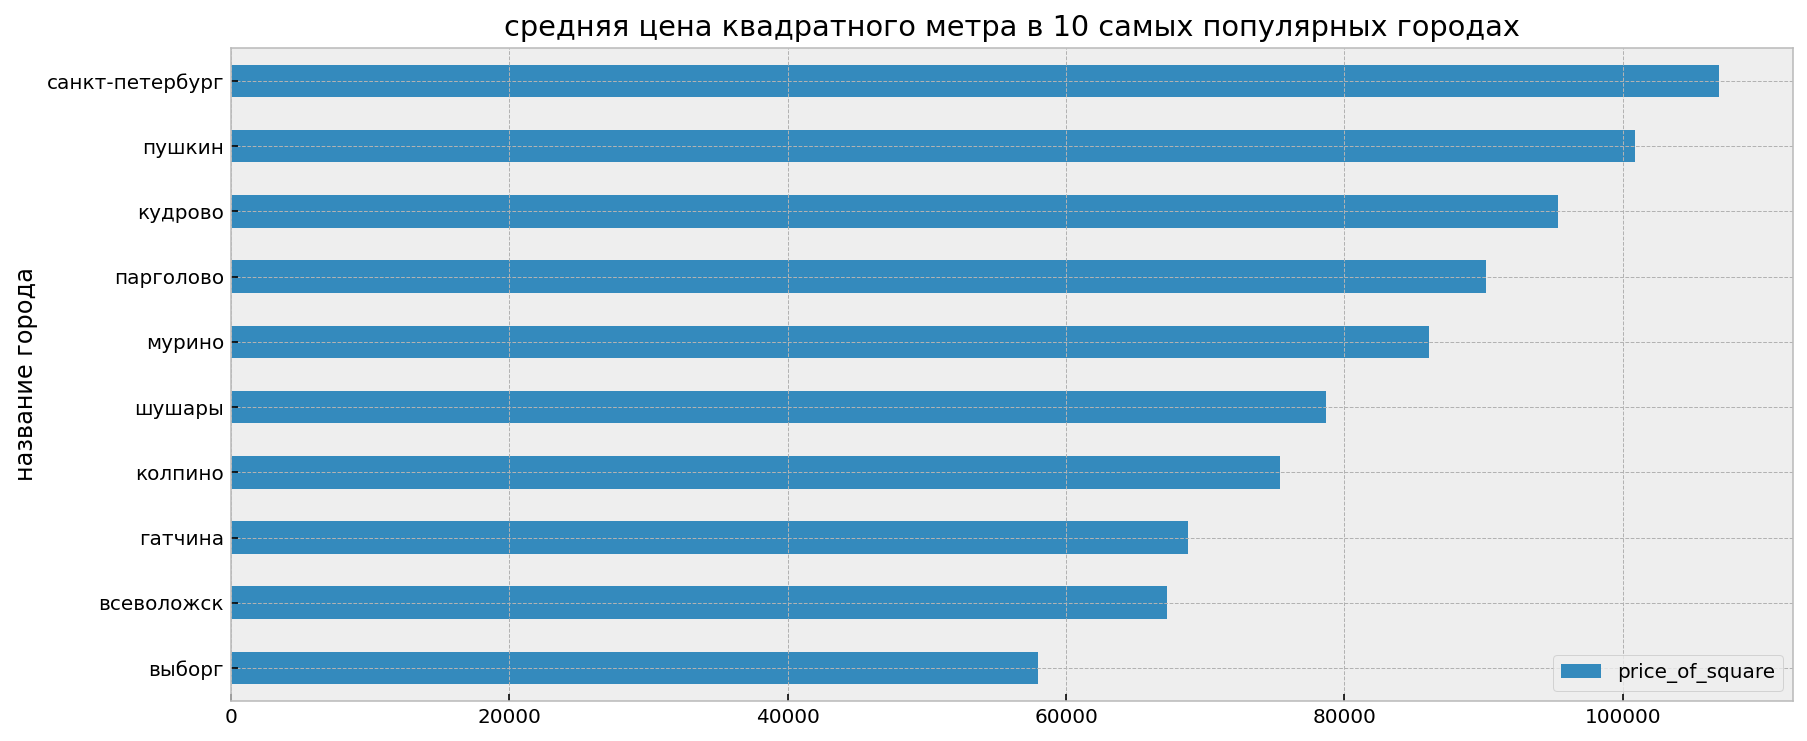

In [109]:
top_10_cities.pivot_table(index='locality_name', values='price_of_square').sort_values(by='price_of_square'). \
plot(kind='barh',  xlabel='название города', ylabel='цена квадратного метра', \
                      title='средняя цена квадратного метра в 10 самых популярных городах')
# строим столбчатую диаграмму со средней ценей квадратного метра в этих городах

**Построив диаграмму с 10 самыми популярными городами, можно увидеть следующее:**

- ожидаемо, самый дорогой метр в СПб, однако для репрезентативности данных по Санкт-Петербургу стоит учесть момент, что чем ближе квартира к центру, тем она дороже, поэтому **далее посчитаем среднюю цену каждого километра удаленности от центра**

<AxesSubplot:xlabel='cityCenters_nearest'>

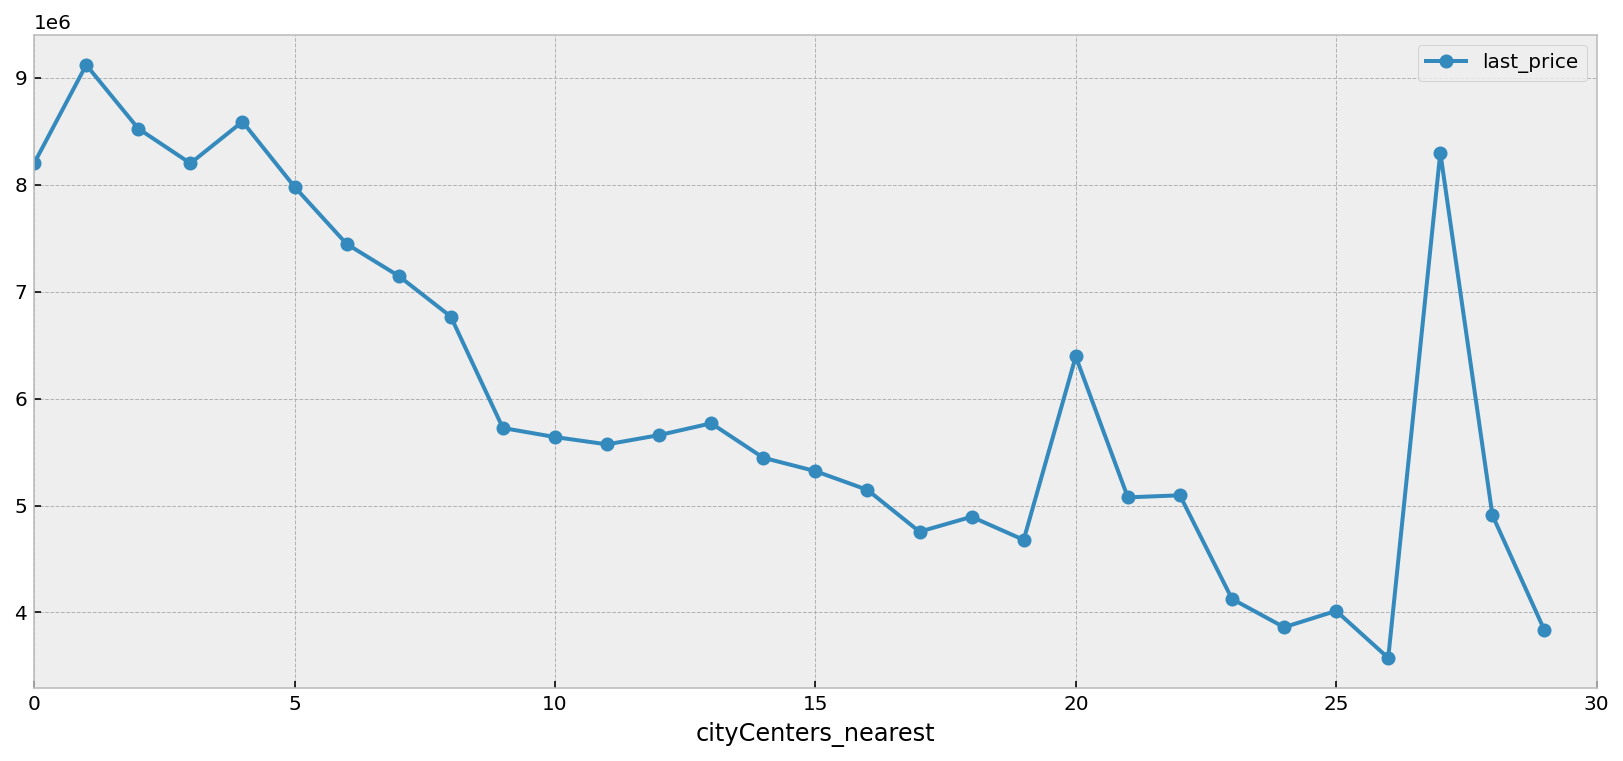

In [114]:
df_ext['cityCenters_nearest'] = df_ext['cityCenters_nearest'].fillna(0).astype(int)
# заменим пропуски на 0, чтобы приветси значения к целочисленному варианту
df_ext.loc[df_ext['locality_name'] == 'санкт-петербург'].pivot_table(index='cityCenters_nearest', \
values='last_price').plot(style='o-', xlim=(0,30))
# построим график цен квартир удаленности на 1 км от центра

**Комментарий к полученному графику**

- ожидаемо, чем дальше от центра, тем квартира стоит дешевле, однако можно выделить несколько интересных моментов  на графике, для этого построим отдельные графики для большей точности

**далее изучим аномальный спад в цене в районе 10 км от центра СПб**

<AxesSubplot:xlabel='cityCenters_nearest'>

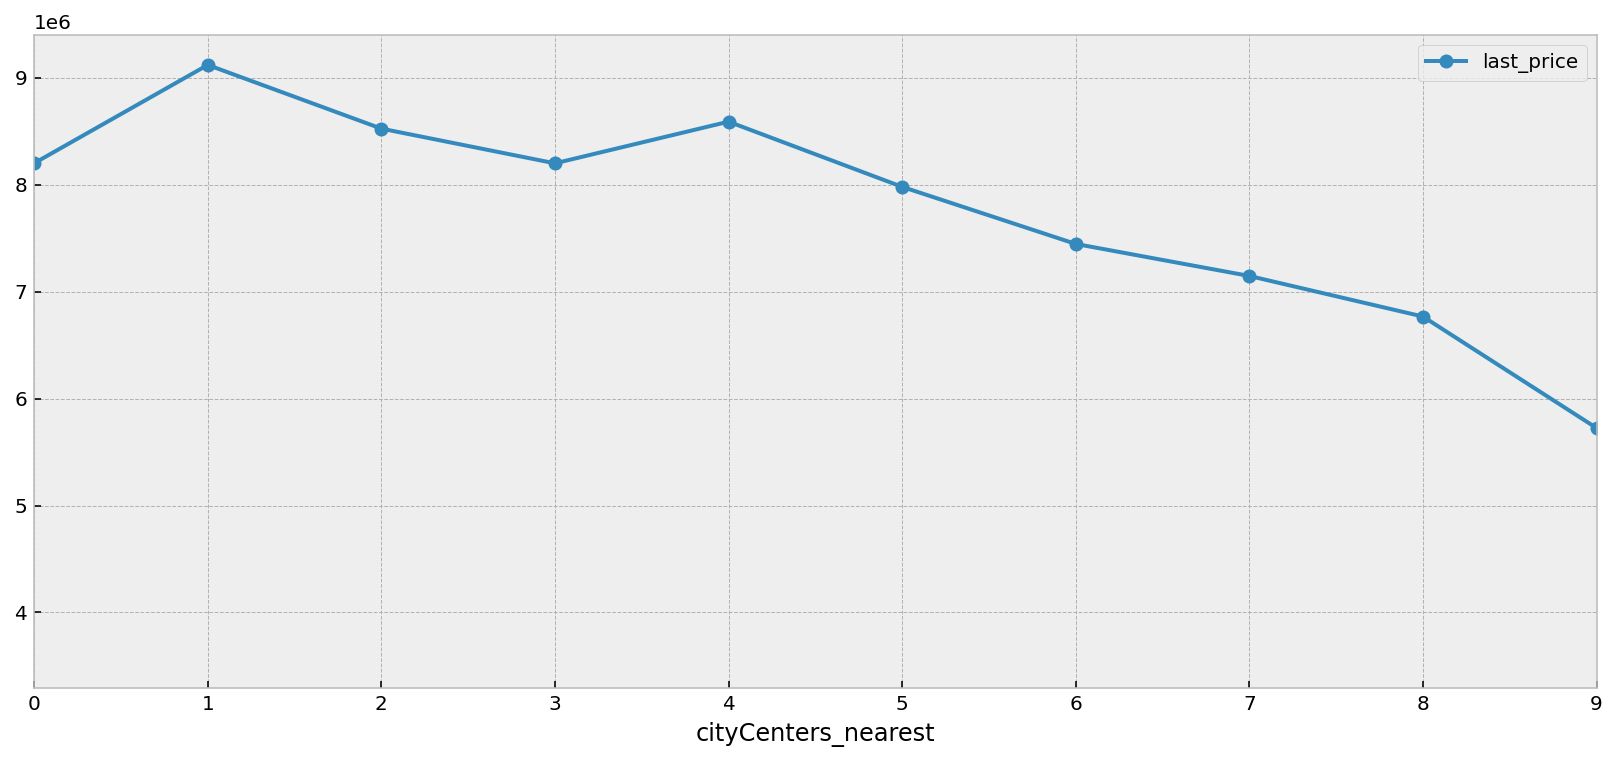

In [126]:
df_ext['cityCenters_nearest'] = df_ext['cityCenters_nearest'].fillna(0).astype(int)
# заменим пропуски на 0, чтобы приветси значения к целочисленному варианту
df_ext.loc[df_ext['locality_name'] == 'санкт-петербург'].pivot_table(index='cityCenters_nearest', \
values='last_price').plot(style='o-', xlim=(0,9))
# построим график цен квартир по удаленности на 1 км от центра в диапозоне (от 0 до 9 км от центра)

**Комментарий к полученному графику**

- пик цены в 1 км от центра может быть обусловлен тем, что прям в самом центре СПб не так уж много владельцев квартир, а уж тем более тех, кто готов продать столь редкую "площадь", поэтому, возможно, квартира в 0 км от центра просто в крайне плохом состоянии
- однако на данном графике присутствует резкий спад в цене на 9 км отдаленности от центра, возможно, на 8 км заканчивается исторический центр СПб или же в радиусе 8 км от центра санкт-петебурга намного больше инфрастуктрных объектов, поэтому на 9 км можно наблюдать резкое снижение цены

**далее изучим аномальный пики в районе 20-30 км от центра СПб**

<AxesSubplot:xlabel='cityCenters_nearest'>

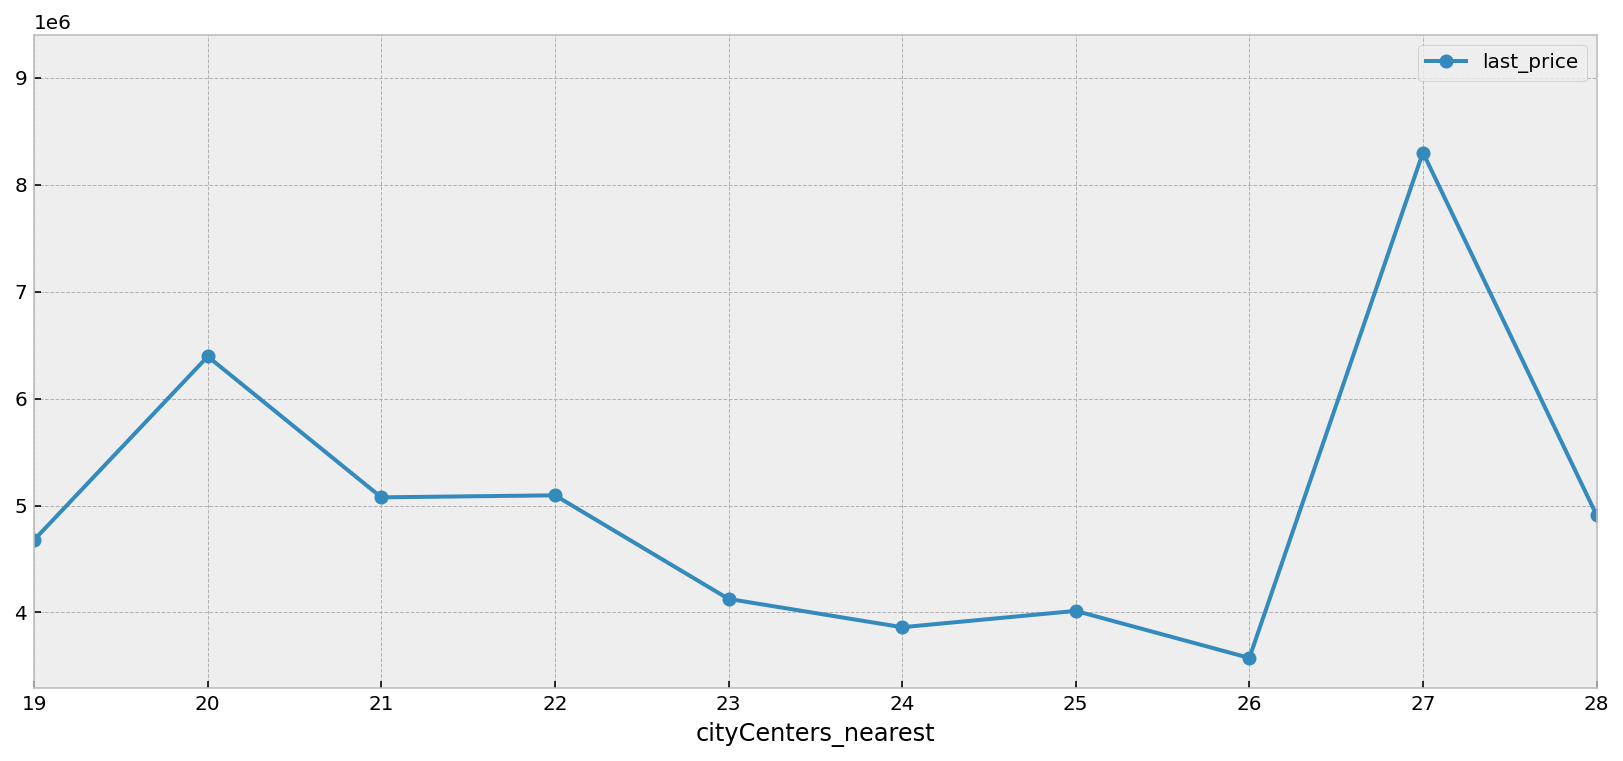

In [131]:
df_ext['cityCenters_nearest'] = df_ext['cityCenters_nearest'].fillna(0).astype(int)
# заменим пропуски на 0, чтобы приветси значения к целочисленному варианту
df_ext.loc[df_ext['locality_name'] == 'санкт-петербург'].pivot_table(index='cityCenters_nearest', \
values='last_price').plot(style='o-', xlim=(19,28))
# построим график цен квартир по удаленности на 1 км от центра в диапозоне (от 19 до 28 км от центра)

**Комментарий к полученному графику**

- пики цены в 20 км и 27 км от центра могут быть обусловлены тем, что в этом месте расположены какие-то коттеджные поселки или элитные "зеленые" районы

**А далее подведем итоги всего исследования**

## Итоги исследования


- медианное время продажи объекта составило 92 дня, быстрой сделкой можно считать продажи совершенные менее чем за 44 дня, медленными же - более чем за 223 дня
- наибольшее влияние на стоимость объекта оказывает его площадь (общая, жилая и кухни), далее по значимости идет количество комнат
- самые дешевые объекты находятся на первых этажах, а разница в цене между квартирой на последних этажах и на любом другом (за исключением 1-ого) минимальна
- самый дорогой "метр" в Санкт-Петербурге - 102 666 рублей
- самый дешевый "метр" в Выборге  - 58 158 рублей
- в основном стоимость квартир СПб линенйно зависит от удаленности от центра города, то есть чем дальше от него, тем квартира дешевле, однако бывают некоторые "участки" - районы / коттеджные поселки - где цена будет анамольно высокой для такой удаленности от центра, это может обуславливаться специфичностью самих объектов в этом места, а также наличием специальной инфрастуктурой и другими факторами